$$
\newcommand{\paren}[1]{\left(#1\right)}
\newcommand{\brac}[1]{\left\{#1\right\}}
\newcommand{\brak}[1]{\left[#1\right]}
\newcommand{\abs}[1]{\left|#1\right|}
\newcommand{\E}[1]{\mathbb{E}\left[#1\right]}
\newcommand{\pr}[1]{\Pr\paren{#1}}
\newcommand{\halpha}[0]{\hat{\alpha}}
$$

# 2章 マーケティングにデータサイエンスを導入する


## マーケティング活動としてのテレビCM

## ステップ1：ビジネス課題を数理最適化問題として定式化する

## ステップ2：数理モデル構築し、未知のパラメータをデータから推定する

In [1]:
import json  # ファイル読み込み

import matplotlib.pyplot as plt  # 可視化
import numpy as np  # データ処理
import polars as pl  # データ処理
import seaborn as sns  # 可視化
from matplotlib.axes import Axes  # 型ヒント
from matplotlib.figure import Figure  # 型ヒント
from matplotlib.ticker import PercentFormatter  # 型ヒント

In [2]:
# 乱数を固定
np.random.seed(42)

# データの表示設定
pl.Config.set_float_precision(precision=3)

# 可視化の設定
with open("../setting/visualization.json") as f:
    setting = json.load(f)
sns.set_theme(**setting)
sns.set_palette("gray", 4)

In [3]:
# データの読み込み

# 全時点のデータ
df_reach = pl.read_csv("../data/ch02/reach.csv")

# 調査時点のデータ
df_reach_observed = pl.read_csv("../data/ch02/reach_observed.csv")

# 観測できない全時点のデータの確認
df_reach

shape: (1_165, 3)
┌──────┬───────┬───────┐
│ t    ┆ g     ┆ r     │
│ ---  ┆ ---   ┆ ---   │
│ i64  ┆ f64   ┆ f64   │
╞══════╪═══════╪═══════╡
│ 1    ┆ 0.003 ┆ 0.003 │
│ 2    ┆ 0.007 ┆ 0.007 │
│ 3    ┆ 0.013 ┆ 0.012 │
│ 4    ┆ 0.015 ┆ 0.015 │
│ 5    ┆ 0.024 ┆ 0.023 │
│ …    ┆ …     ┆ …     │
│ 1161 ┆ 3.526 ┆ 0.613 │
│ 1162 ┆ 3.528 ┆ 0.613 │
│ 1163 ┆ 3.529 ┆ 0.613 │
│ 1164 ┆ 3.532 ┆ 0.613 │
│ 1165 ┆ 3.537 ┆ 0.613 │
└──────┴───────┴───────┘

In [4]:
# 観測できた1点のみのデータを確認
df_reach_observed

shape: (1, 3)
┌─────┬───────┬───────┐
│ t   ┆ g     ┆ r     │
│ --- ┆ ---   ┆ ---   │
│ i64 ┆ f64   ┆ f64   │
╞═════╪═══════╪═══════╡
│ 600 ┆ 1.859 ┆ 0.505 │
└─────┴───────┴───────┘

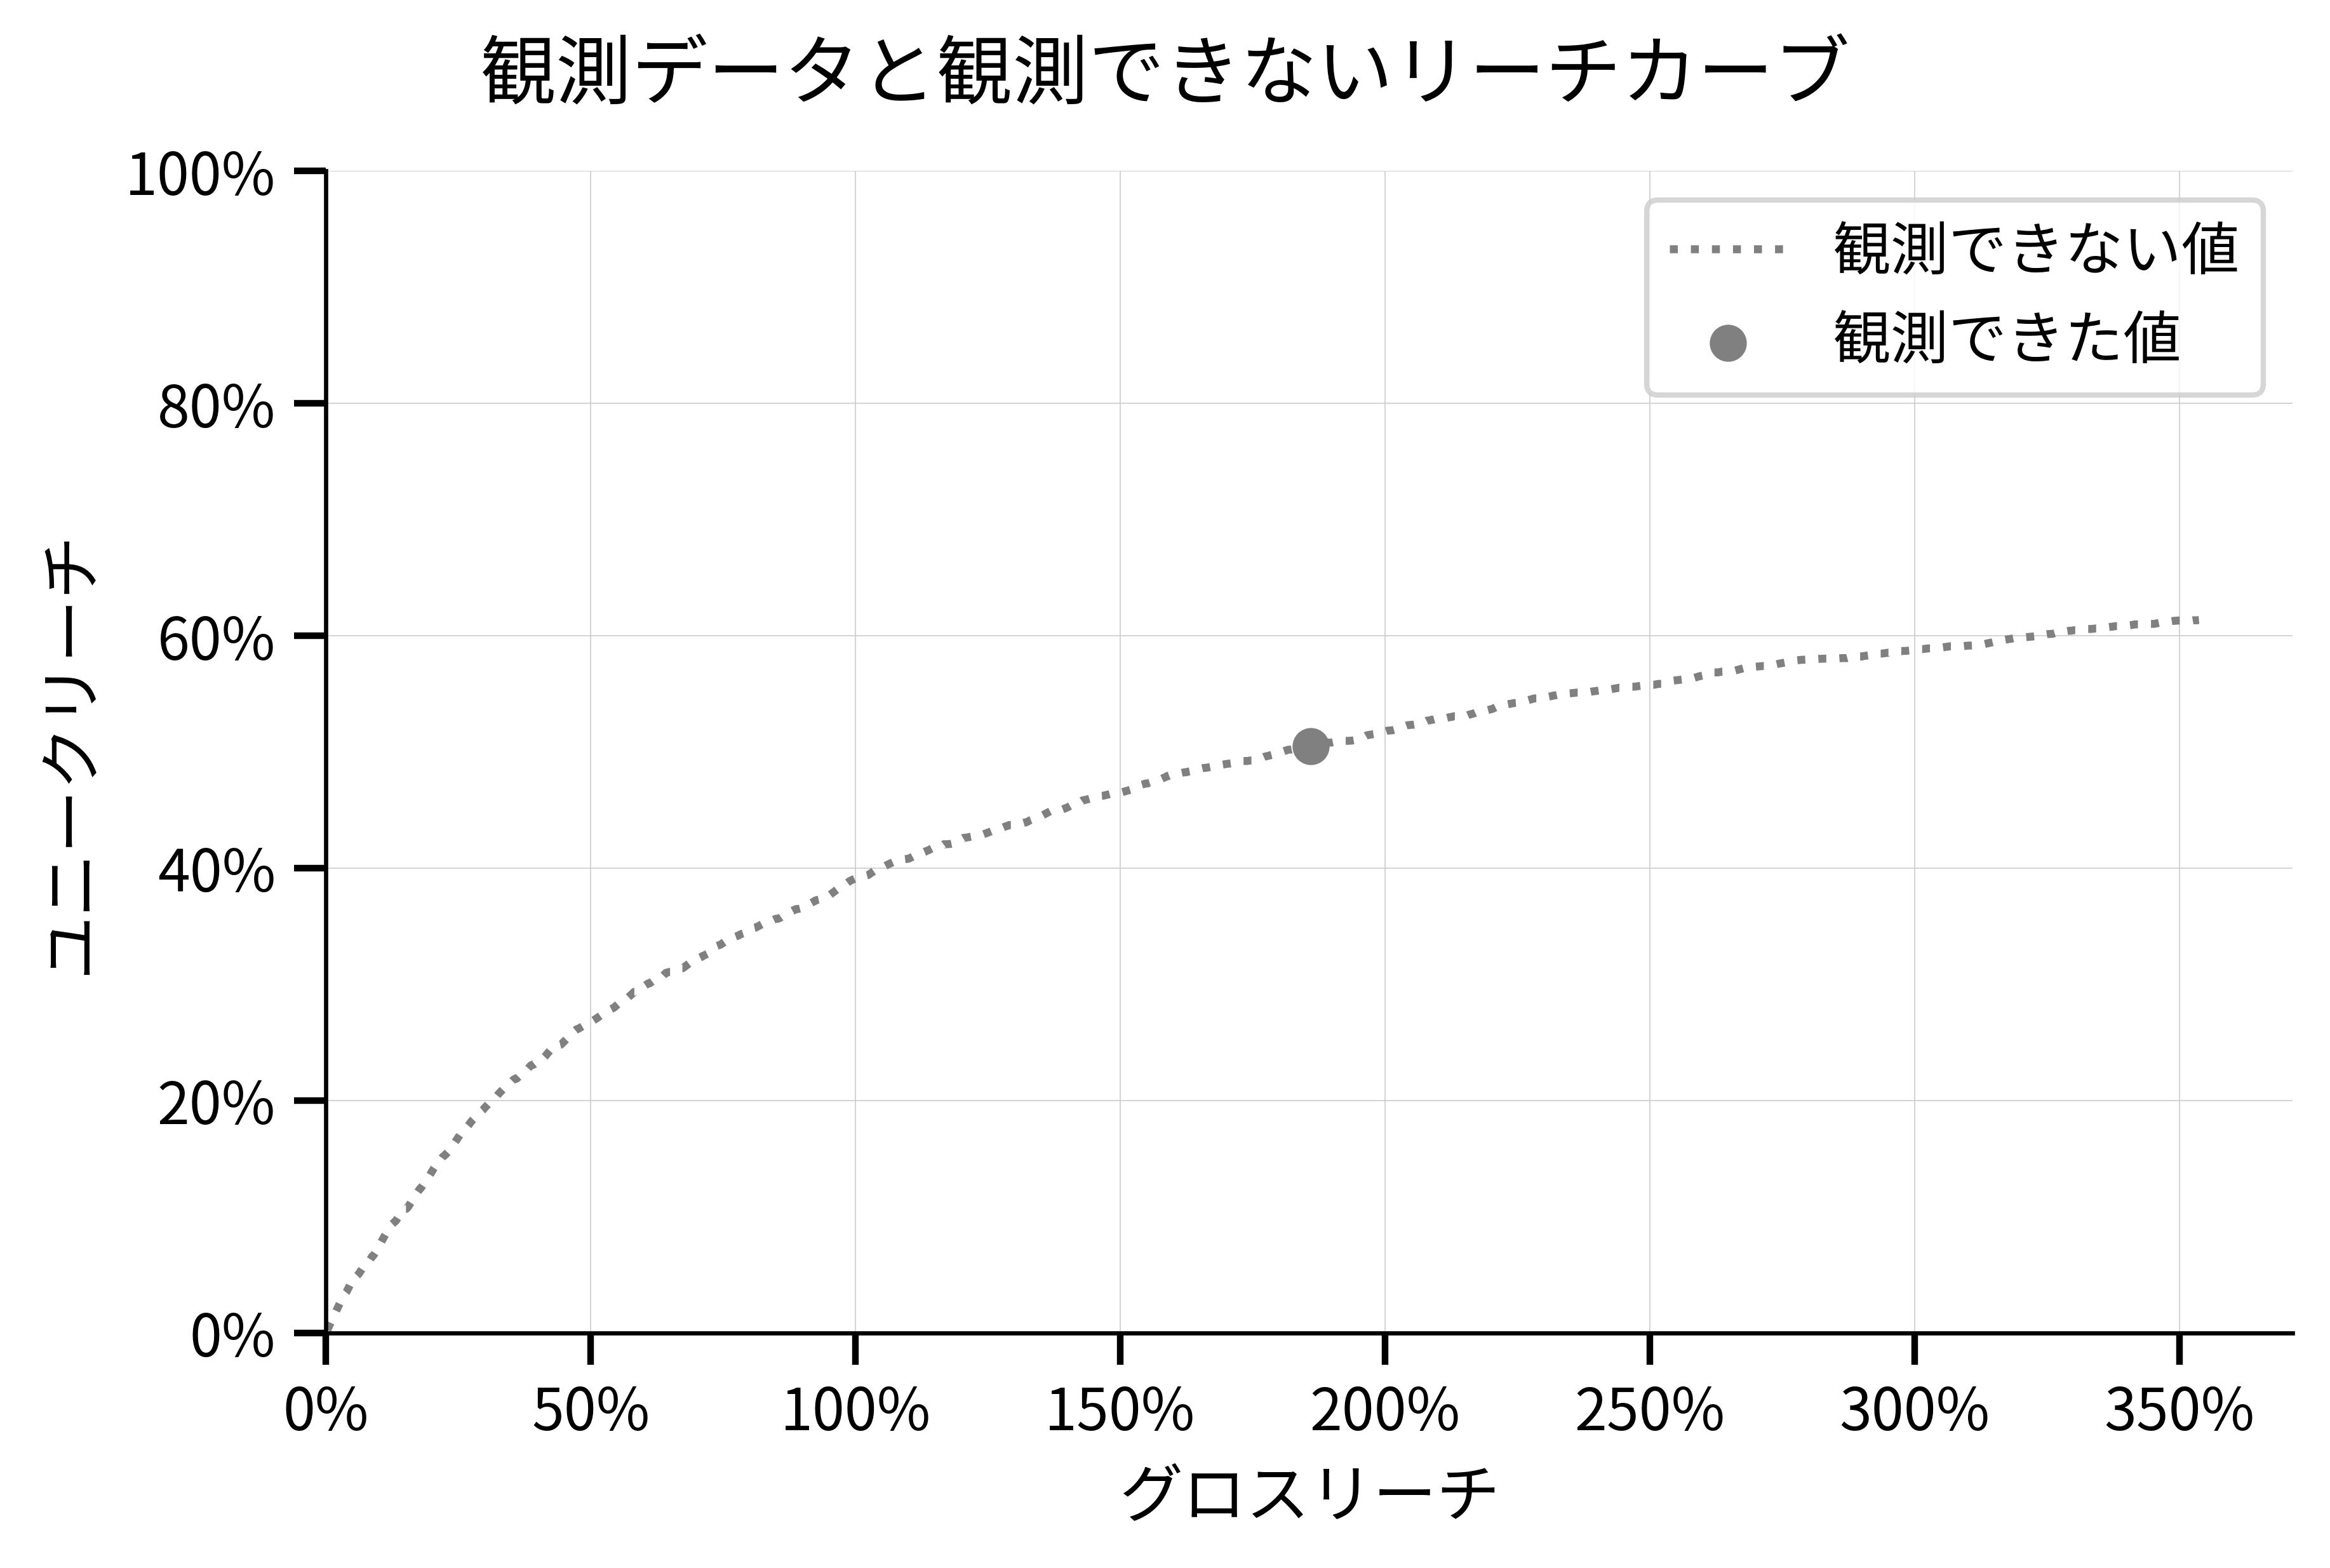

In [5]:
def plot_reach_curve(
    df_reach: pl.DataFrame,
    df_reach_observed: pl.DataFrame,
    title: str,
) -> tuple[Figure, Axes]:
    """
    実際には観測できないリーチカーブと、観測できるデータポイント1点を可視化する
    """

    fig, ax = plt.subplots()

    # 観測できないリーチカーブ全体
    ax.plot(
        df_reach["g"],
        df_reach["r"],
        linestyle="dotted",
        color="0.5",
        label="観測できない値",
        zorder=1,
    )
    # 観測できる1点
    ax.scatter(
        df_reach_observed["g"],
        df_reach_observed["r"],
        color="0.5",
        zorder=2,
        label="観測できた値",
    )
    ax.legend()

    # 軸の目盛りを%表示にする
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_xlim(0, None)
    ax.set_ylim(0, 1)
    ax.set_xlabel("グロスリーチ")
    ax.set_ylabel("ユニークリーチ")

    fig.suptitle(title)

    return fig, ax


# リーチカーブの可視化
fig, ax = plot_reach_curve(
    df_reach=df_reach,
    df_reach_observed=df_reach_observed,
    title="観測データと観測できないリーチカーブ",
)

In [6]:
# 学習用データ。1点のみ
# scikit-learnの入力形式に合わせる
g_train = df_reach_observed[["g"]].to_numpy()
r_train = df_reach_observed["r"].to_numpy()

# テスト用データ。観測されていないデータも含む全時点データ
g_test = df_reach[["g"]].to_numpy()

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Random Forestによるリーチカーブの推定
rf = RandomForestRegressor(
    n_jobs=-1, random_state=42
)  # 全コアで並列化。乱数シードを固定
rf.fit(g_train, r_train)
r_pred_rf = rf.predict(g_test)  # リーチカーブの推定

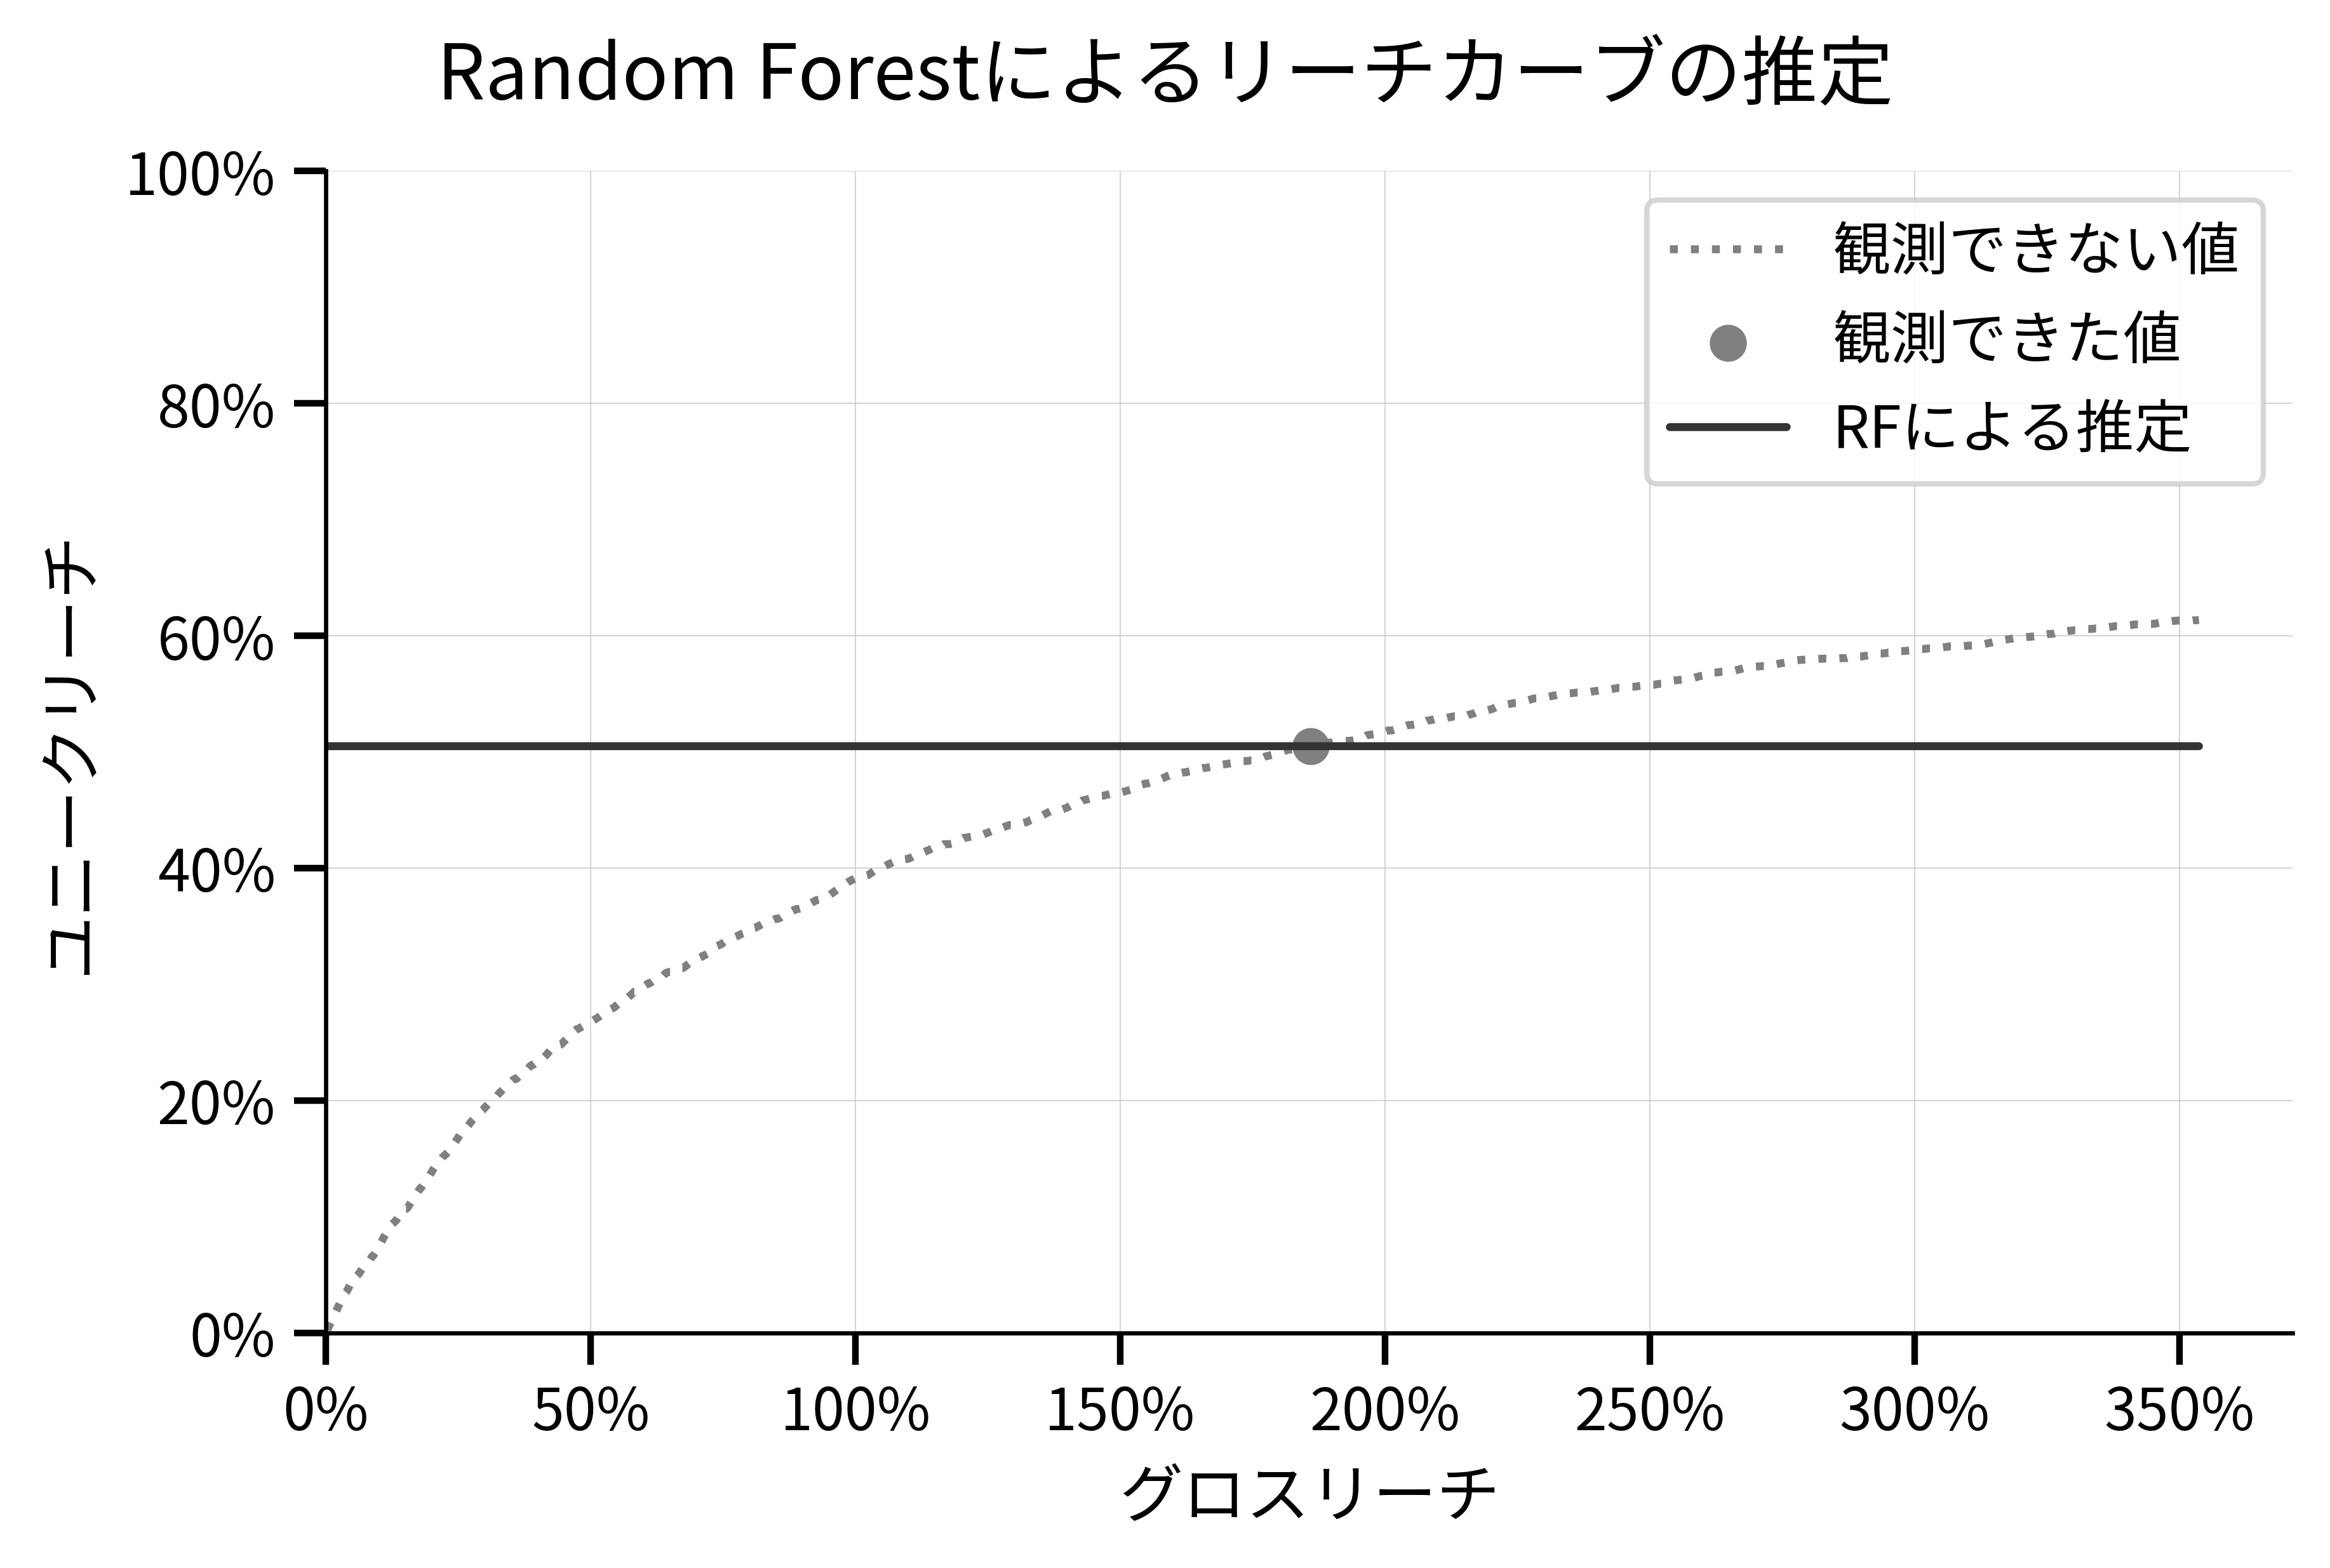

In [8]:
def plot_reach_curve_with_prediction(
    df_reach: pl.DataFrame,
    df_reach_observed: pl.DataFrame,
    r_pred: np.ndarray,
    prediction_label: str,
    title: str,
) -> tuple[Figure, Axes]:
    """観測されない本当のリーチカーブと、推定されたリーチカーブを可視化する"""

    fig, ax = plot_reach_curve(df_reach, df_reach_observed, title)
    # 推定されたリーチカーブを追加
    ax.plot(df_reach["g"], r_pred, label=prediction_label)
    ax.legend()

    return fig, ax


# Random Forestによるリーチカーブの可視化
fig, ax = plot_reach_curve_with_prediction(
    df_reach=df_reach,
    df_reach_observed=df_reach_observed,
    r_pred=r_pred_rf,
    prediction_label="RFによる推定",
    title="Random Forestによるリーチカーブの推定",
)

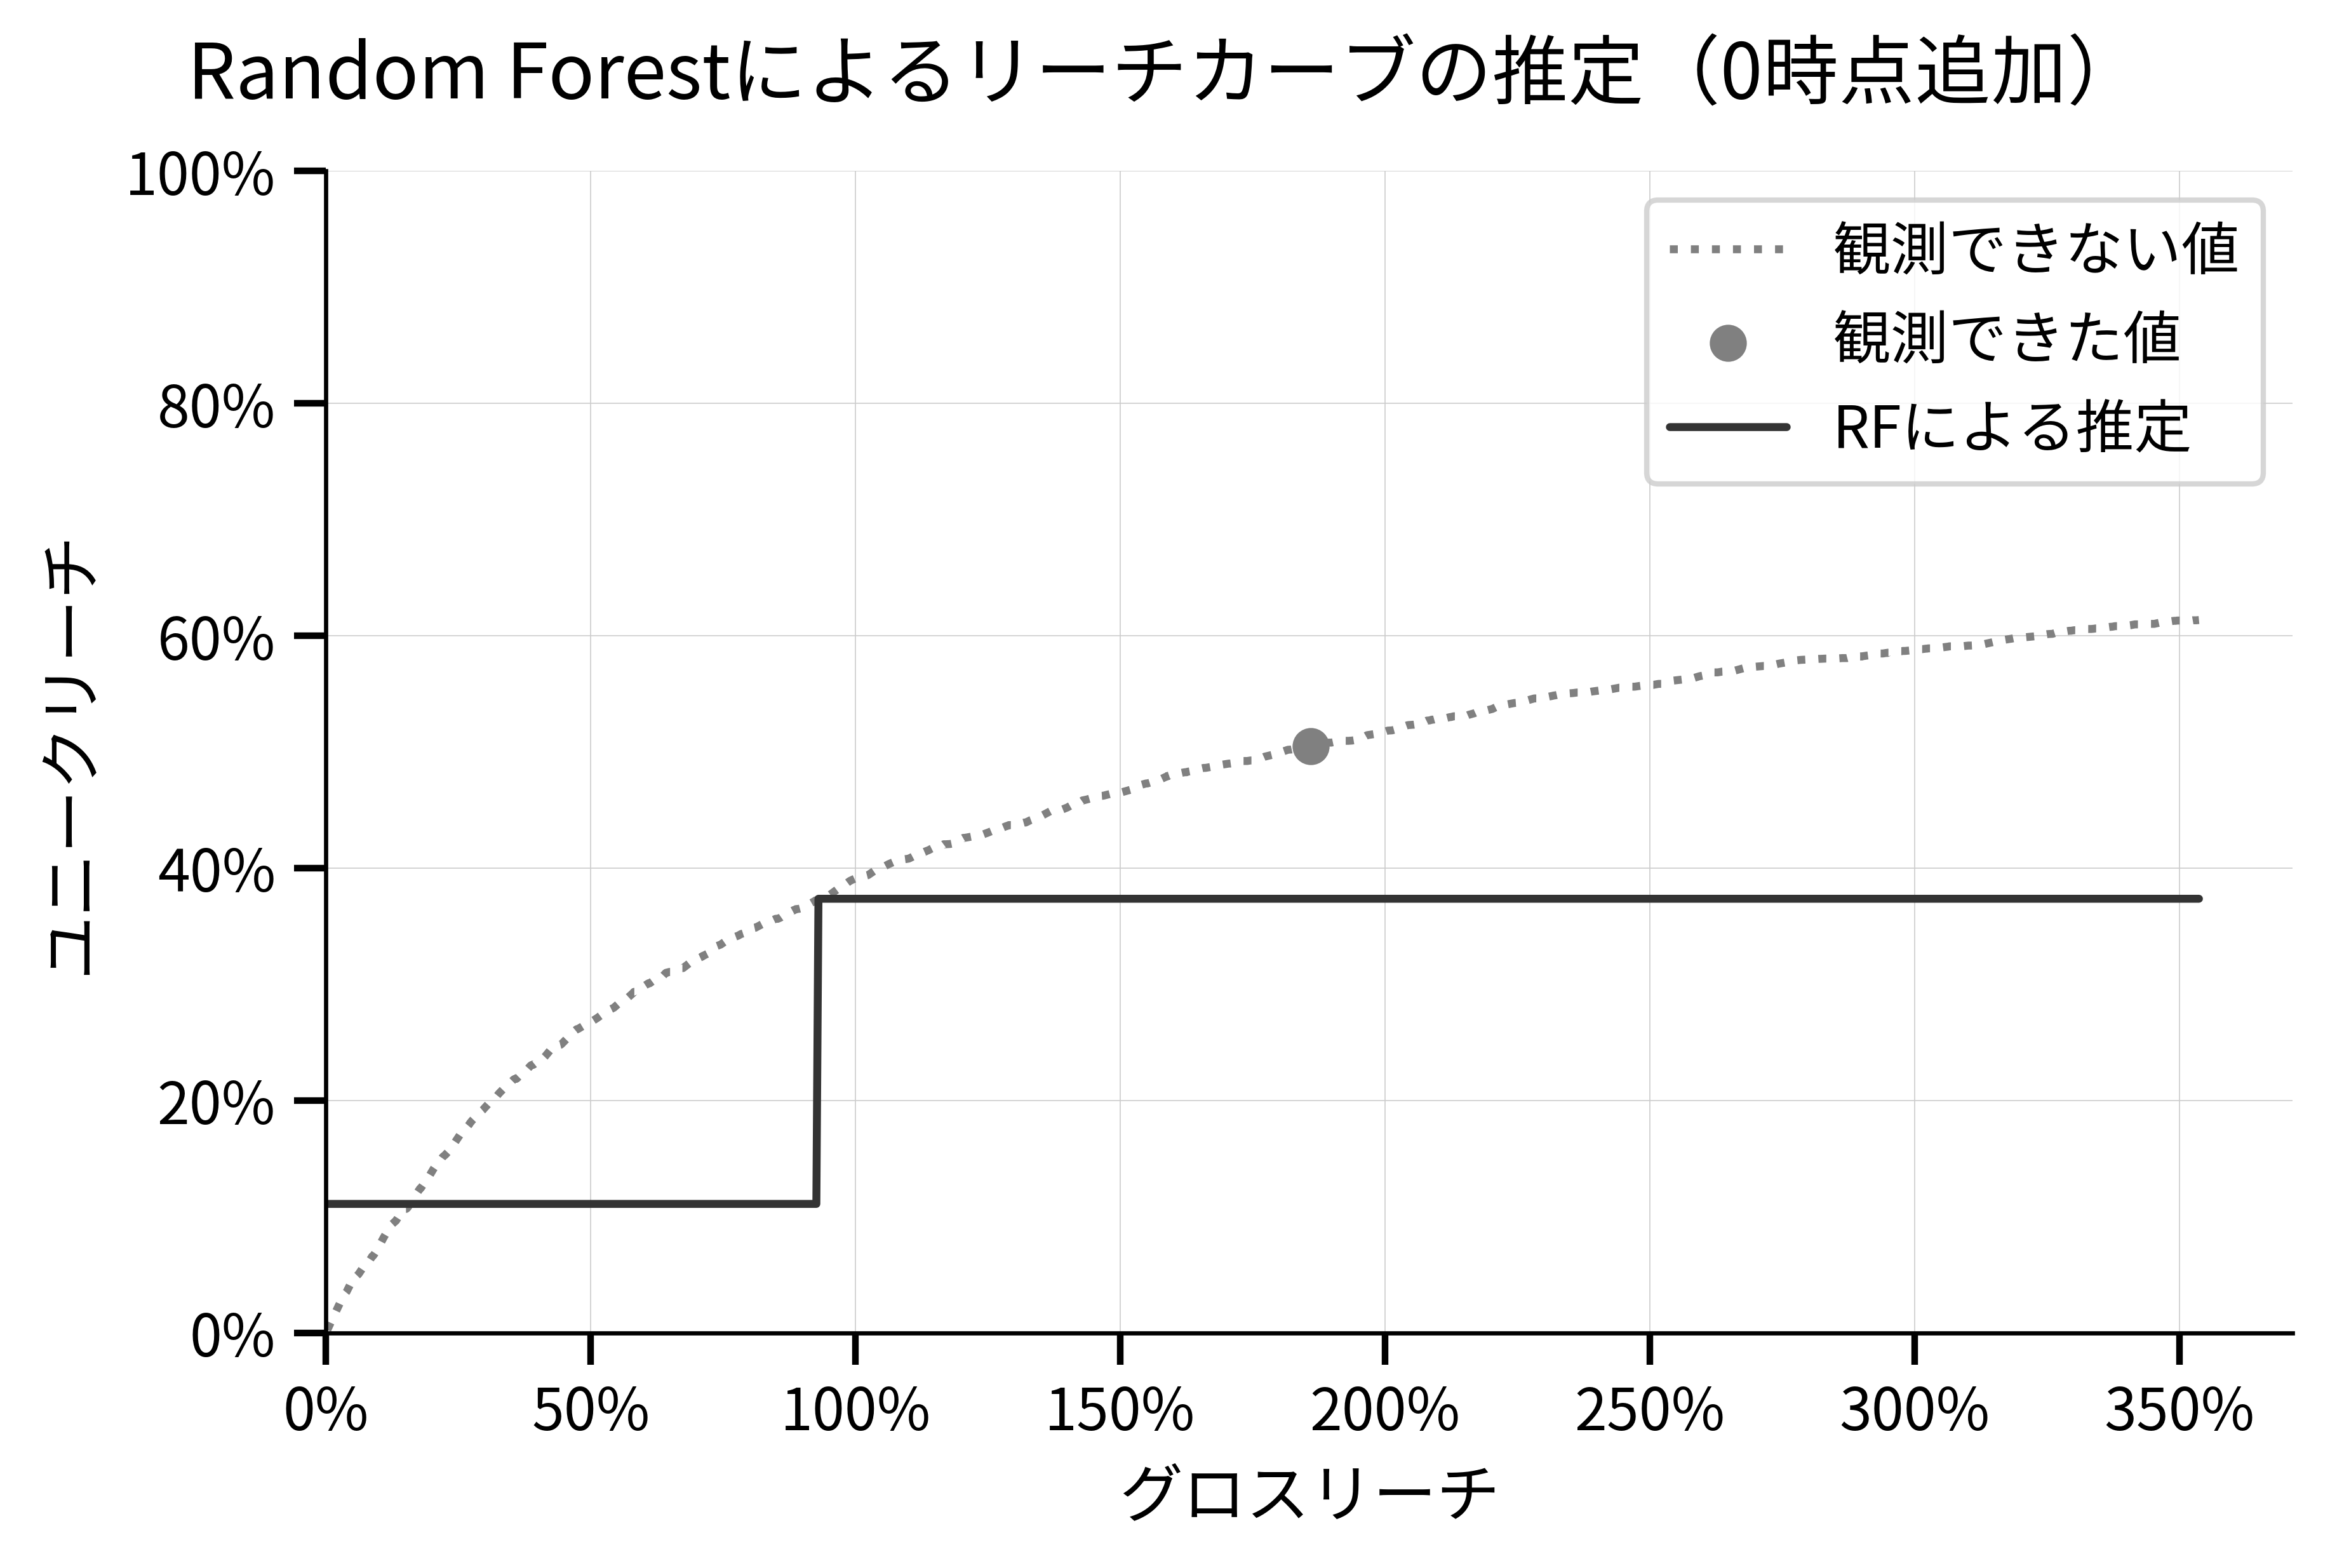

In [9]:
# 0時点の情報を追加
g_train_2 = np.concatenate([np.zeros_like(g_train), g_train], axis=0)
r_train_2 = np.concatenate([np.zeros_like(r_train), r_train], axis=0)

# Random Forestによるリーチカーブの推定
rf2 = RandomForestRegressor(
    n_jobs=-1, random_state=42
)  # 全コアで並列化。乱数シードを固定
rf2.fit(g_train_2, r_train_2)
r_pred_rf2 = rf2.predict(g_test)  # リーチカーブの推定

# Random Forestによるリーチカーブの可視化
fig, ax = plot_reach_curve_with_prediction(
    df_reach=df_reach,
    df_reach_observed=df_reach_observed,
    r_pred=r_pred_rf2,
    prediction_label="RFによる推定",
    title="Random Forestによるリーチカーブの推定（0時点追加）",
)

In [10]:
from sklearn.linear_model import LinearRegression

lr_linear = LinearRegression(fit_intercept=False)  # 切片を0に固定
lr_linear.fit(g_train, r_train)  # 1点で学習
r_pred_linear = lr_linear.predict(g_test)  # リーチカーブの推定

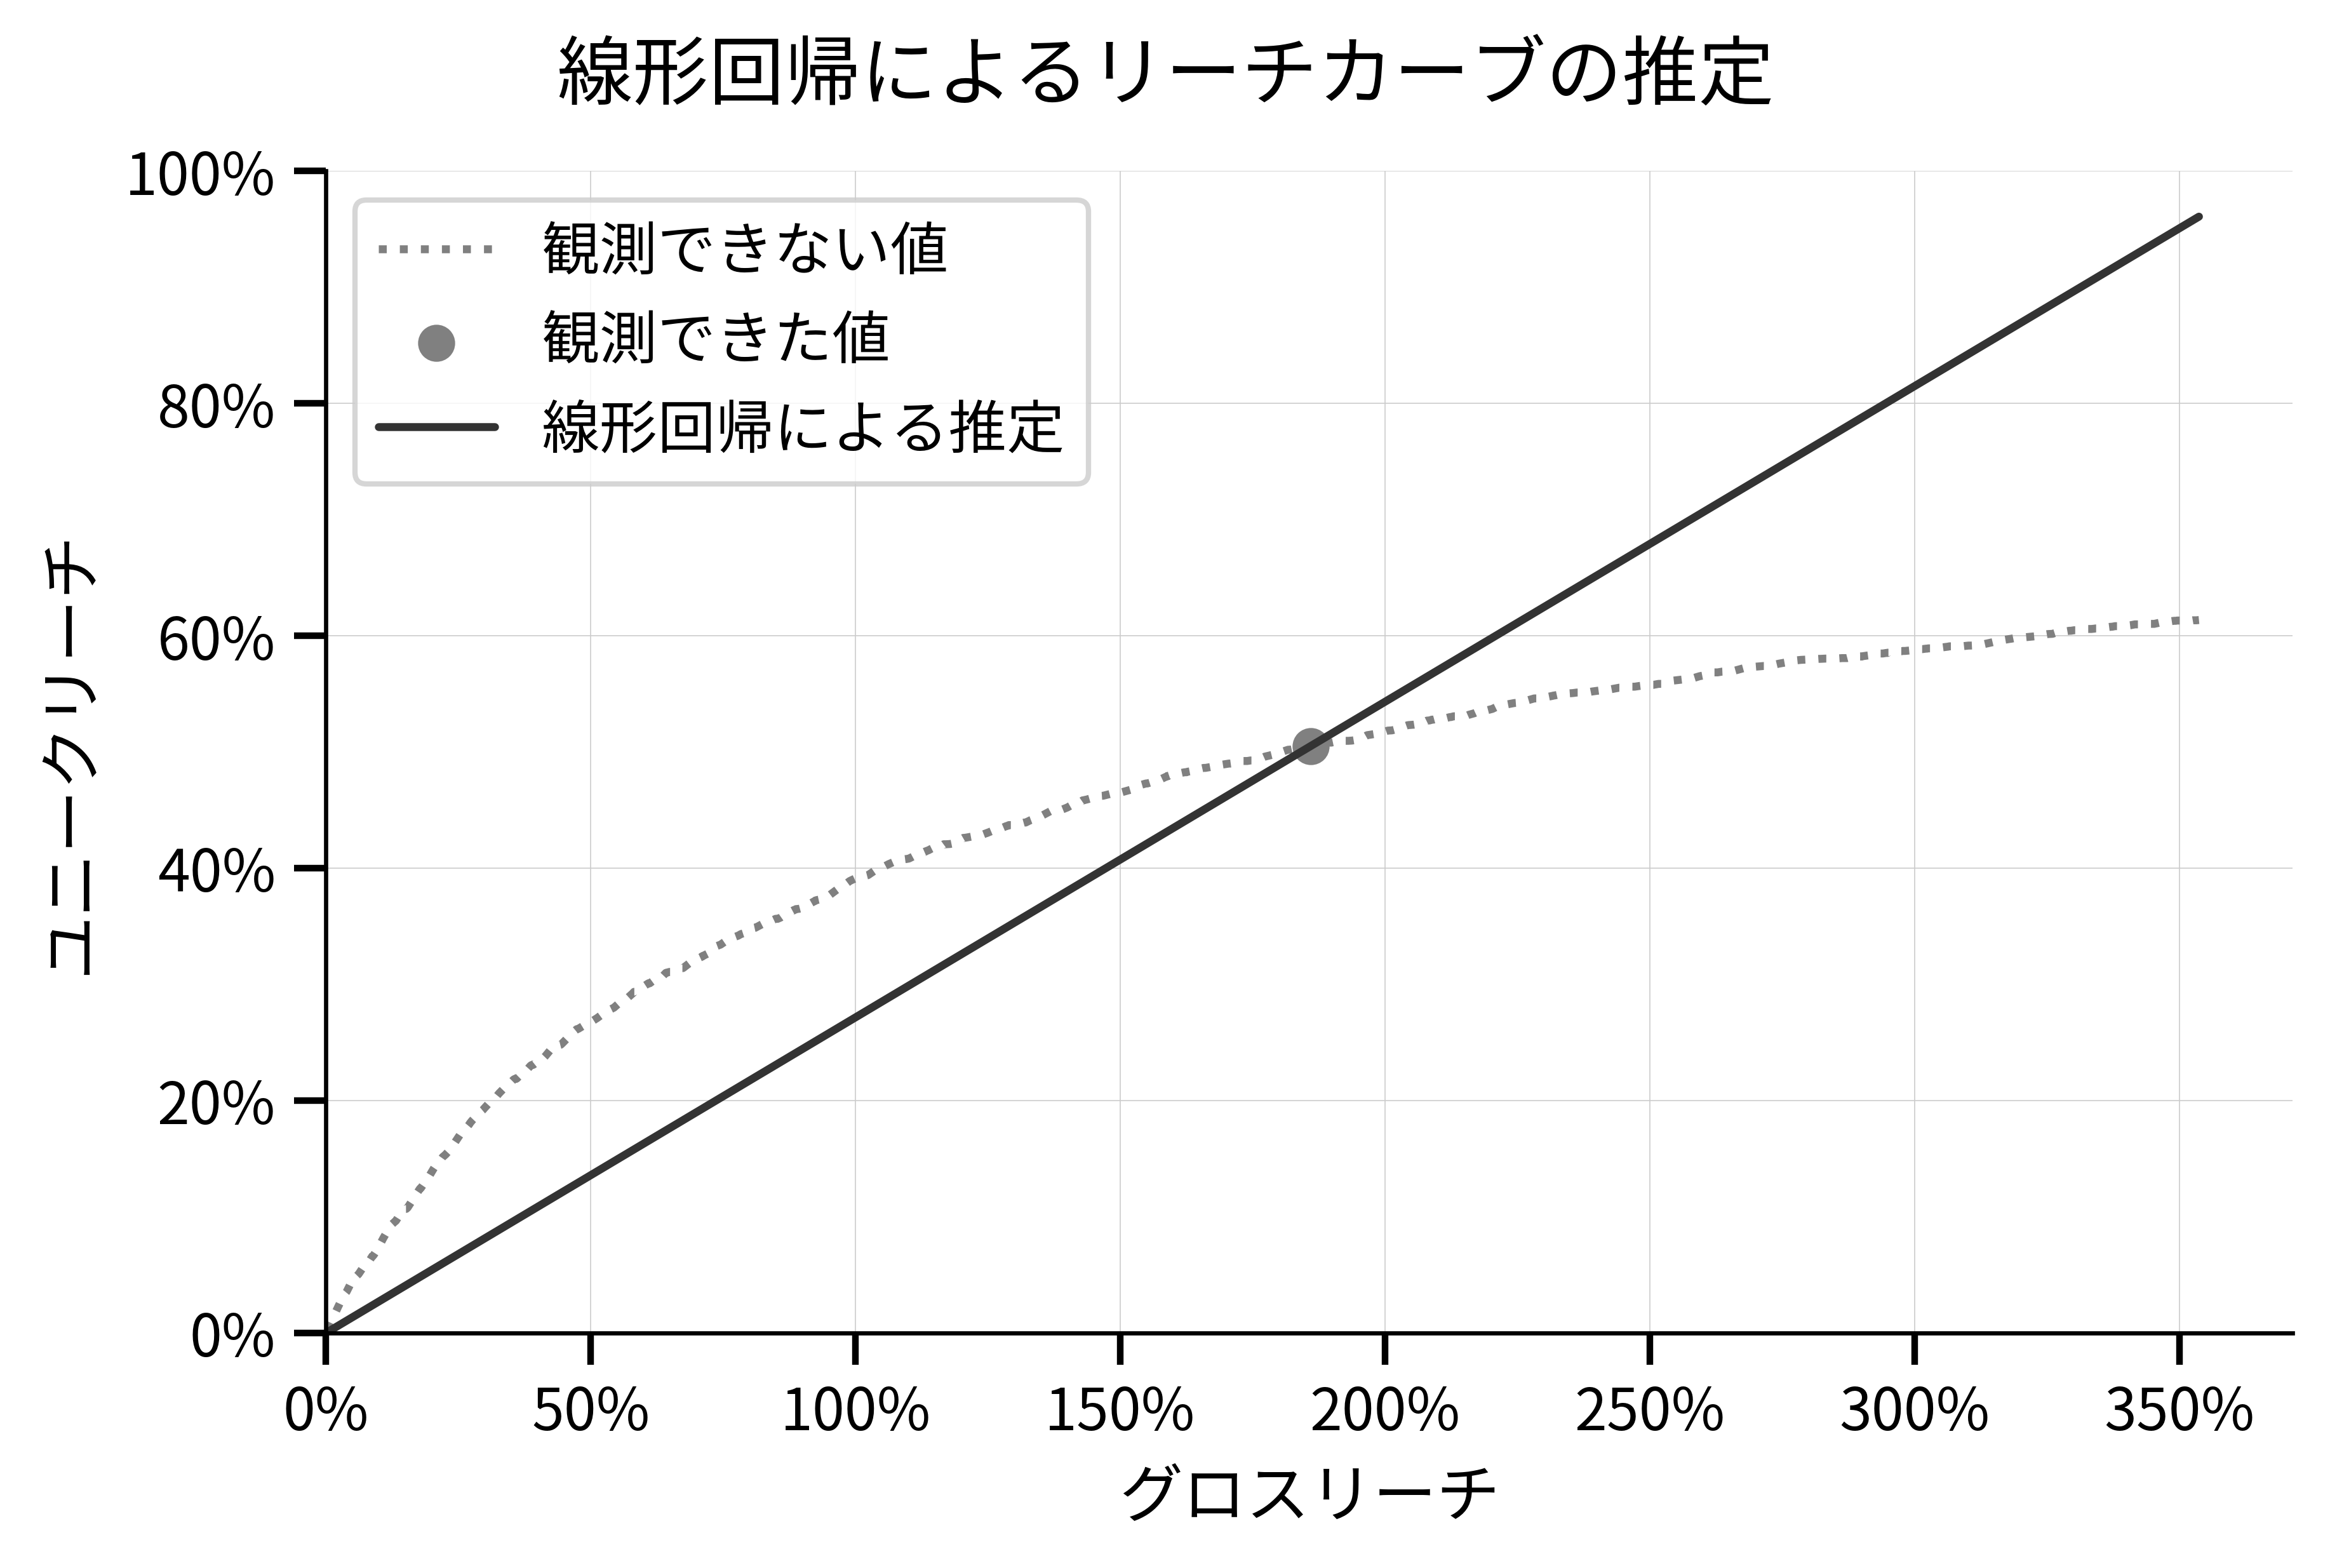

In [11]:
fig, ax = plot_reach_curve_with_prediction(
    df_reach=df_reach,
    df_reach_observed=df_reach_observed,
    r_pred=r_pred_linear,
    prediction_label="線形回帰による推定",
    title="線形回帰によるリーチカーブの推定",
)

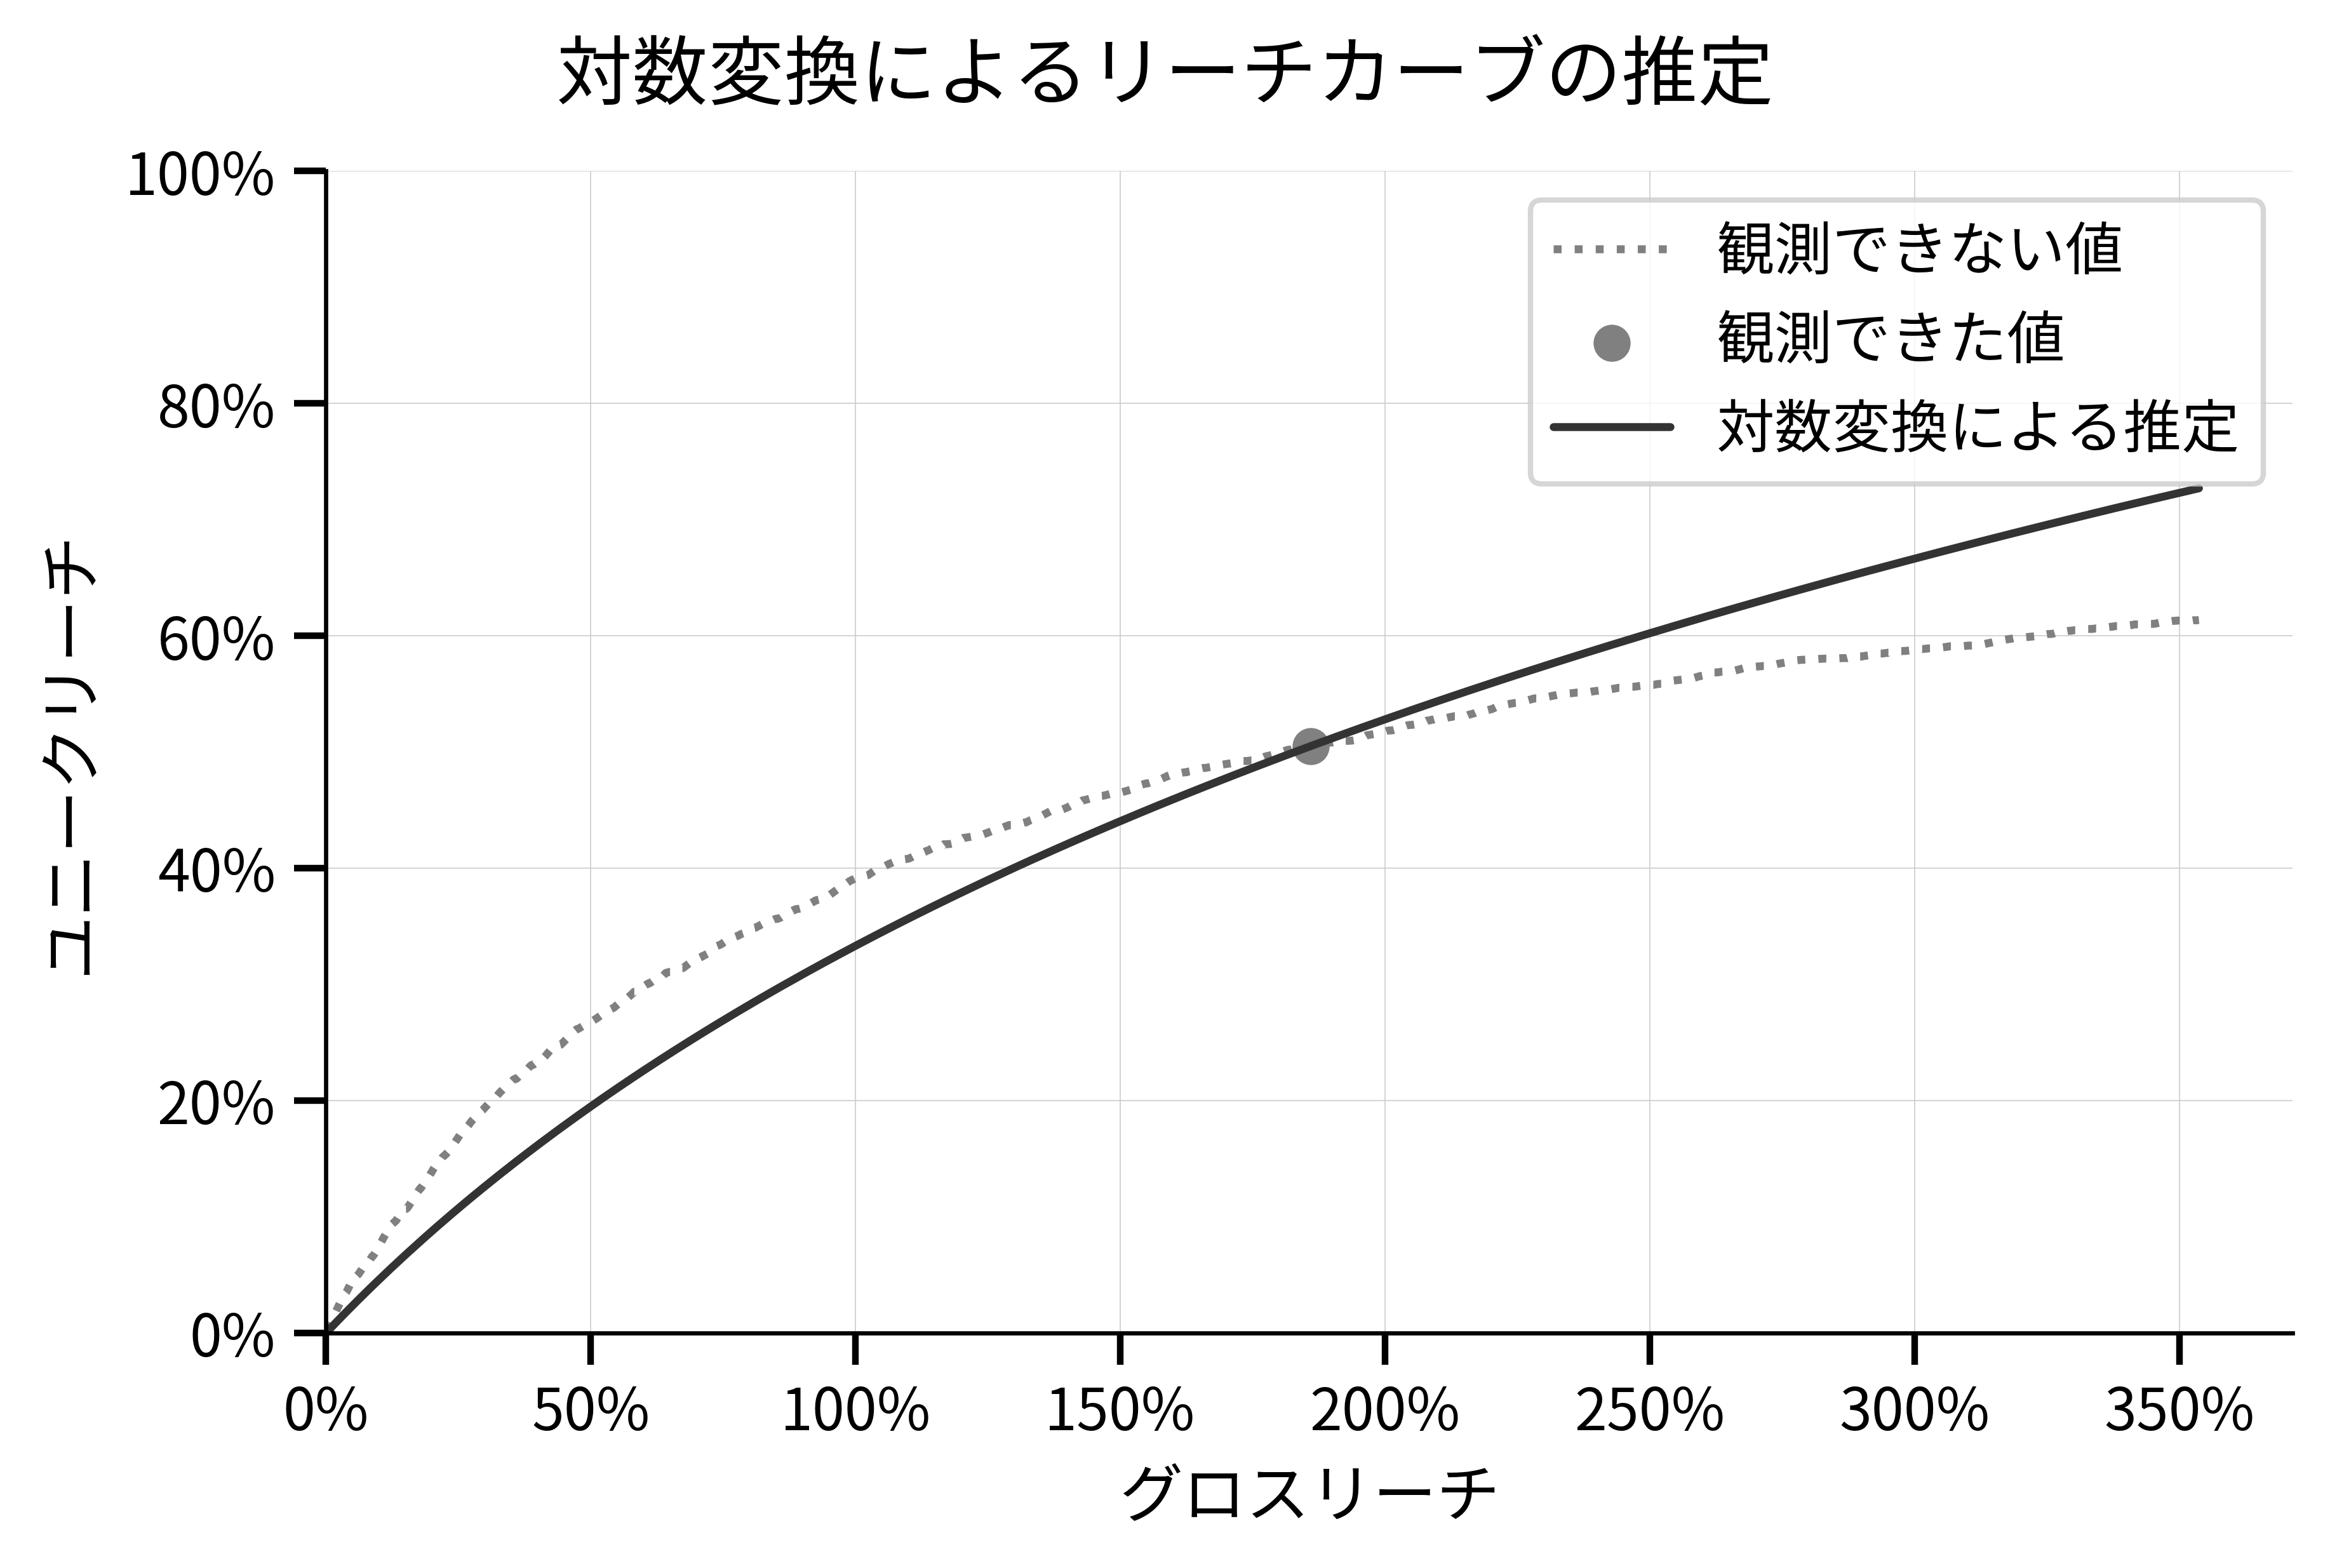

In [12]:
# 対数変換した場合のリーチカーブの推定
lr_log = LinearRegression(fit_intercept=False)  # 切片を0に固定
lr_log.fit(np.log1p(g_train), r_train)  # log1p(x) = log(x + 1)
r_pred_log = lr_log.predict(np.log1p(g_test))  # リーチカーブの推定

# 対数変換で推定したリーチカーブの可視化
fig, ax = plot_reach_curve_with_prediction(
    df_reach=df_reach,
    df_reach_observed=df_reach_observed,
    r_pred=r_pred_log,
    prediction_label="対数変換による推定",
    title="対数変換によるリーチカーブの推定",
)

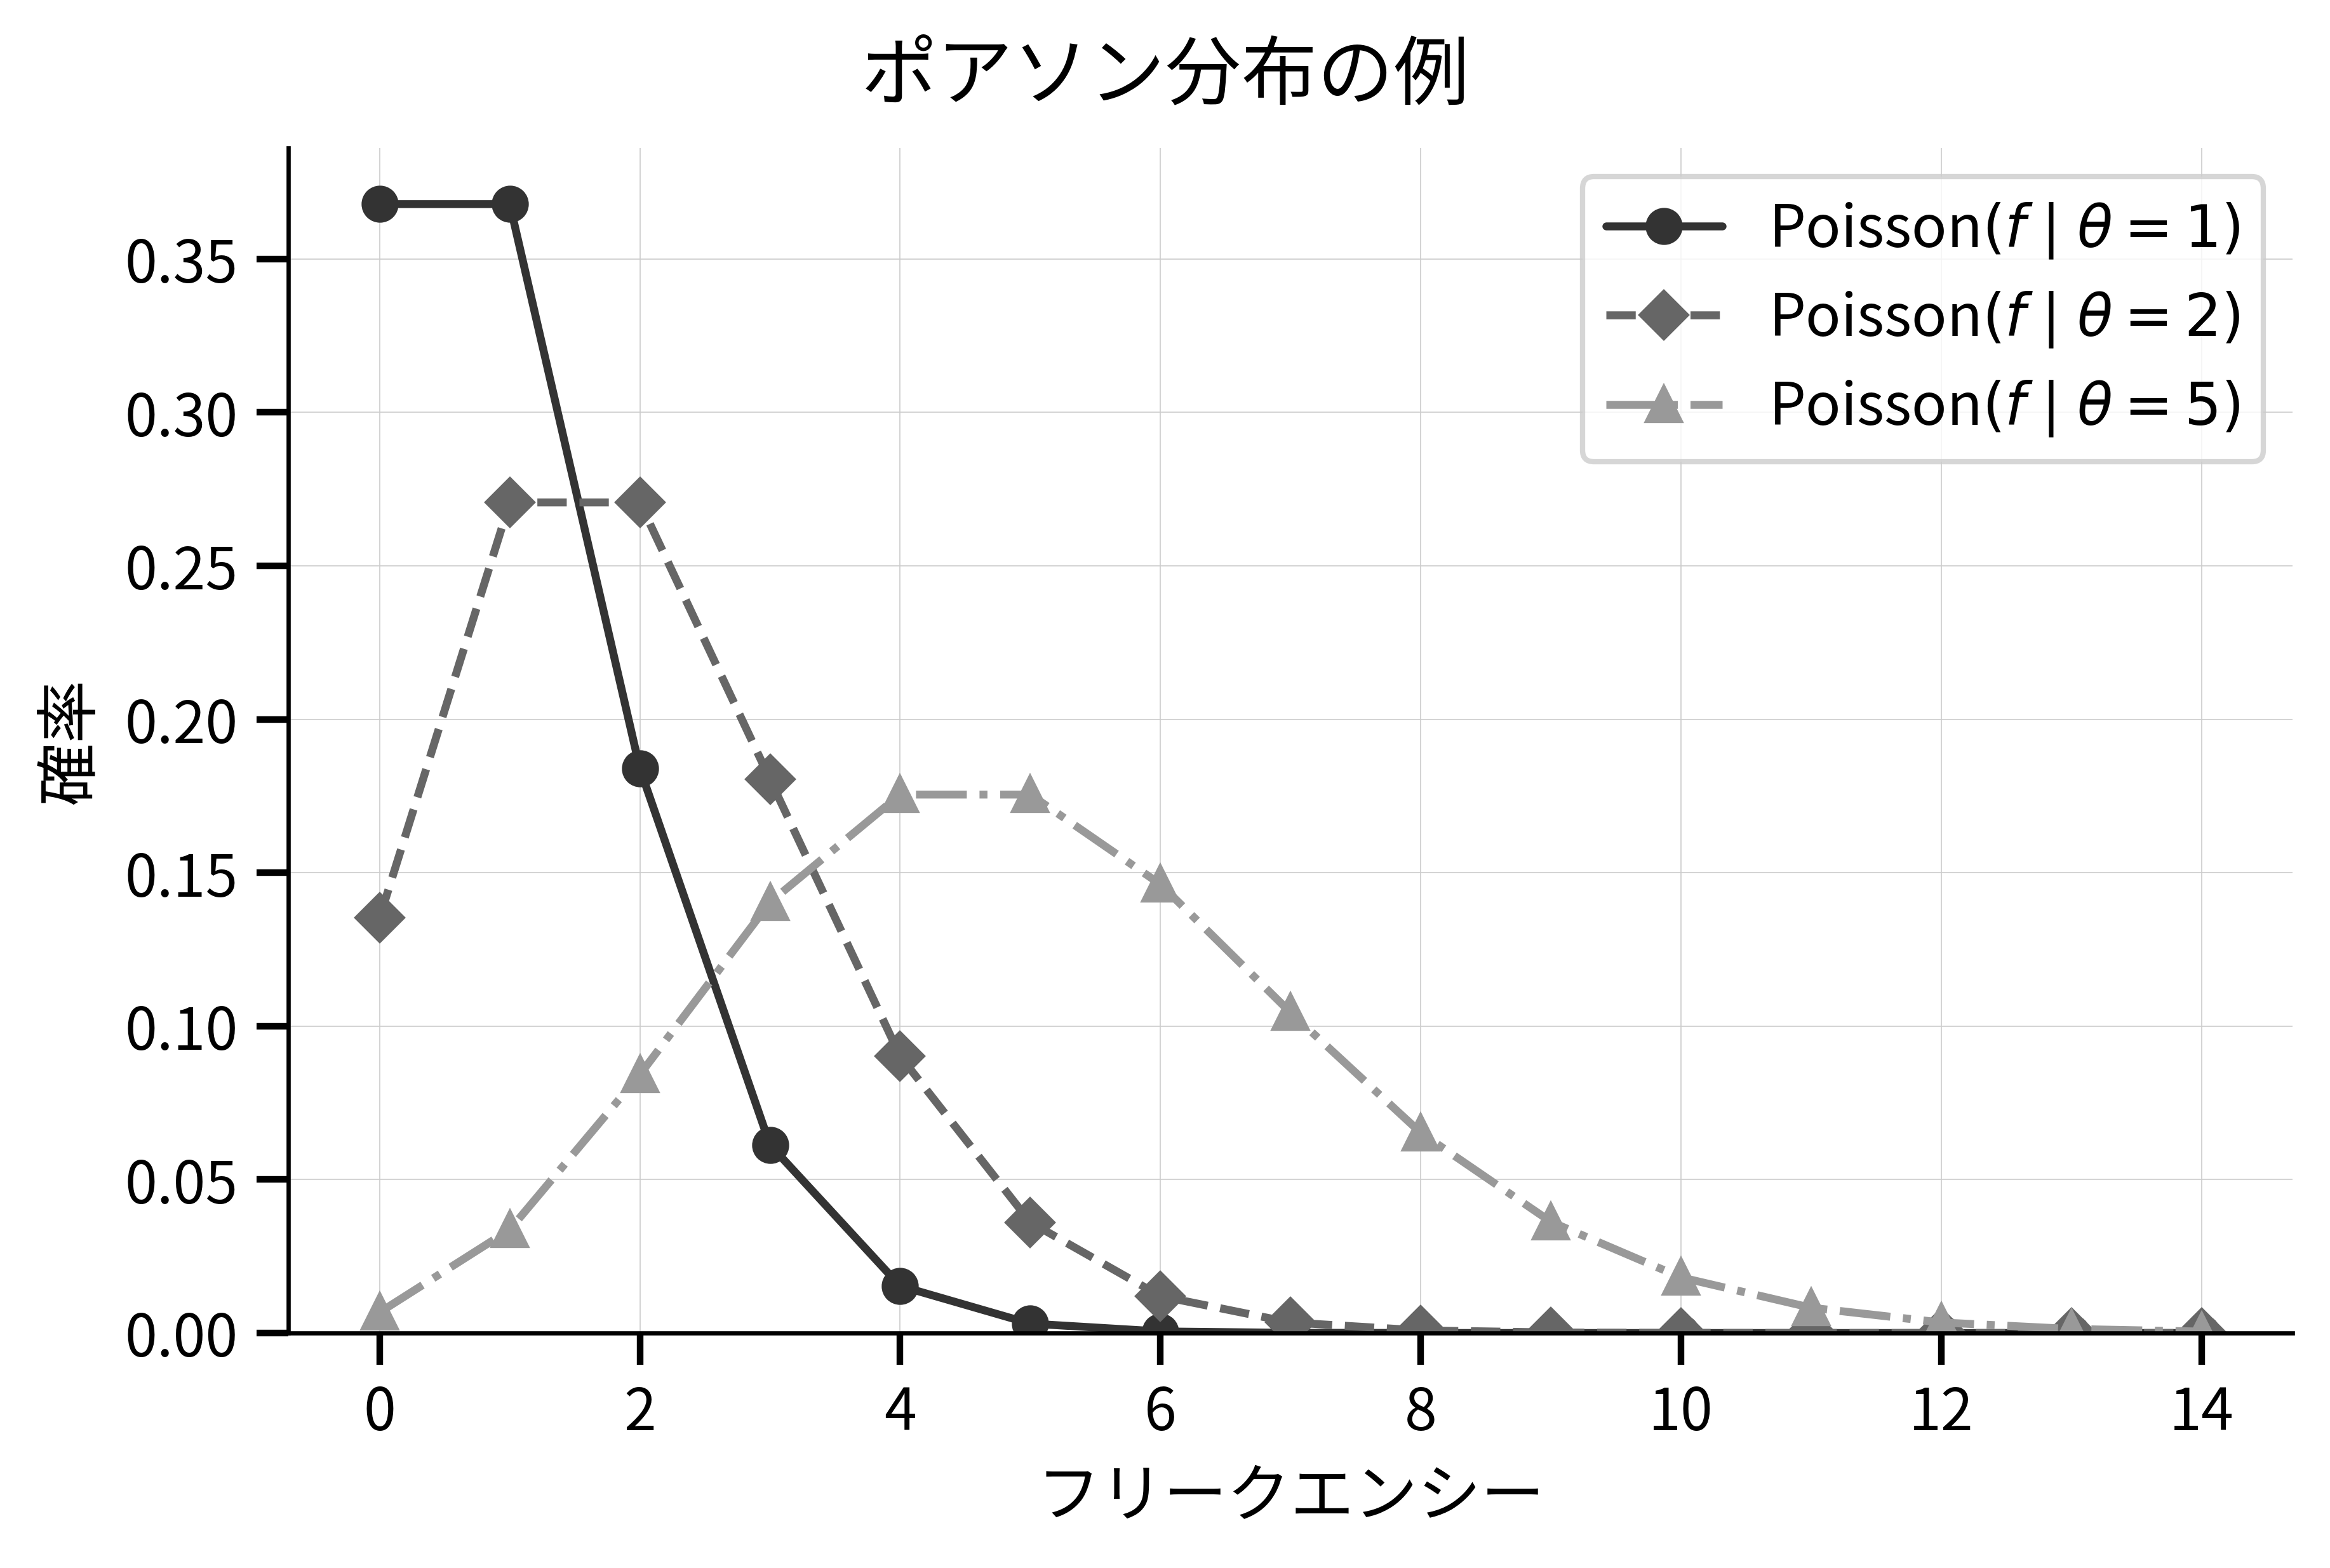

In [13]:
from scipy.stats import poisson


def plot_poisson(f: np.ndarray, theta_list: list[float]) -> tuple[Figure, Axes]:
    """ポアソン分布を可視化"""

    fig, ax = plt.subplots()

    markers = ["o", "D", "^", "x"]
    linestyles = ["solid", "dashed", "dashdot", "dotted"]
    for i, theta in enumerate(theta_list):
        y = poisson.pmf(k=f, mu=theta)  # ポアソン分布をの確率質量関数
        ax.plot(
            f,
            y,
            marker=markers[i % len(markers)],
            linestyle=linestyles[i % len(linestyles)],
            label=f"Poisson$(f \\mid \\theta = {theta})$",
        )

    ax.legend()
    ax.set_ylim(0, None)
    ax.set_xlabel("フリークエンシー")
    ax.set_ylabel("確率")
    fig.suptitle("ポアソン分布の例")

    return fig, ax


# ポアソン分布の可視化
fig, ax = plot_poisson(f=np.arange(15), theta_list=[1, 2, 5])

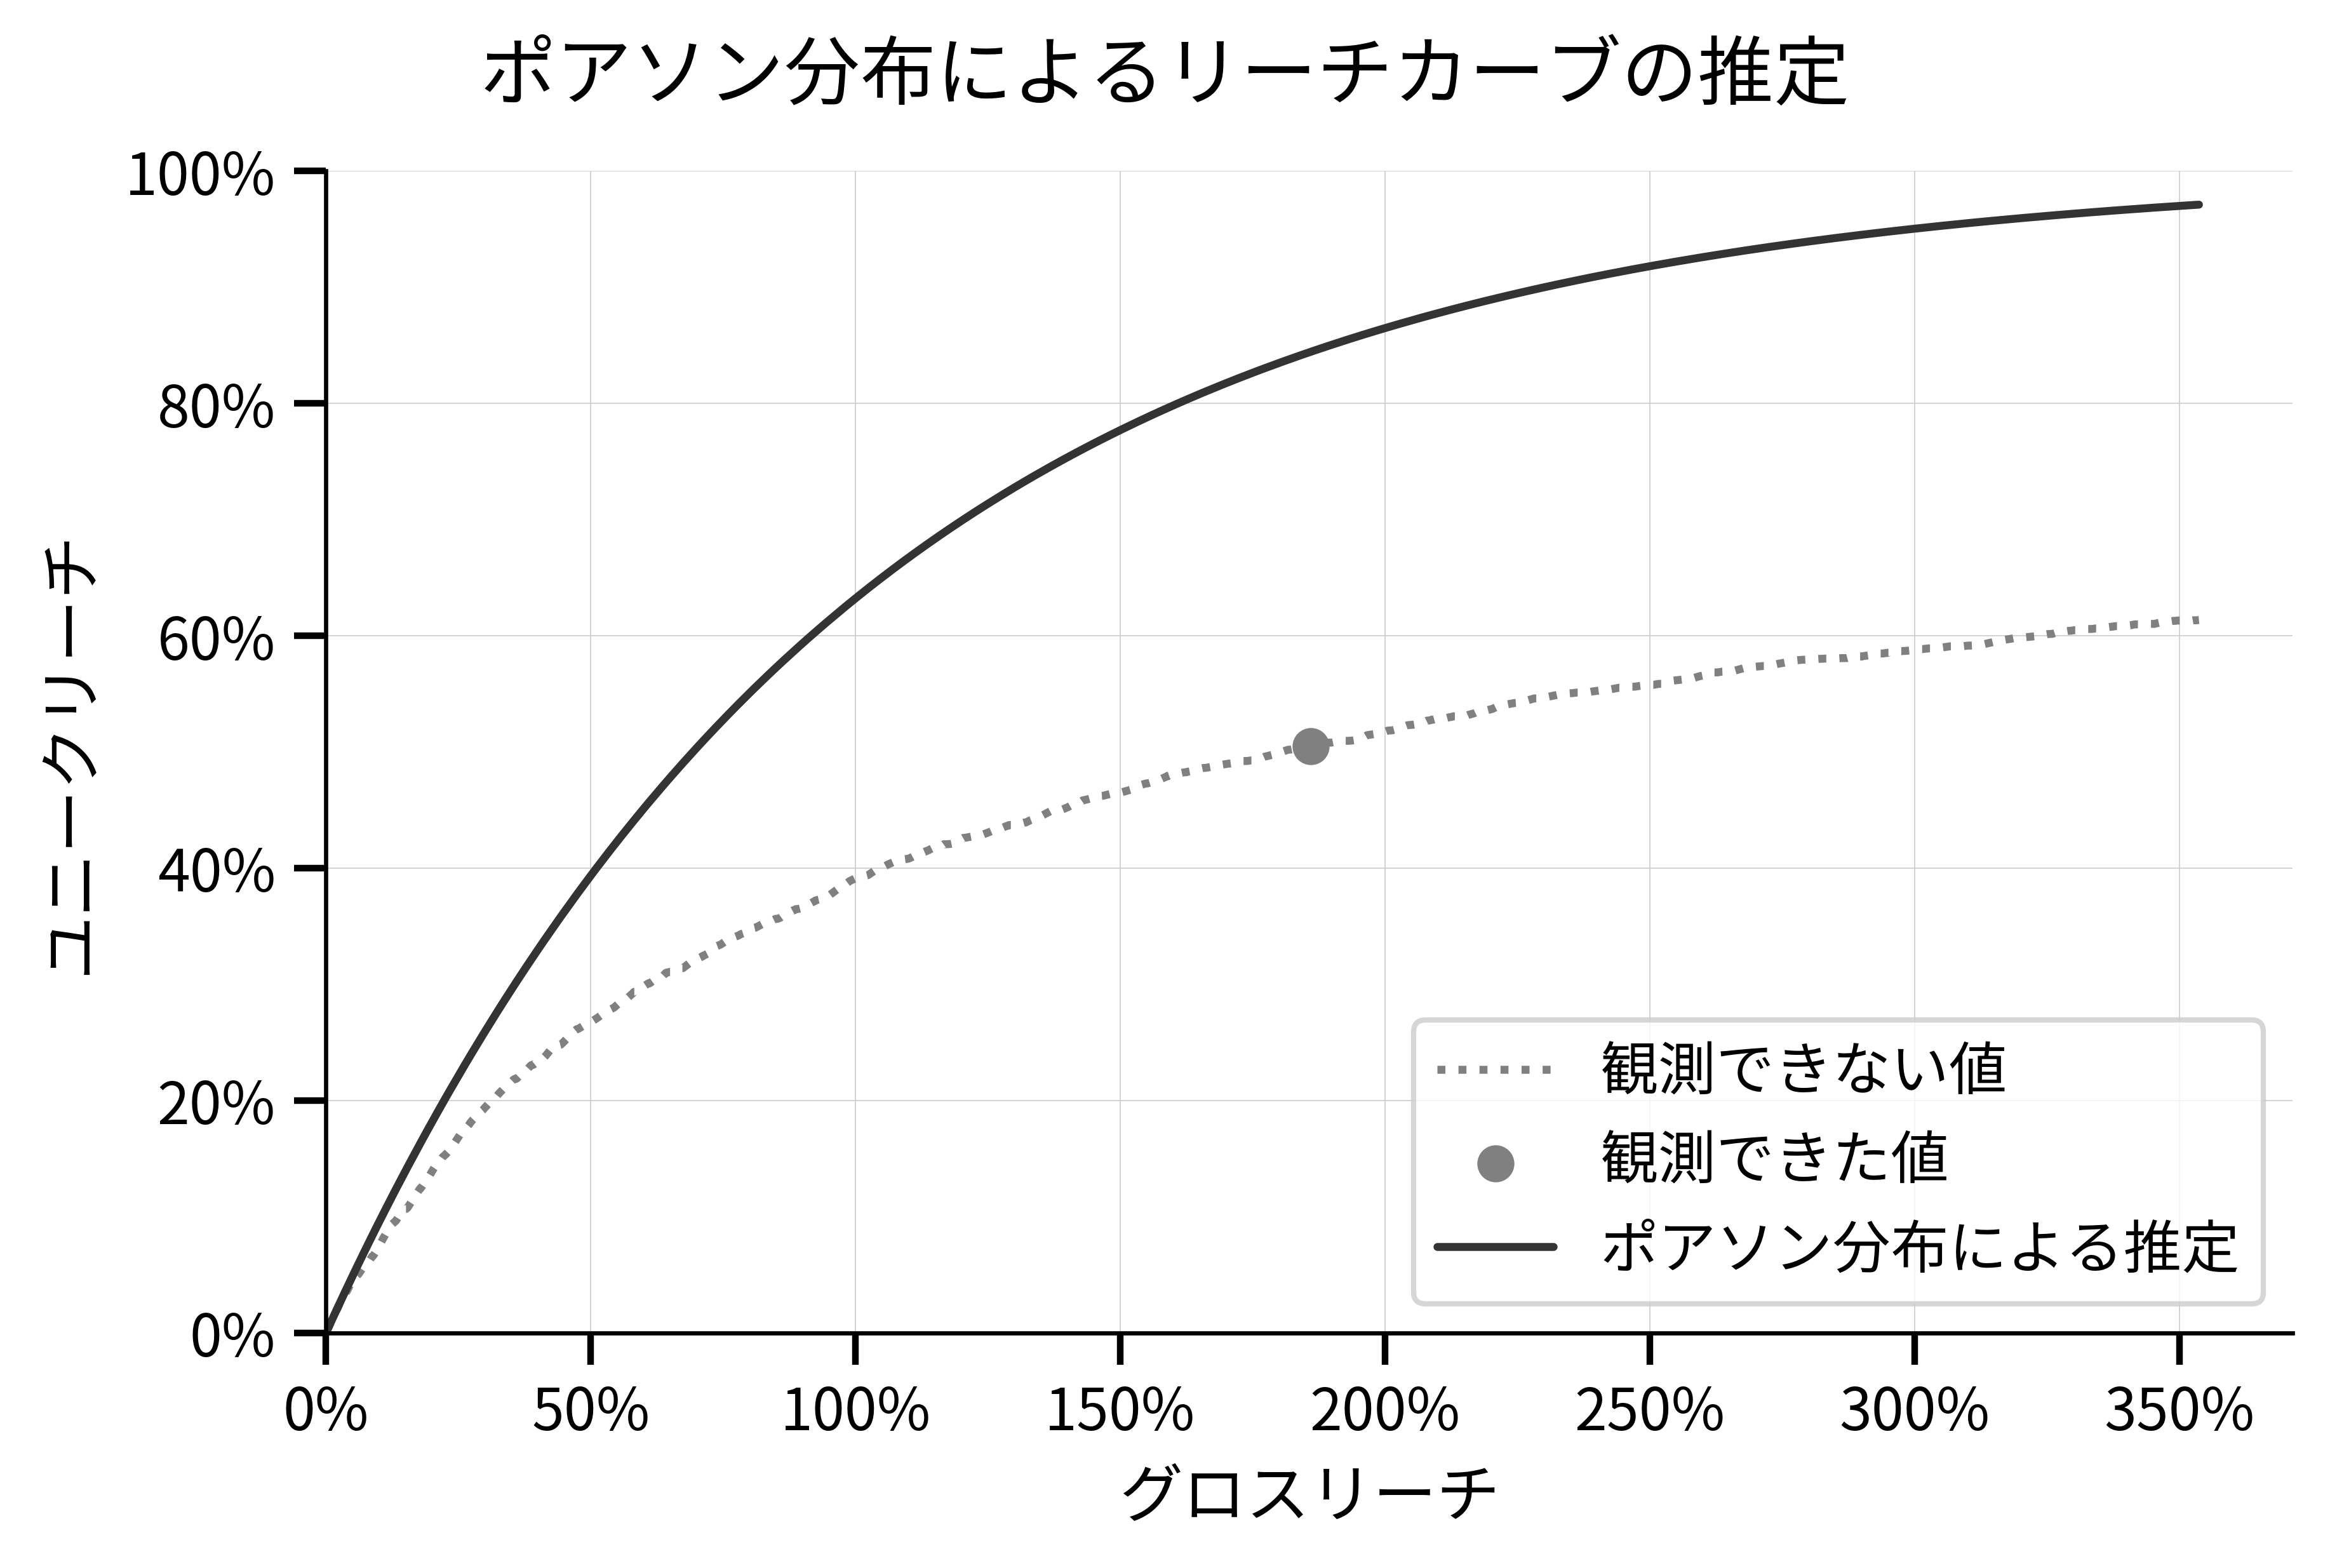

In [14]:
def predict_reach_poisson(
    g: np.ndarray | pl.Series,
) -> np.ndarray:
    """ポアソン分布を仮定したリーチカーブ"""

    # 100%から非接触率を引いたものがユニークリーチ
    return 1 - poisson.pmf(k=0, mu=g)


# リーチカーブを計算
r_pred_poisson = predict_reach_poisson(g=df_reach["g"])

# 可視化
fig, ax = plot_reach_curve_with_prediction(
    df_reach=df_reach,
    df_reach_observed=df_reach_observed,
    r_pred=r_pred_poisson,
    prediction_label="ポアソン分布による推定",
    title="ポアソン分布によるリーチカーブの推定",
)

In [15]:
# 調査時点のCM接触回数の分布を読み込む
df_frequency_observed = pl.read_csv("../data/ch02/frequency_observed.csv")
df_frequency_observed

shape: (61, 4)
┌─────┬───────┬─────┬───────┐
│ t   ┆ g     ┆ f   ┆ prop  │
│ --- ┆ ---   ┆ --- ┆ ---   │
│ i64 ┆ f64   ┆ i64 ┆ f64   │
╞═════╪═══════╪═════╪═══════╡
│ 600 ┆ 1.859 ┆ 0   ┆ 0.495 │
│ 600 ┆ 1.859 ┆ 1   ┆ 0.180 │
│ 600 ┆ 1.859 ┆ 2   ┆ 0.098 │
│ 600 ┆ 1.859 ┆ 3   ┆ 0.064 │
│ 600 ┆ 1.859 ┆ 4   ┆ 0.039 │
│ …   ┆ …     ┆ …   ┆ …     │
│ 600 ┆ 1.859 ┆ 56  ┆ 0.000 │
│ 600 ┆ 1.859 ┆ 57  ┆ 0.000 │
│ 600 ┆ 1.859 ┆ 58  ┆ 0.000 │
│ 600 ┆ 1.859 ┆ 59  ┆ 0.000 │
│ 600 ┆ 1.859 ┆ 60  ┆ 0.000 │
└─────┴───────┴─────┴───────┘

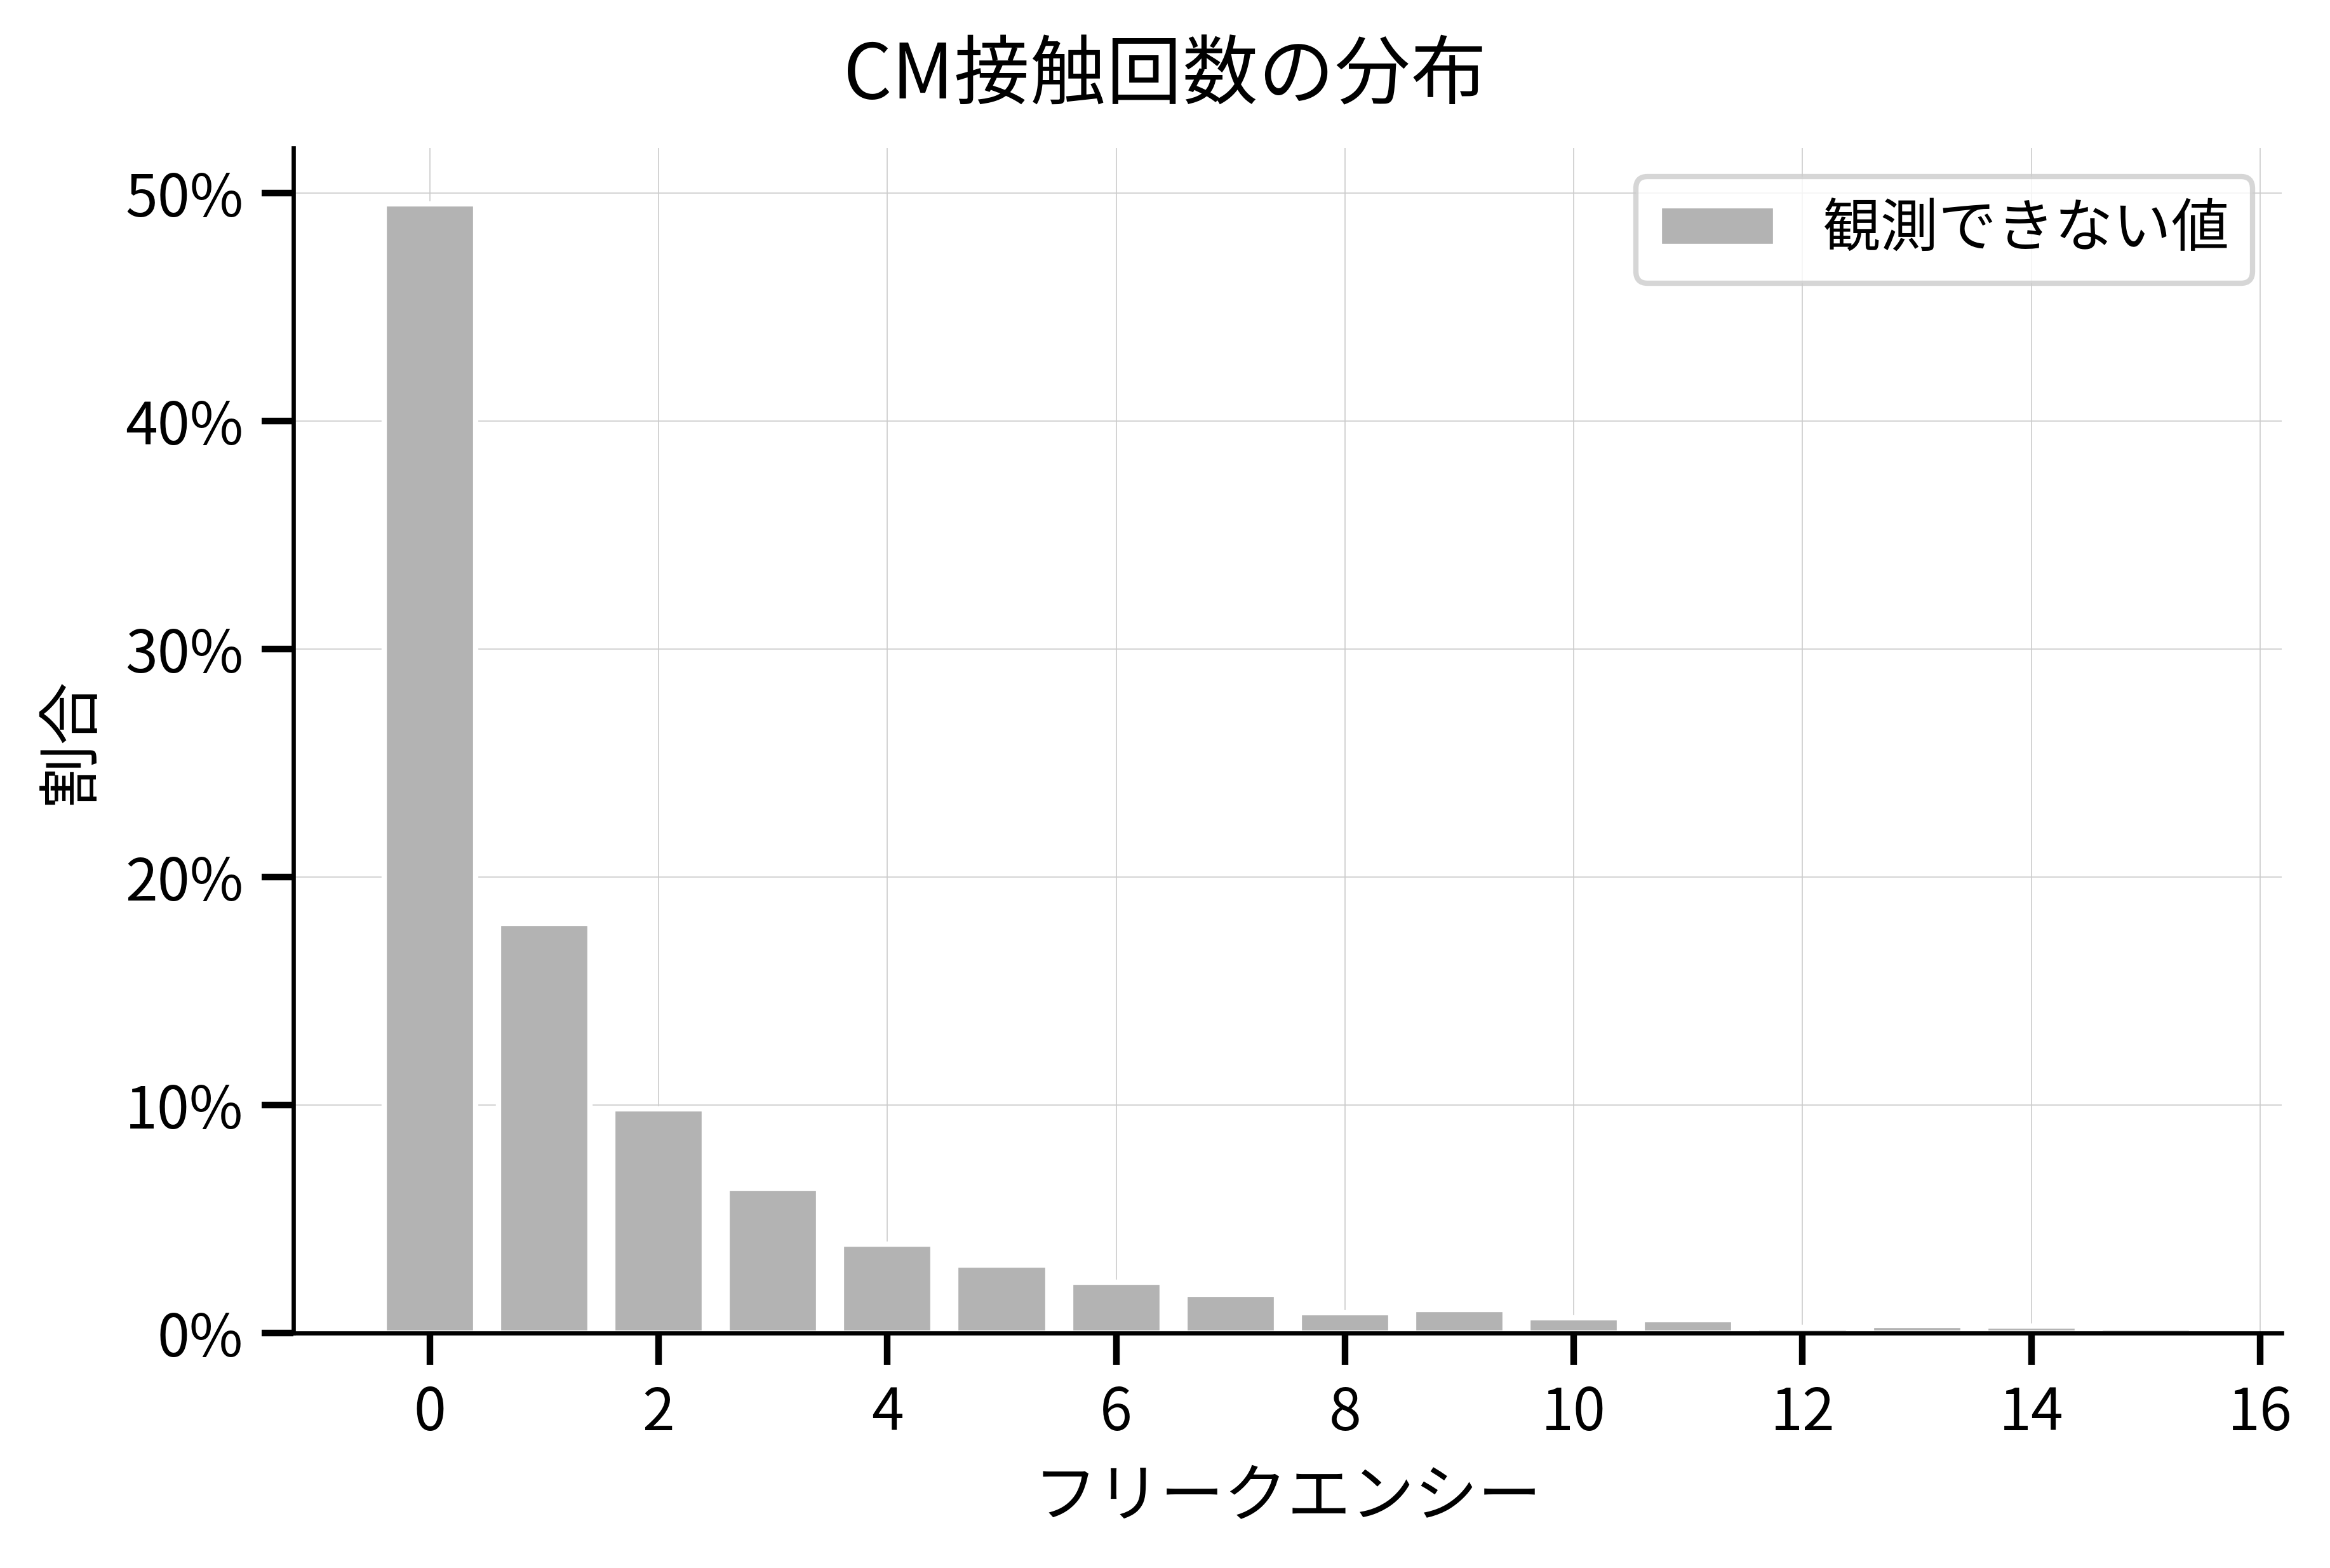

In [16]:
def plot_histogram(
    df_frequency_observed: pl.DataFrame, f_max: int, title: str
) -> tuple[Figure, Axes]:
    """CM接触回数の分布を可視化"""

    # 横に長くなりすぎるとうまく可視化できないで、
    # 必要であればf_max以下のデータのみを使う
    df_to_use = df_frequency_observed.filter(pl.col.f <= f_max)
    fig, ax = plt.subplots()

    ax.bar(
        df_to_use["f"],
        df_to_use["prop"],
        label="観測できない値",
        color="0.7",
    )
    ax.legend()
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_xlabel("フリークエンシー")
    ax.set_ylabel("割合")
    fig.suptitle(title)

    return fig, ax


# フリークエンシーの分布を可視化
f_max = 15
fig, ax = plot_histogram(
    df_frequency_observed=df_frequency_observed,
    f_max=f_max,
    title="CM接触回数の分布",
)

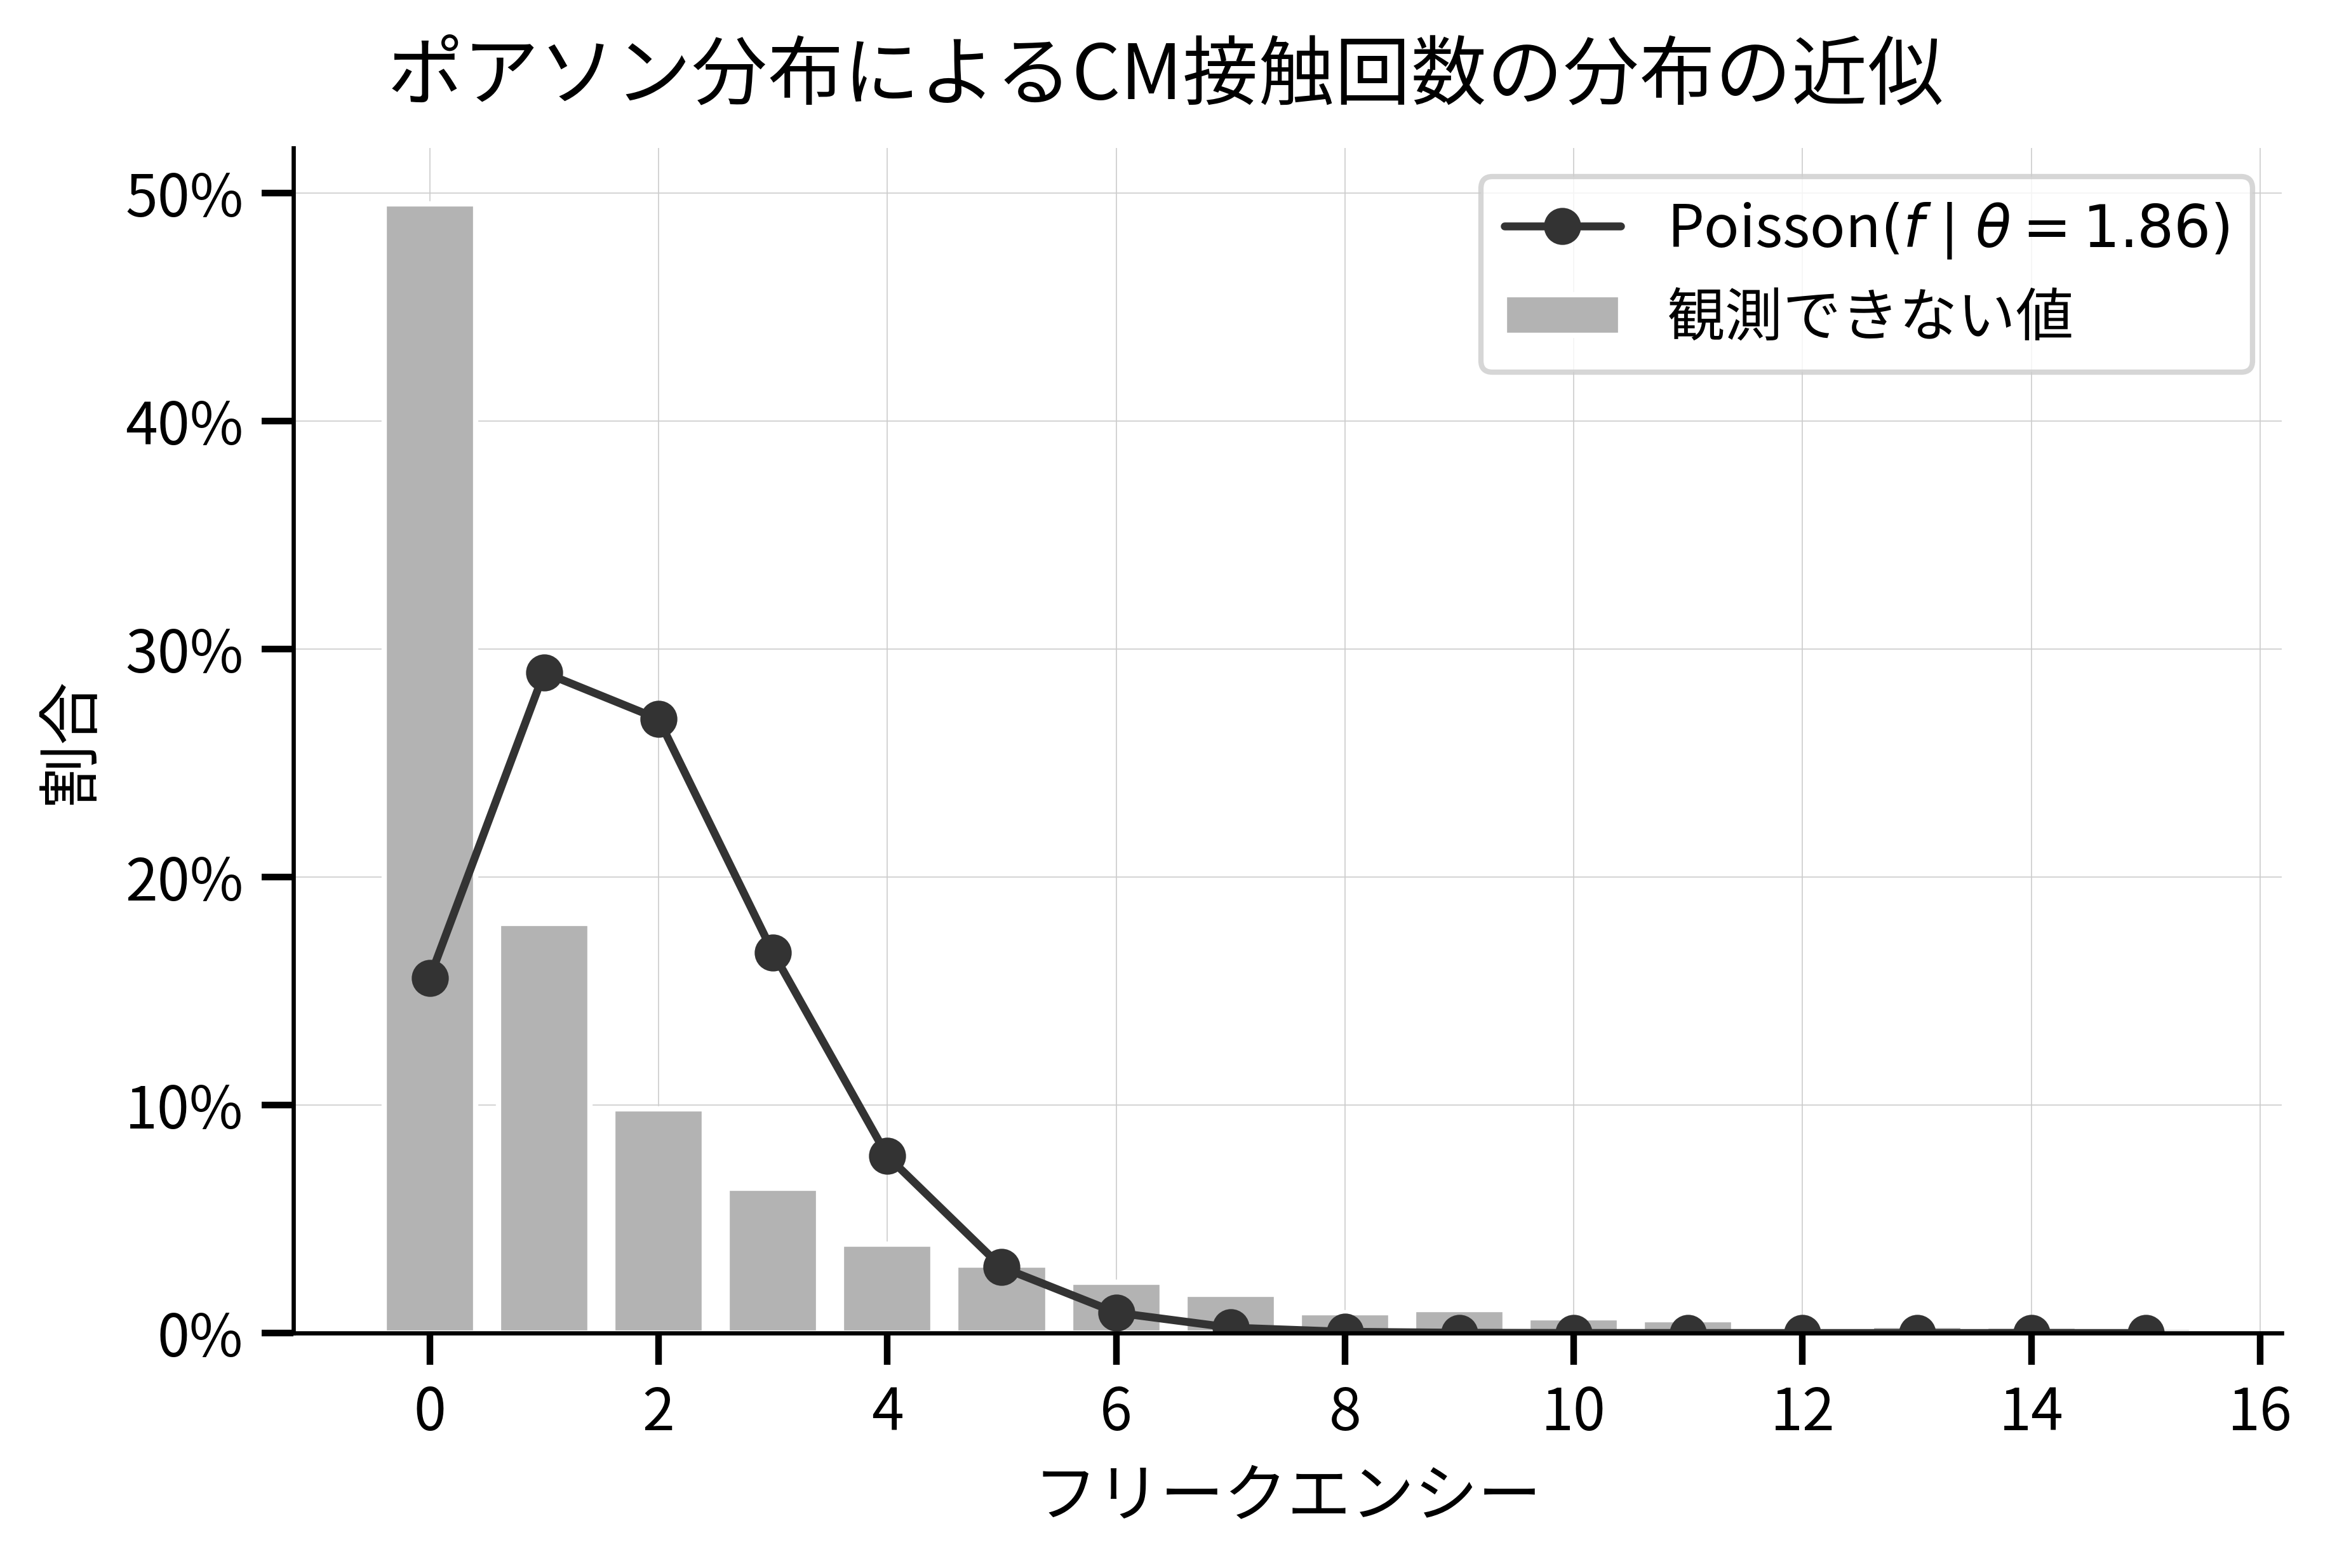

In [17]:
def plot_histogram_with_distribution(
    df_frequency_observed: pl.DataFrame,
    prop_pred: np.ndarray,
    prop_label: str,
    f_max: int,
    title: str,
) -> tuple[Figure, Axes]:
    """CM接触回数の分布と、近似する分布を重ね合わせて可視化"""

    fig, ax = plot_histogram(df_frequency_observed, f_max, title)
    ax.plot(
        range(f_max + 1),
        prop_pred,
        marker="o",
        label=prop_label,
    )  # 近似する分布を追加
    ax.legend()

    return fig, ax


# ポアソン分布を仮定したCM接触回数の分布。期待値は調査時点のグロスリーチを指定
prop_poisson = poisson.pmf(k=range(f_max + 1), mu=df_reach_observed["g"])

# CM接触回数分布とポアソン分布を重ね合あわせて可視化
fig, ax = plot_histogram_with_distribution(
    df_frequency_observed=df_frequency_observed,
    prop_pred=prop_poisson,
    prop_label=f"Poisson$(f \\mid \\theta = {df_reach_observed["g"].item(): .2f})$",
    f_max=f_max,
    title="ポアソン分布によるCM接触回数の分布の近似",
)

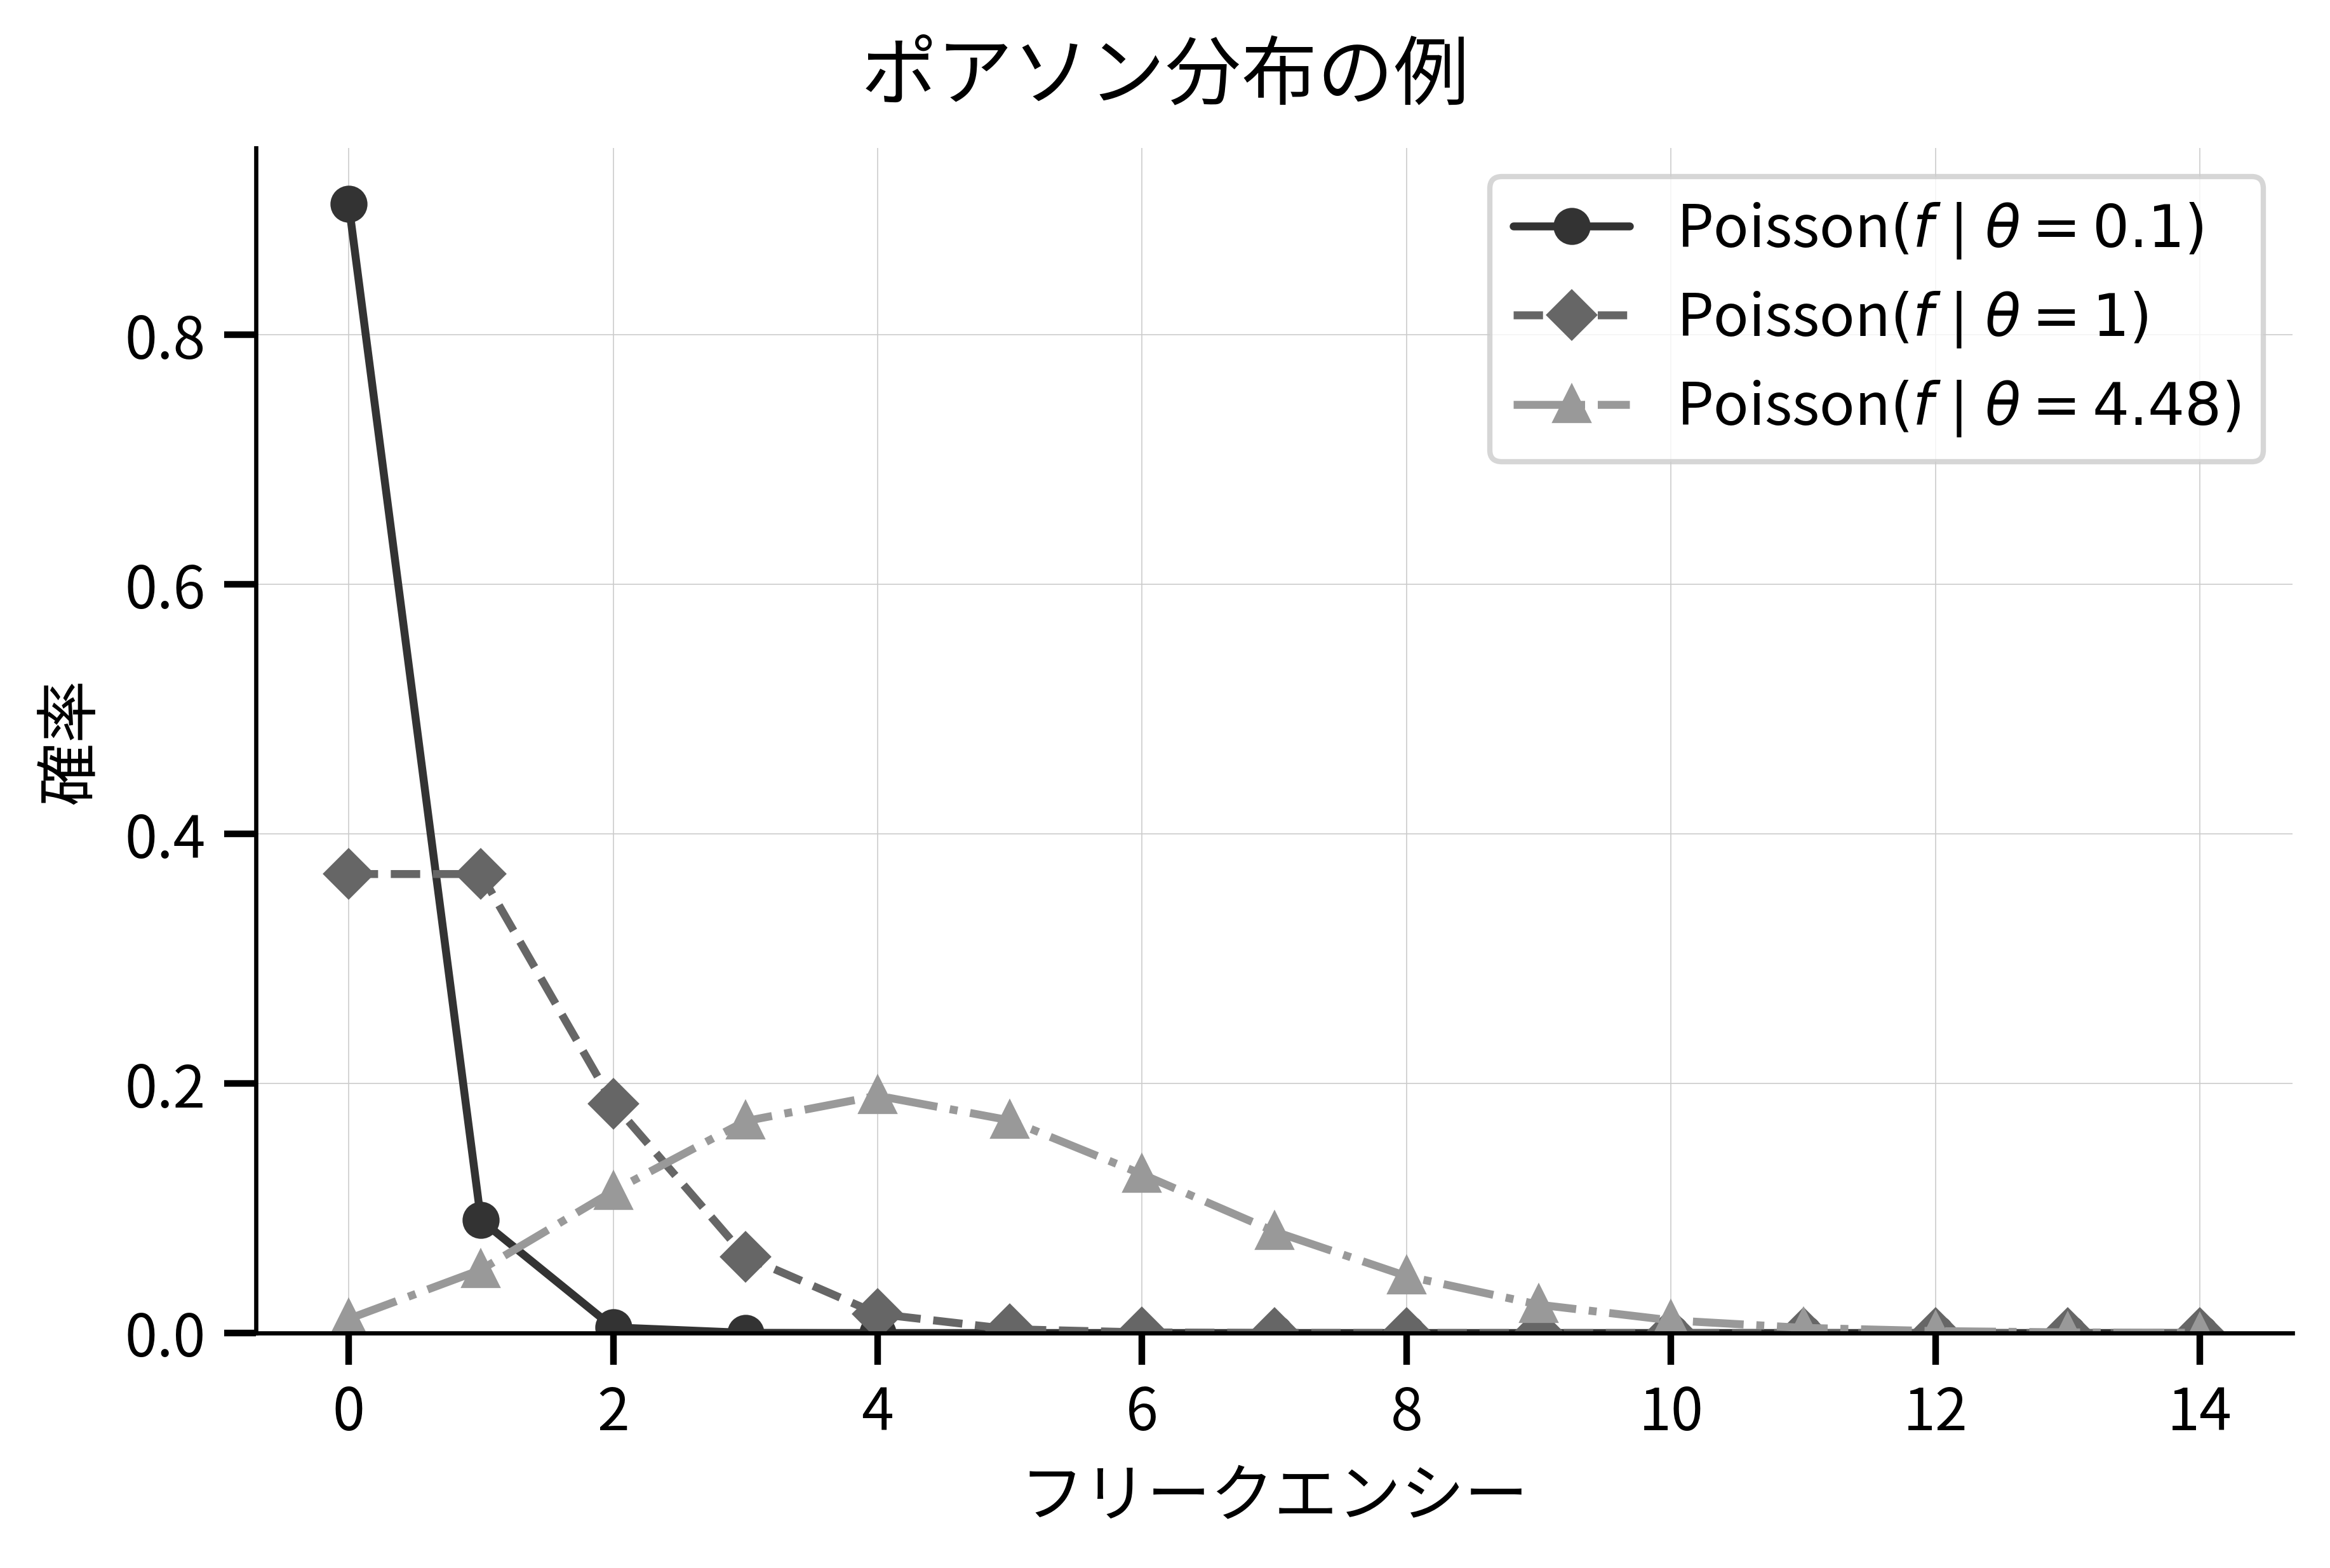

In [18]:
# パラメータの異なるポアソン分布を可視化
theta_list = [0.1, 1, 4.48]  # パラメータのリスト
fig, ax = plot_poisson(f=np.arange(15), theta_list=theta_list)

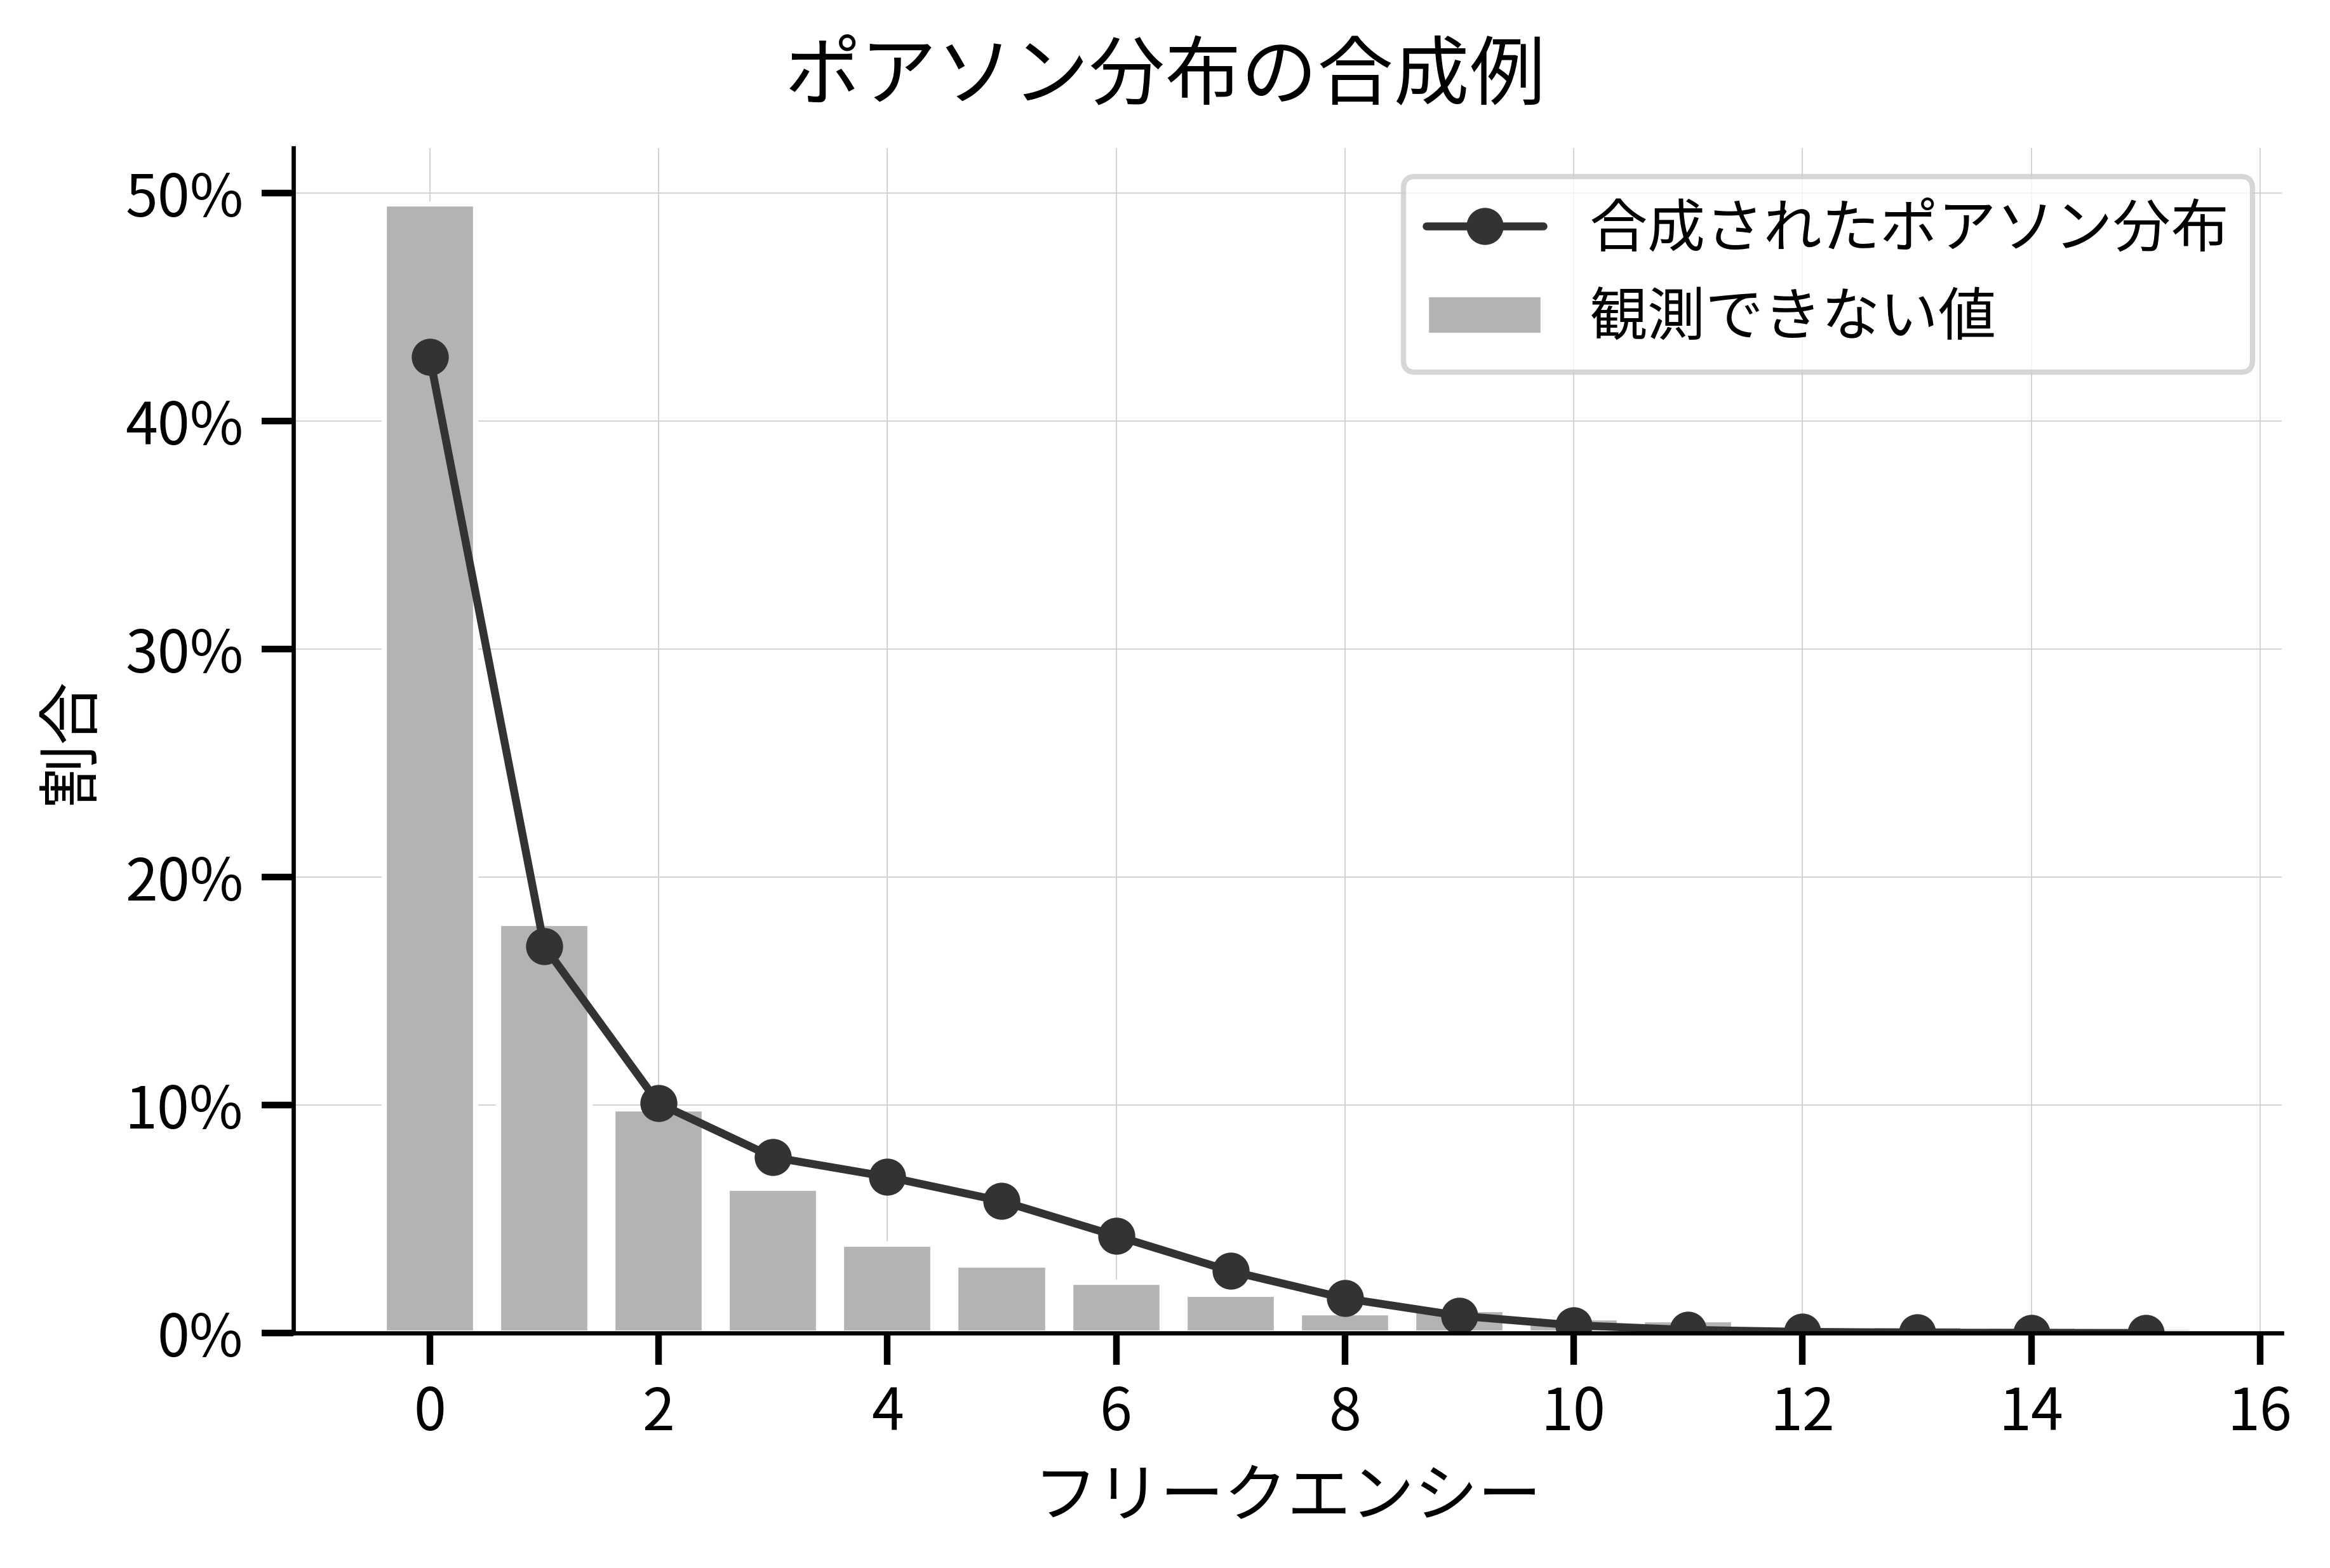

In [19]:
# ポアソン分布を合成。接触回数ごとに確率の平均をとればいい
prop_mixed = np.zeros(f_max + 1)
for theta in theta_list:
    prop_mixed += poisson.pmf(k=np.arange(f_max + 1), mu=theta) / len(theta_list)

# 合成された分布を可視化
fig, ax = fig, ax = plot_histogram_with_distribution(
    df_frequency_observed=df_frequency_observed,
    prop_pred=prop_mixed,
    prop_label="合成されたポアソン分布",
    f_max=f_max,
    title="ポアソン分布の合成例",
)

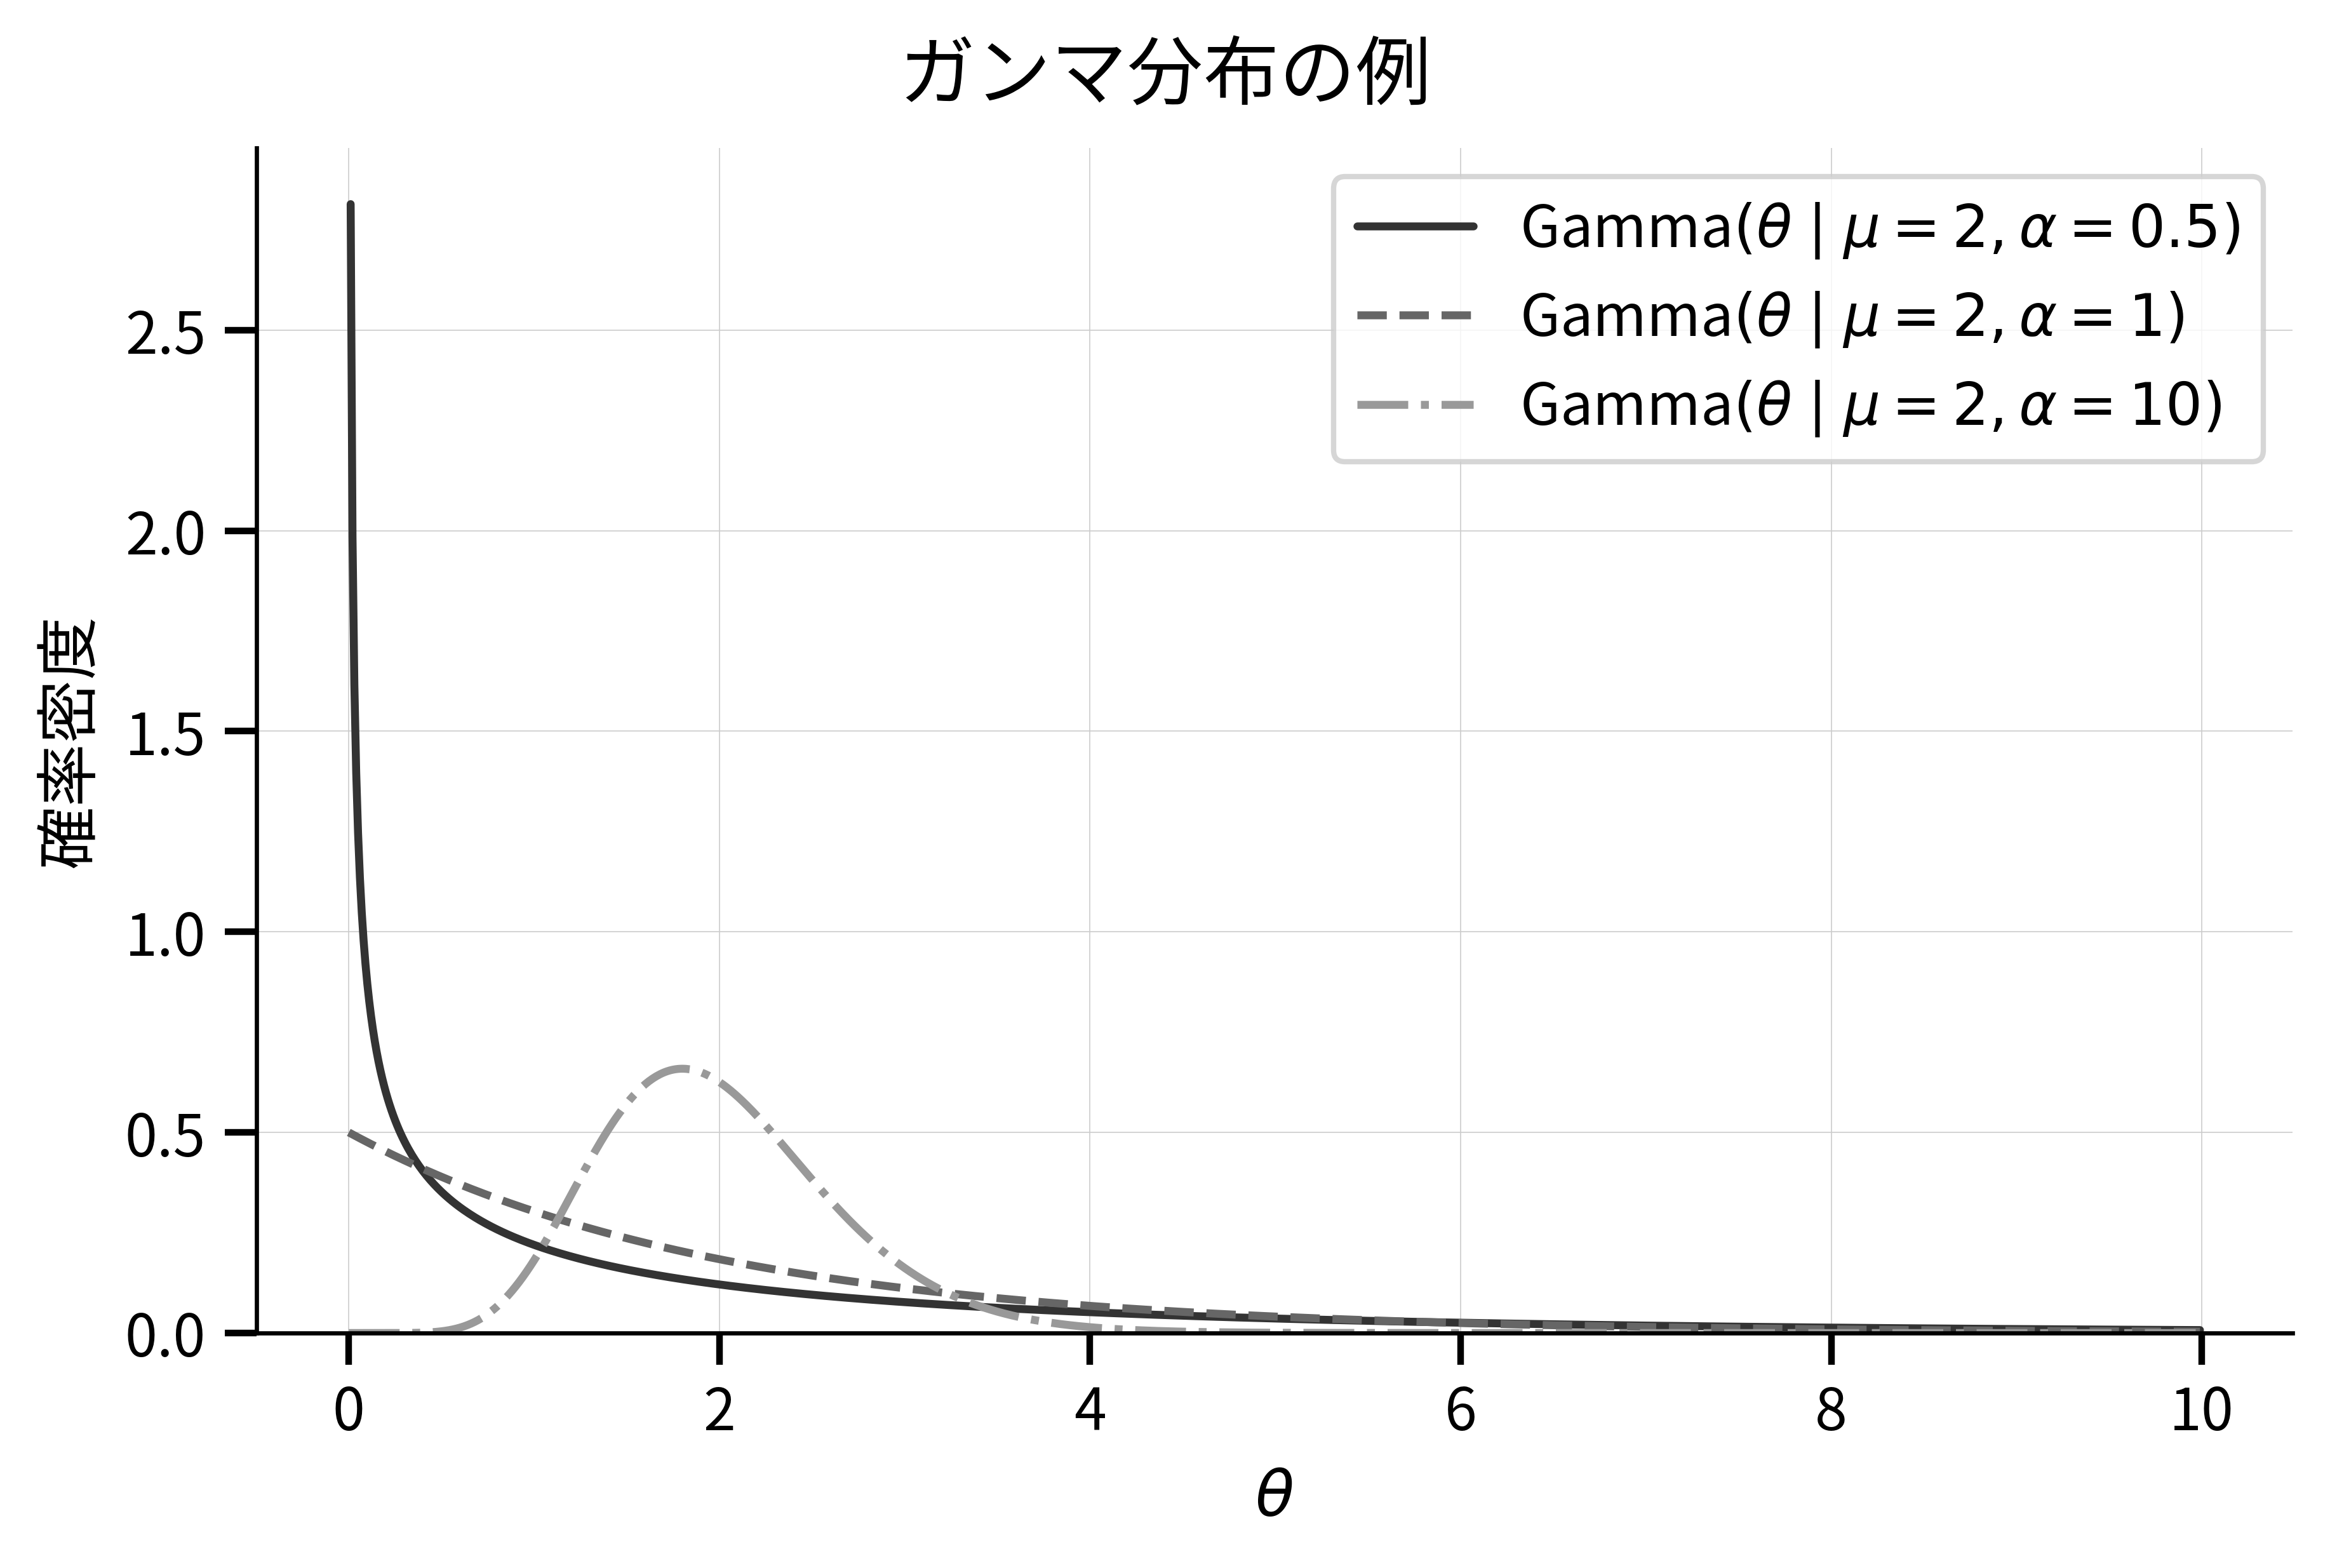

In [20]:
from scipy.stats import gamma


def plot_gamma(
    theta: np.ndarray,
    mu_list: list[float],
    alpha_list: list[float],
) -> tuple[Figure, Axes]:
    """ガンマ分布を可視化"""

    fig, ax = plt.subplots()

    linestyles = ["solid", "dashed", "dashdot", "dotted"]
    for i, (mu, alpha) in enumerate(zip(mu_list, alpha_list)):
        y = gamma.pdf(x=theta, a=alpha, scale=mu / alpha)  # ガンマ分布の確率密度関数
        ax.plot(
            theta,
            y,
            linestyle=linestyles[i % len(linestyles)],
            label=f"Gamma$(\\theta \\mid \\mu = {mu}, \\alpha = {alpha})$",
        )

    ax.legend()
    ax.set_ylim(0, None)
    ax.set_xlabel("$\\theta$")
    ax.set_ylabel("確率密度")

    fig.suptitle("ガンマ分布の例")

    return fig, ax


# ガンマ分布を可視化
fig, ax = plot_gamma(
    theta=np.arange(0, 10, 0.01),
    mu_list=[2, 2, 2],
    alpha_list=[0.5, 1, 10],
)

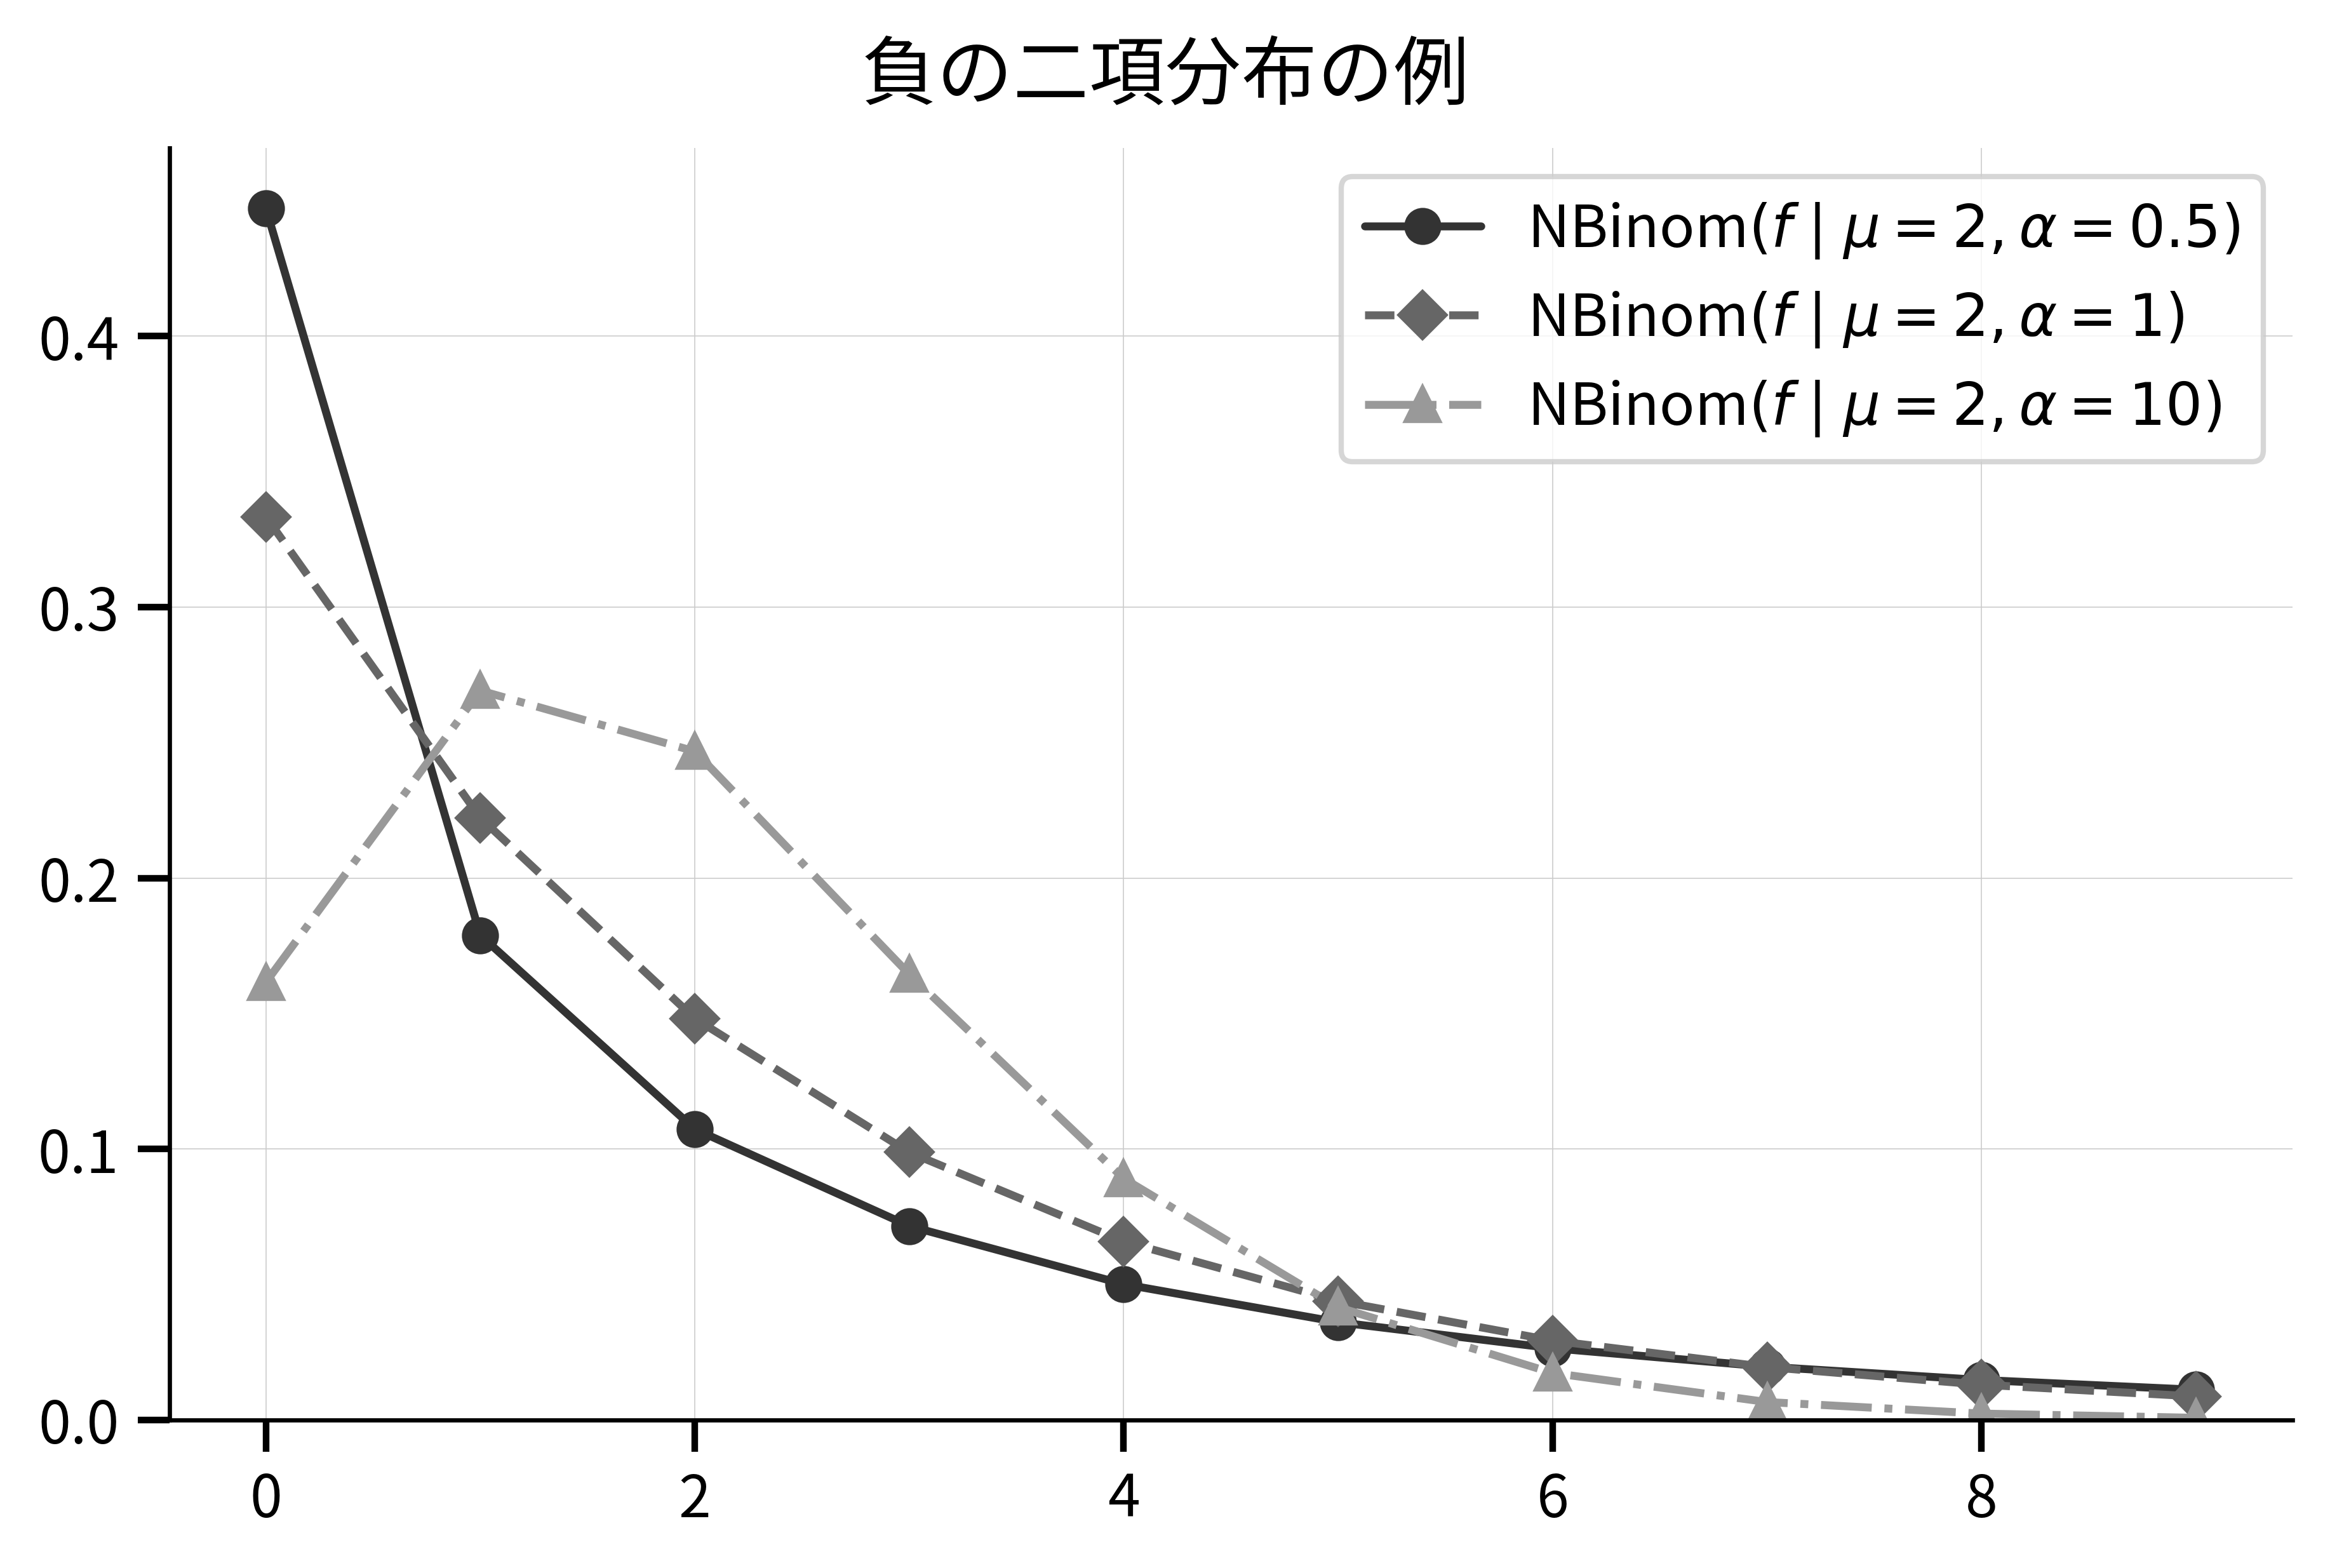

In [21]:
from scipy.stats import nbinom


def plot_nbinom(
    f: np.ndarray, mu_list: list[float], alpha_list: list[float]
) -> tuple[Figure, Axes]:
    """負の二項分布を可視化"""

    fig, ax = plt.subplots()

    markers = ["o", "D", "^", "x"]
    linestyles = ["solid", "dashed", "dashdot", "dotted"]
    for i, (mu, alpha) in enumerate(zip(mu_list, alpha_list)):
        y = nbinom.pmf(
            k=f, p=alpha / (mu + alpha), n=alpha
        )  # 負の二項分布の確率質量関数
        ax.plot(
            f,
            y,
            marker=markers[i % len(markers)],
            linestyle=linestyles[i % len(linestyles)],
            label=f"NBinom$(f \\mid \\mu = {mu}, \\alpha = {alpha})$",
        )

    ax.legend()
    ax.set_ylim(0, None)
    fig.suptitle("負の二項分布の例")

    return fig, ax


# 負の二項分布を可視化
fig, ax = plot_nbinom(f=np.arange(10), mu_list=[2, 2, 2], alpha_list=[0.5, 1, 10])

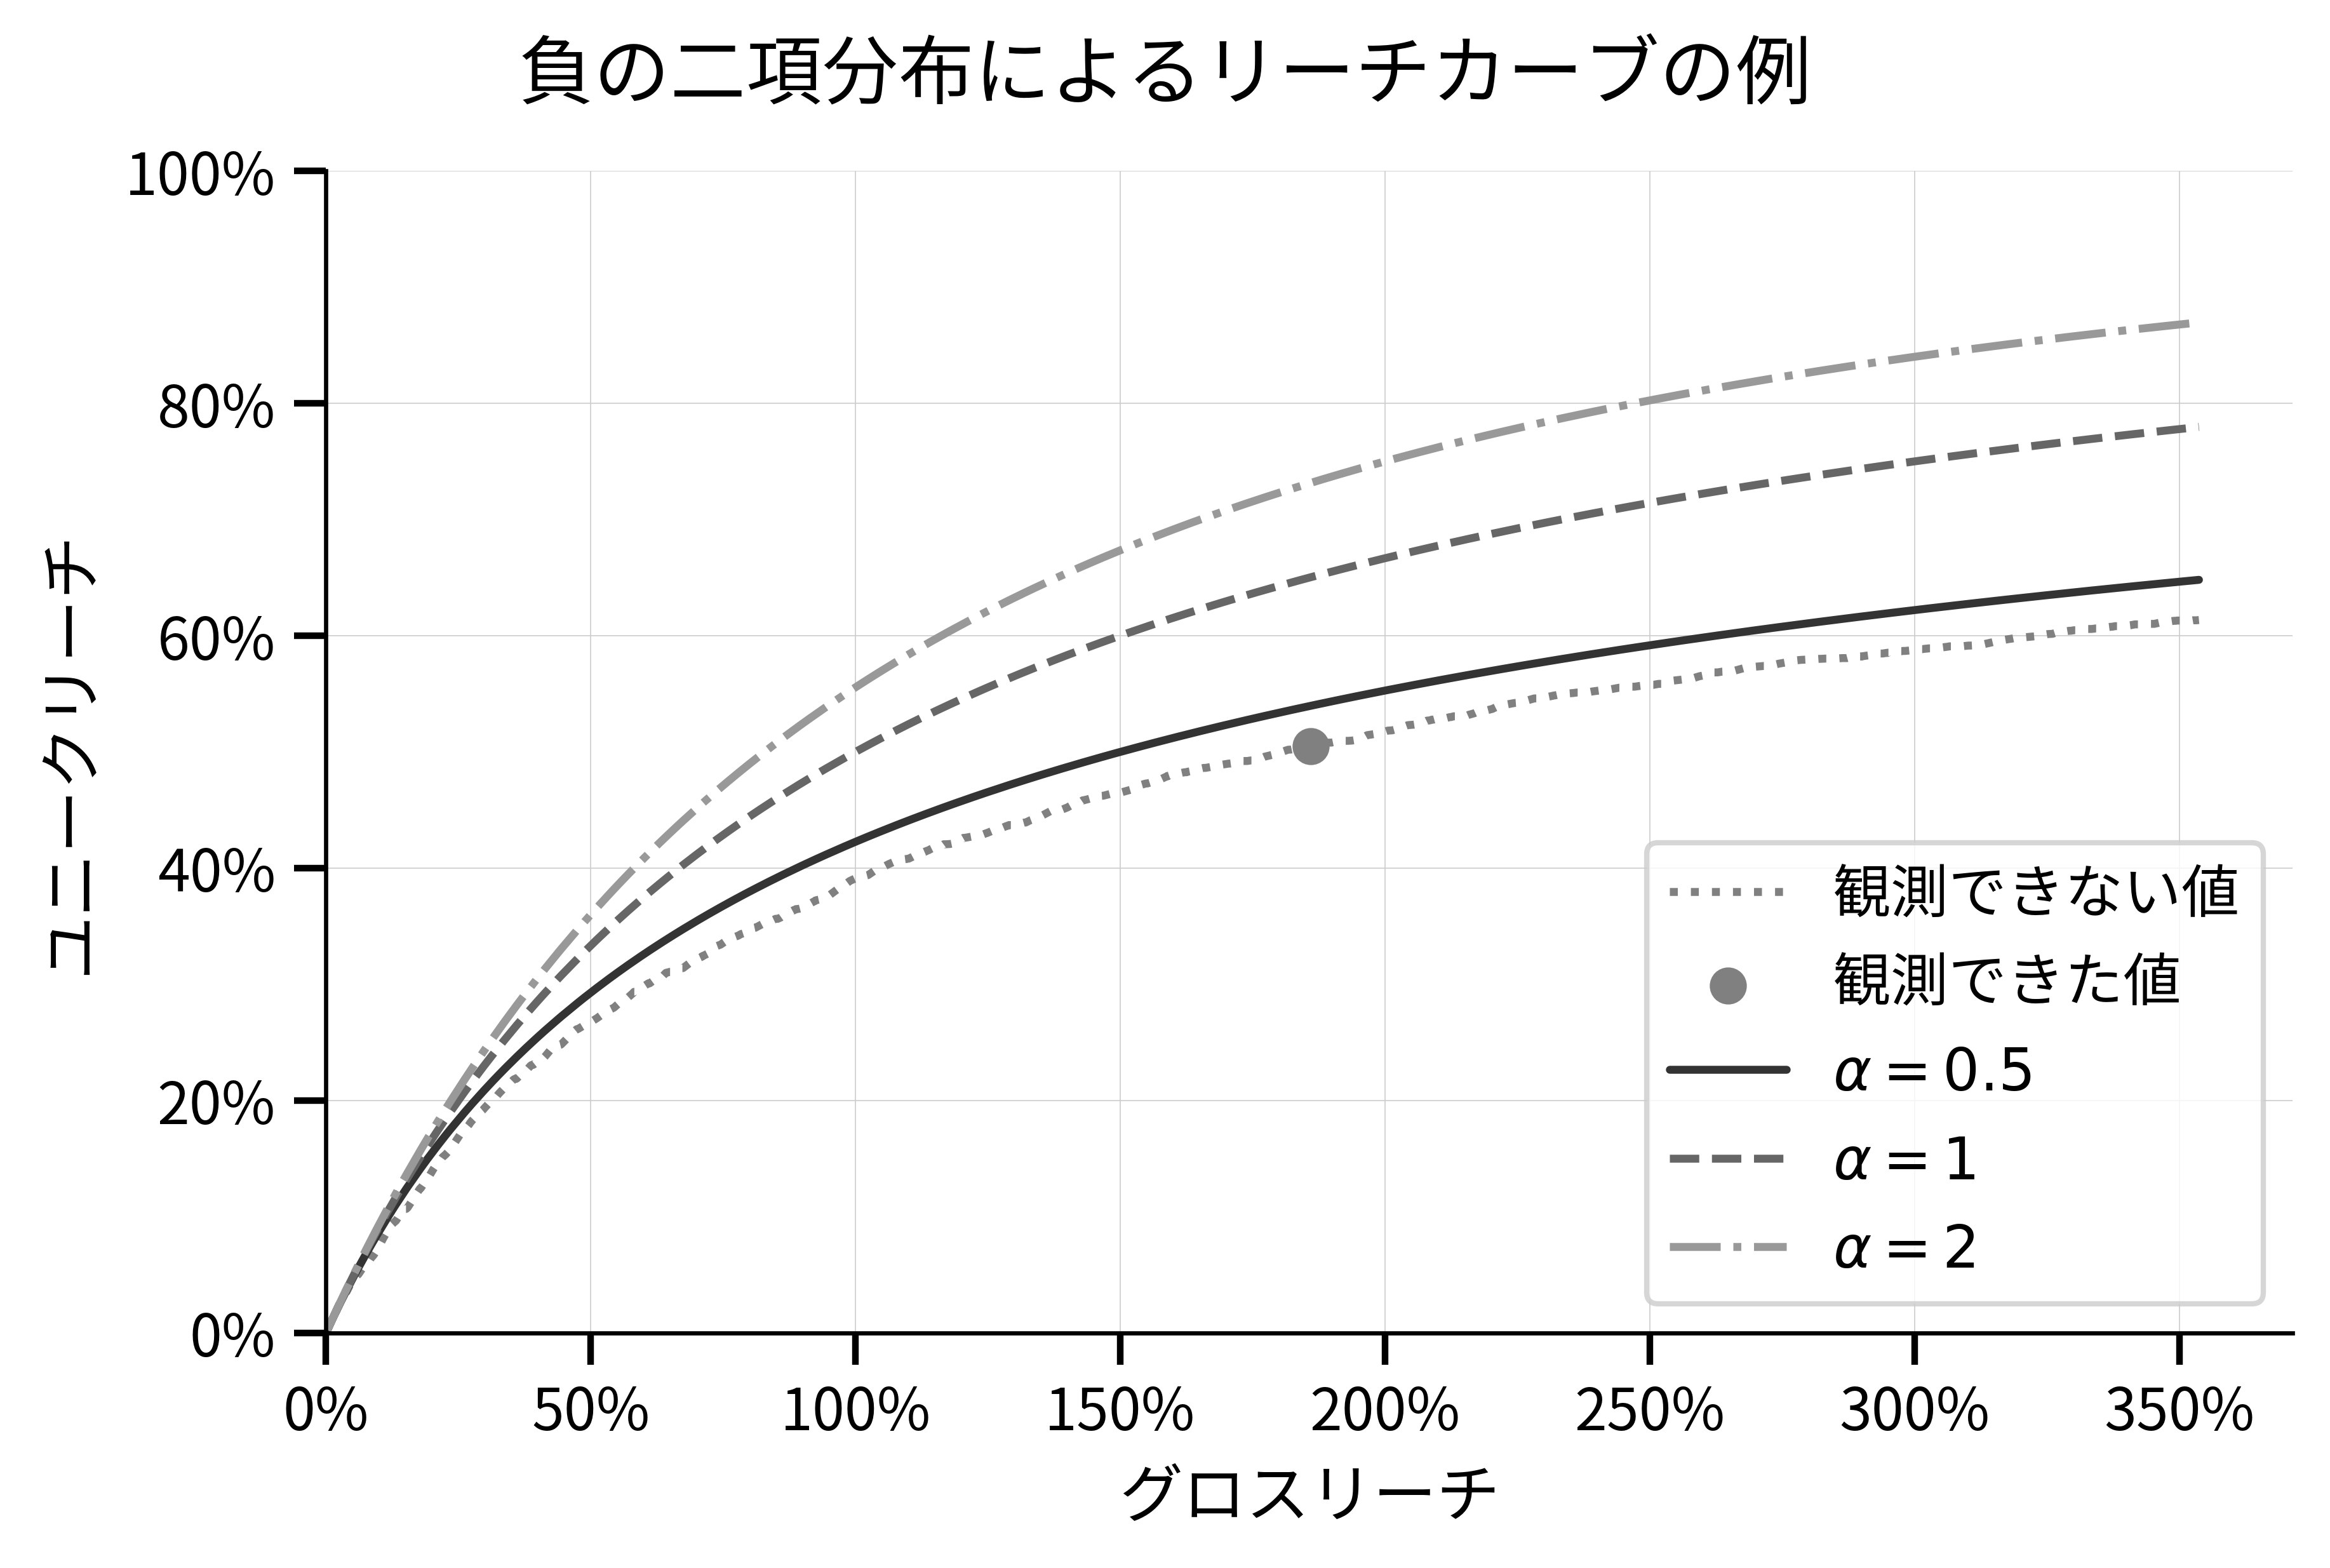

In [22]:
def predict_reach_nbinom(g: np.ndarray | pl.Series, alpha: float) -> np.ndarray:
    """負の二項分布を仮定したリーチカーブ"""

    return 1 - nbinom.pmf(k=0, p=alpha / (g + alpha), n=alpha)


def plot_reach_curve_with_predictions(
    df_reach: pl.DataFrame,
    df_reach_observed: pl.DataFrame,
    r_preds: list[np.ndarray],
    prediction_labels: list[str],
    title: str,
) -> tuple[Figure, Axes]:
    """負の二項分布を仮定したリーチカーブを複数描く"""

    fig, ax = plot_reach_curve(df_reach, df_reach_observed, title)

    linestyles = ["solid", "dashed", "dashdot", "dotted"]
    for i, (r_pred, prediction_label) in enumerate(zip(r_preds, prediction_labels)):
        ax.plot(
            df_reach["g"],
            r_pred,
            linestyle=linestyles[i % len(linestyles)],
            label=prediction_label,
        )

    ax.legend()

    return fig, ax


# 負の二項分布を仮定したリーチカーブの可視化
alpha_list = [0.5, 1, 2]
fig, ax = plot_reach_curve_with_predictions(
    df_reach=df_reach,
    df_reach_observed=df_reach_observed,
    r_preds=[predict_reach_nbinom(df_reach["g"], alpha) for alpha in alpha_list],
    prediction_labels=[f"$\\alpha = {alpha}$" for alpha in alpha_list],
    title="負の二項分布によるリーチカーブの例",
)

In [23]:
from scipy.optimize import minimize_scalar
from sklearn.metrics import mean_squared_error


def estimate_optimal_alpha(
    g: np.ndarray | pl.Series, r: np.ndarray | pl.Series
) -> float:
    """データに最も当てはまるalphaを求める"""

    return minimize_scalar(
        fun=lambda alpha: mean_squared_error(
            r, predict_reach_nbinom(g=g, alpha=alpha)
        ),  # 最小化したい関数
        bounds=(0.01, 100),  # 推定範囲。alphaは0より大きい
    ).x


# 最適なalphaの推定
alpha_hat = estimate_optimal_alpha(g=df_reach_observed["g"], r=df_reach_observed["r"])
print(f"alpha_hat = {alpha_hat:.2f}")

alpha_hat = 0.41


データに最も当てはまるのは$\hat{\alpha} = 0.41$でした。
この$\hat{\alpha}$を使ってリーチカーブを可視化してみましょう。


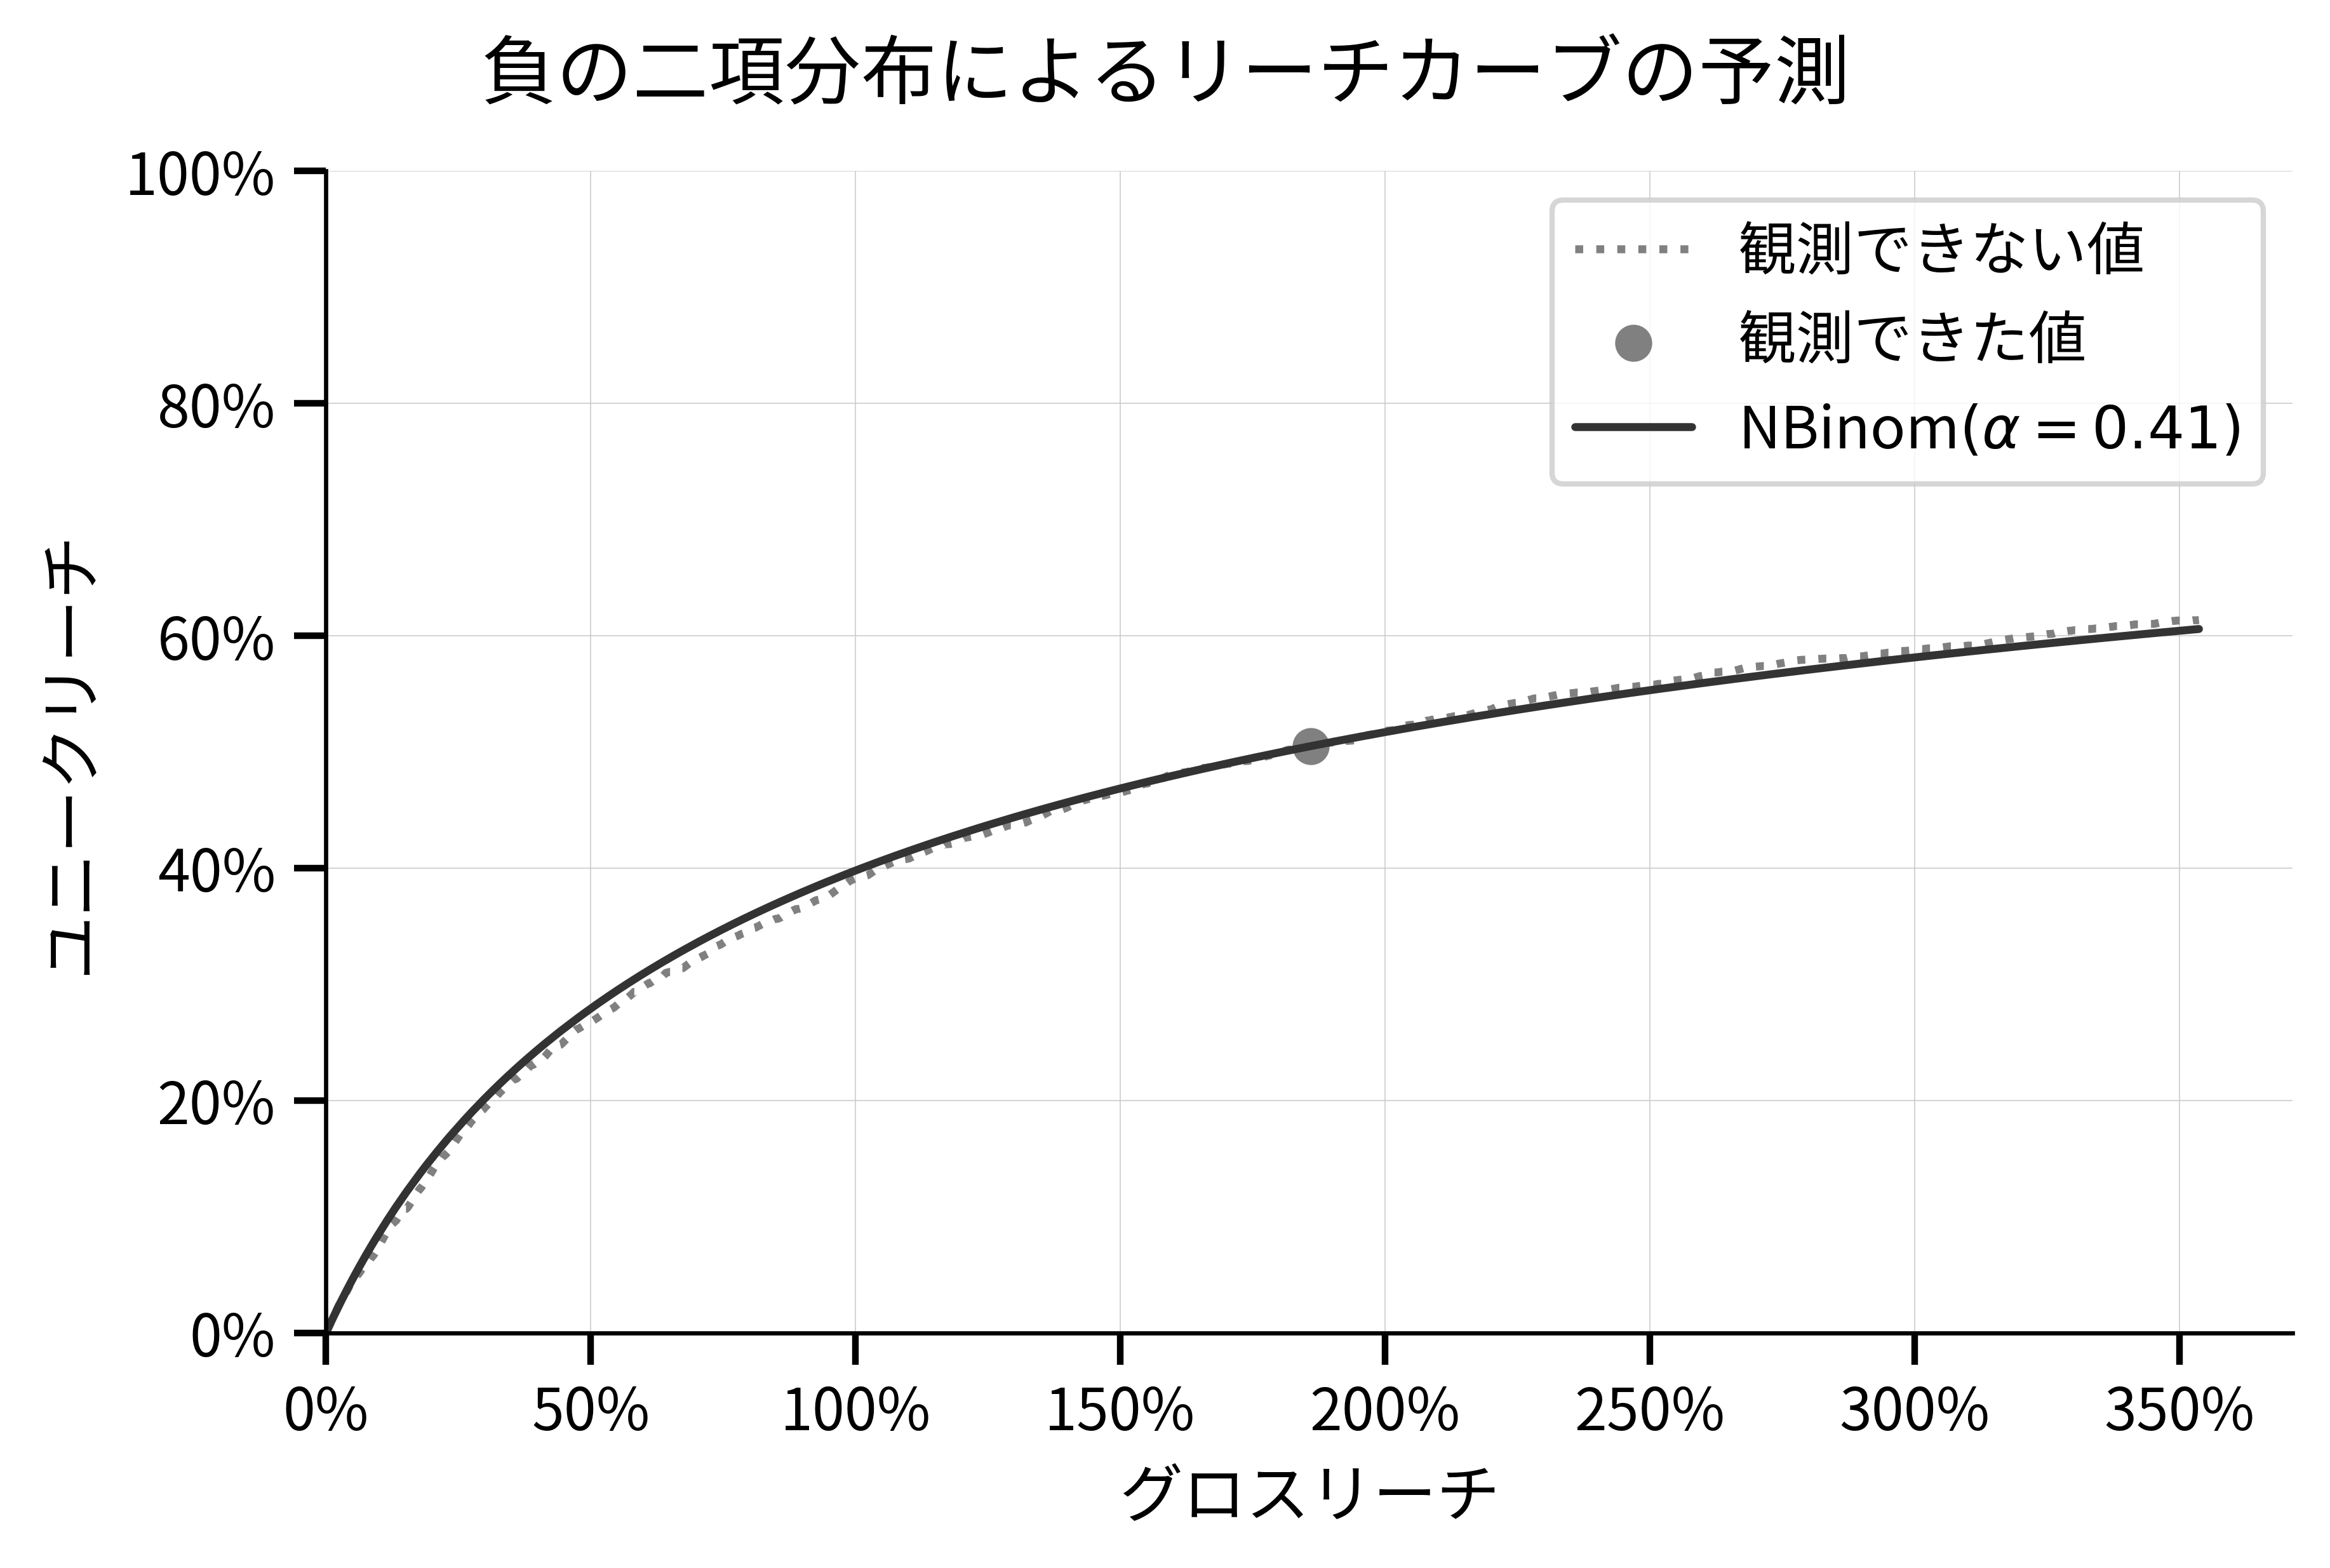

In [24]:
# 負の二項分布を用いたリーチカーブ
r_pred_nbinom = predict_reach_nbinom(g=df_reach["g"], alpha=alpha_hat)

# 推定したリーチカーブを可視化
fig, ax = plot_reach_curve_with_prediction(
    df_reach=df_reach,
    df_reach_observed=df_reach_observed,
    r_pred=r_pred_nbinom,
    prediction_label=f"NBinom$(\\alpha = {alpha_hat:.2f})$",
    title="負の二項分布によるリーチカーブの予測",
)

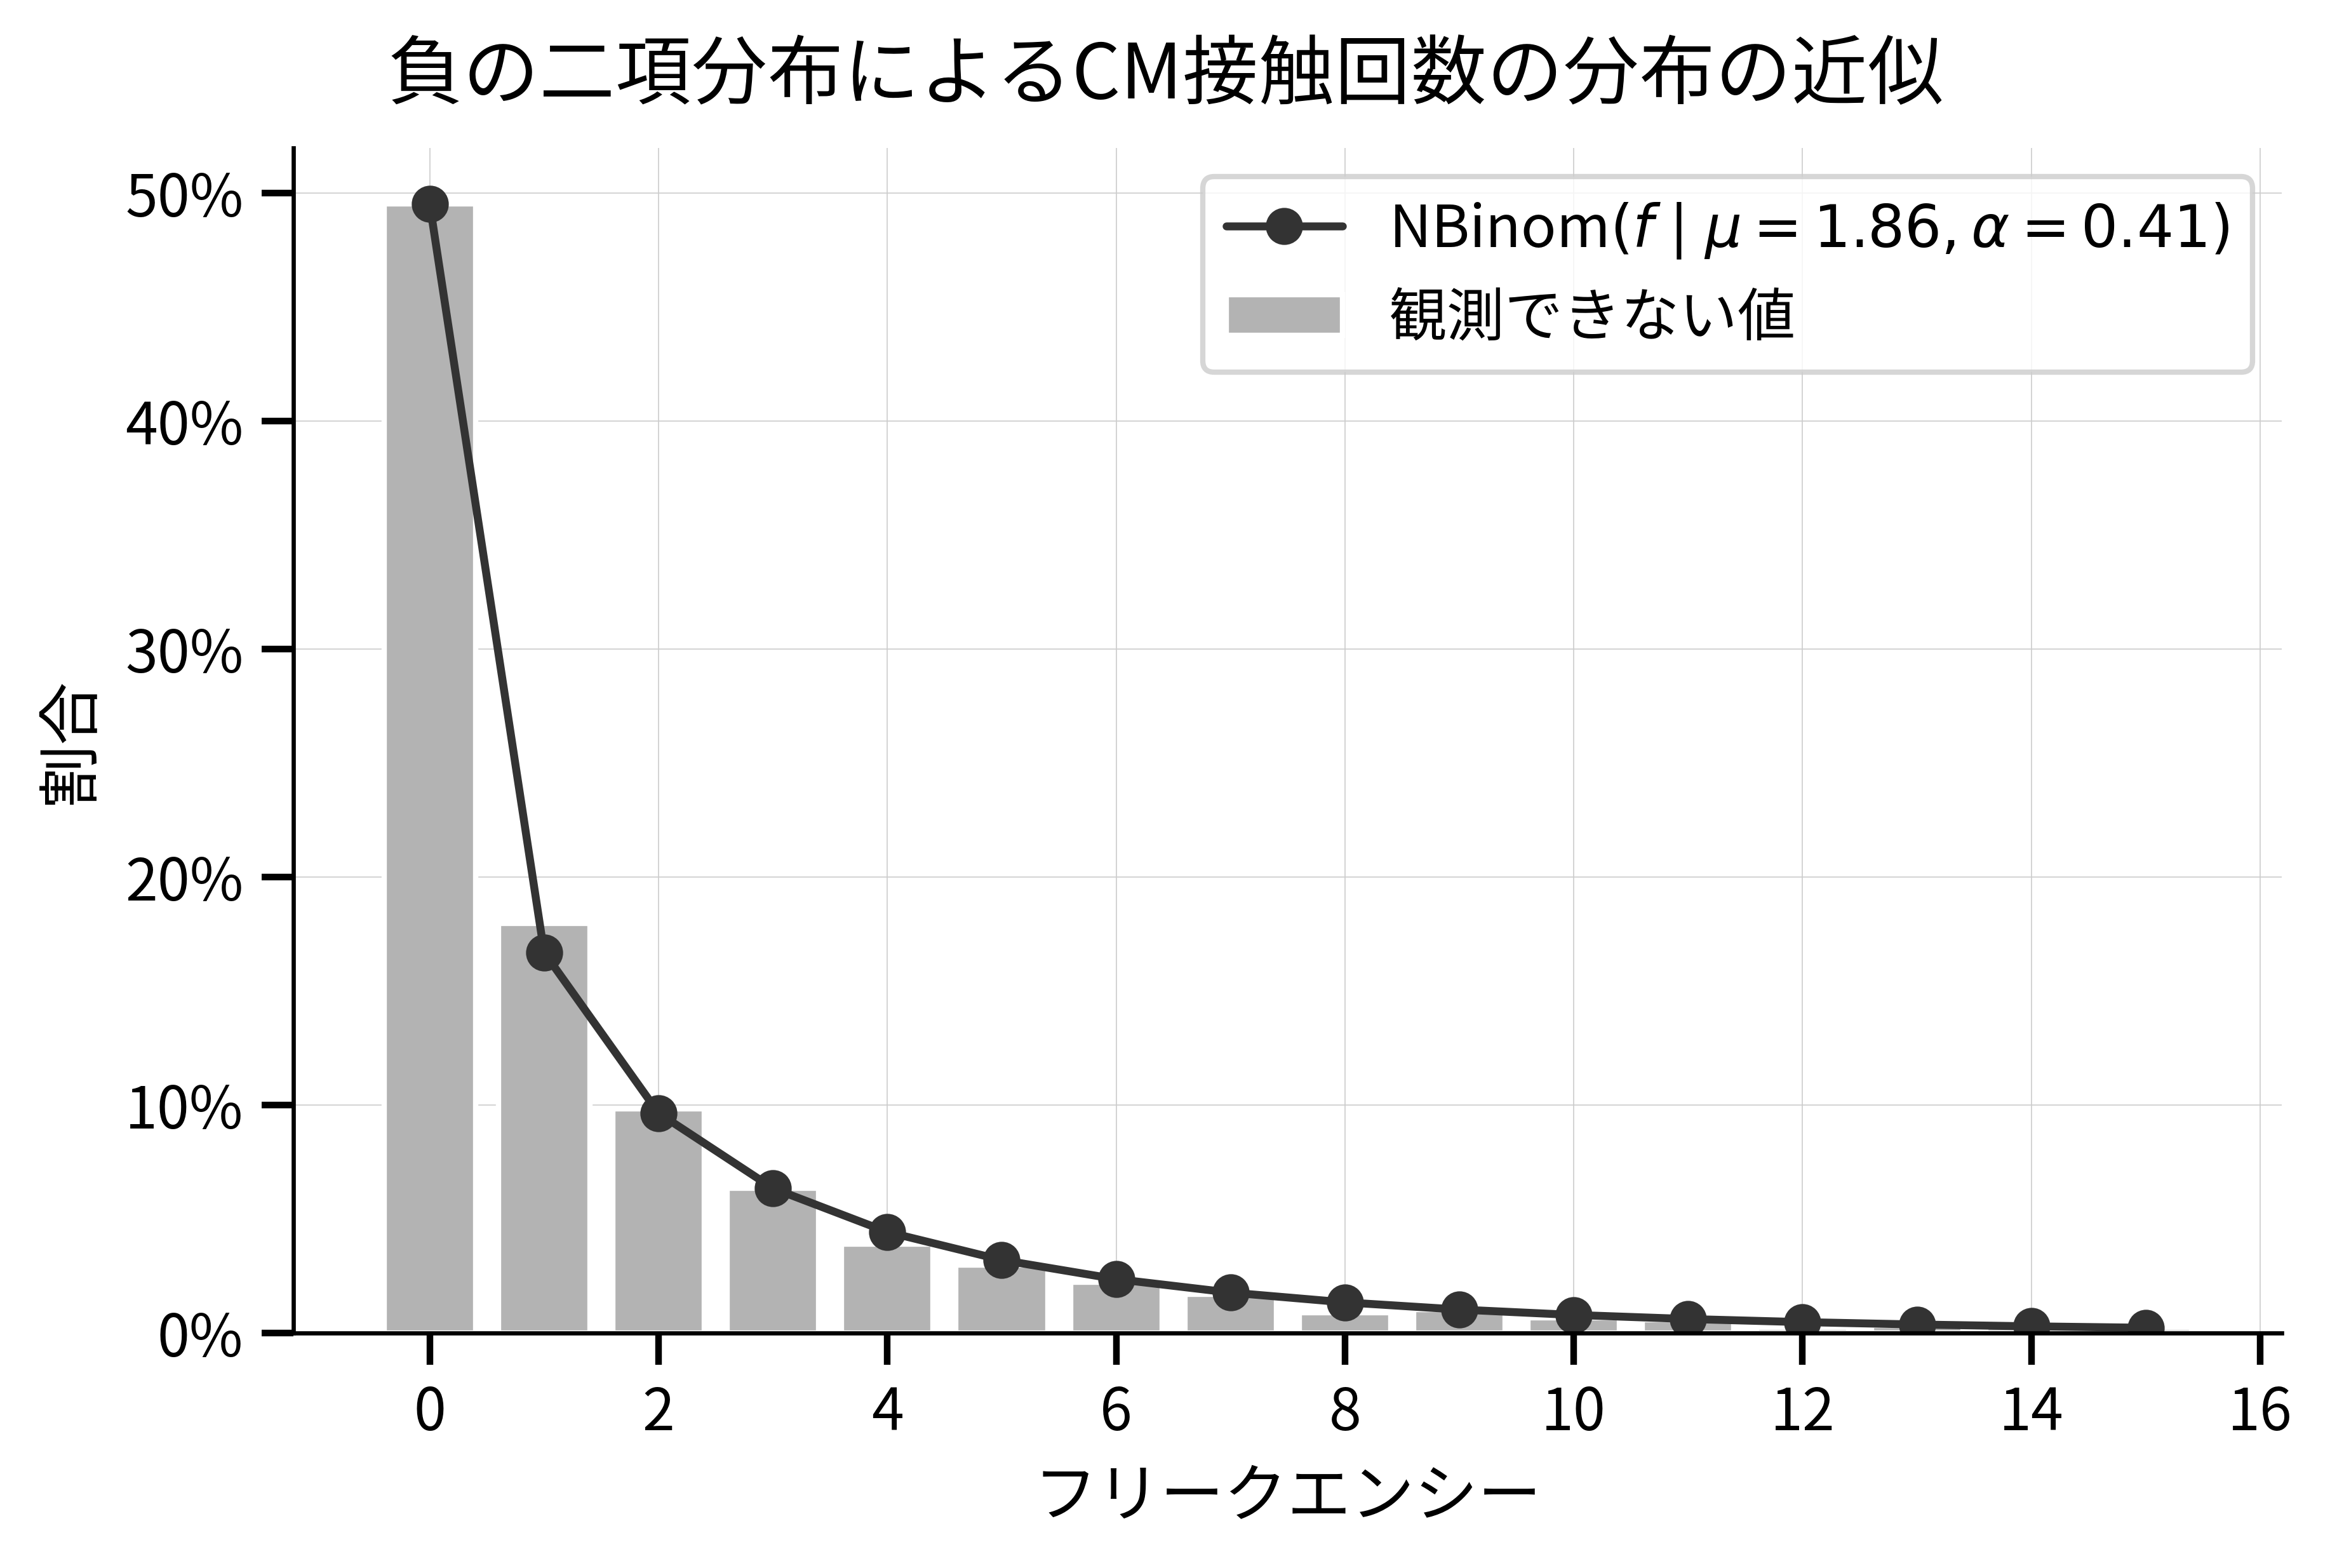

In [25]:
# 負の二項分布を用いたCM接触回数の分布
prop_nbinom = nbinom.pmf(
    k=range(f_max + 1),
    p=alpha_hat / (df_reach_observed["g"] + alpha_hat),
    n=alpha_hat,
)

# CM接触回数の分布と負の二項分布を重ね合わせて可視化
fig, ax = plot_histogram_with_distribution(
    df_frequency_observed=df_frequency_observed,
    prop_pred=prop_nbinom,
    prop_label=f"NBinom$(f \\mid \\mu = {df_reach_observed["g"].item(): .2f}, \\alpha = {alpha_hat: .2f})$",
    f_max=f_max,
    title="負の二項分布によるCM接触回数の分布の近似",
)

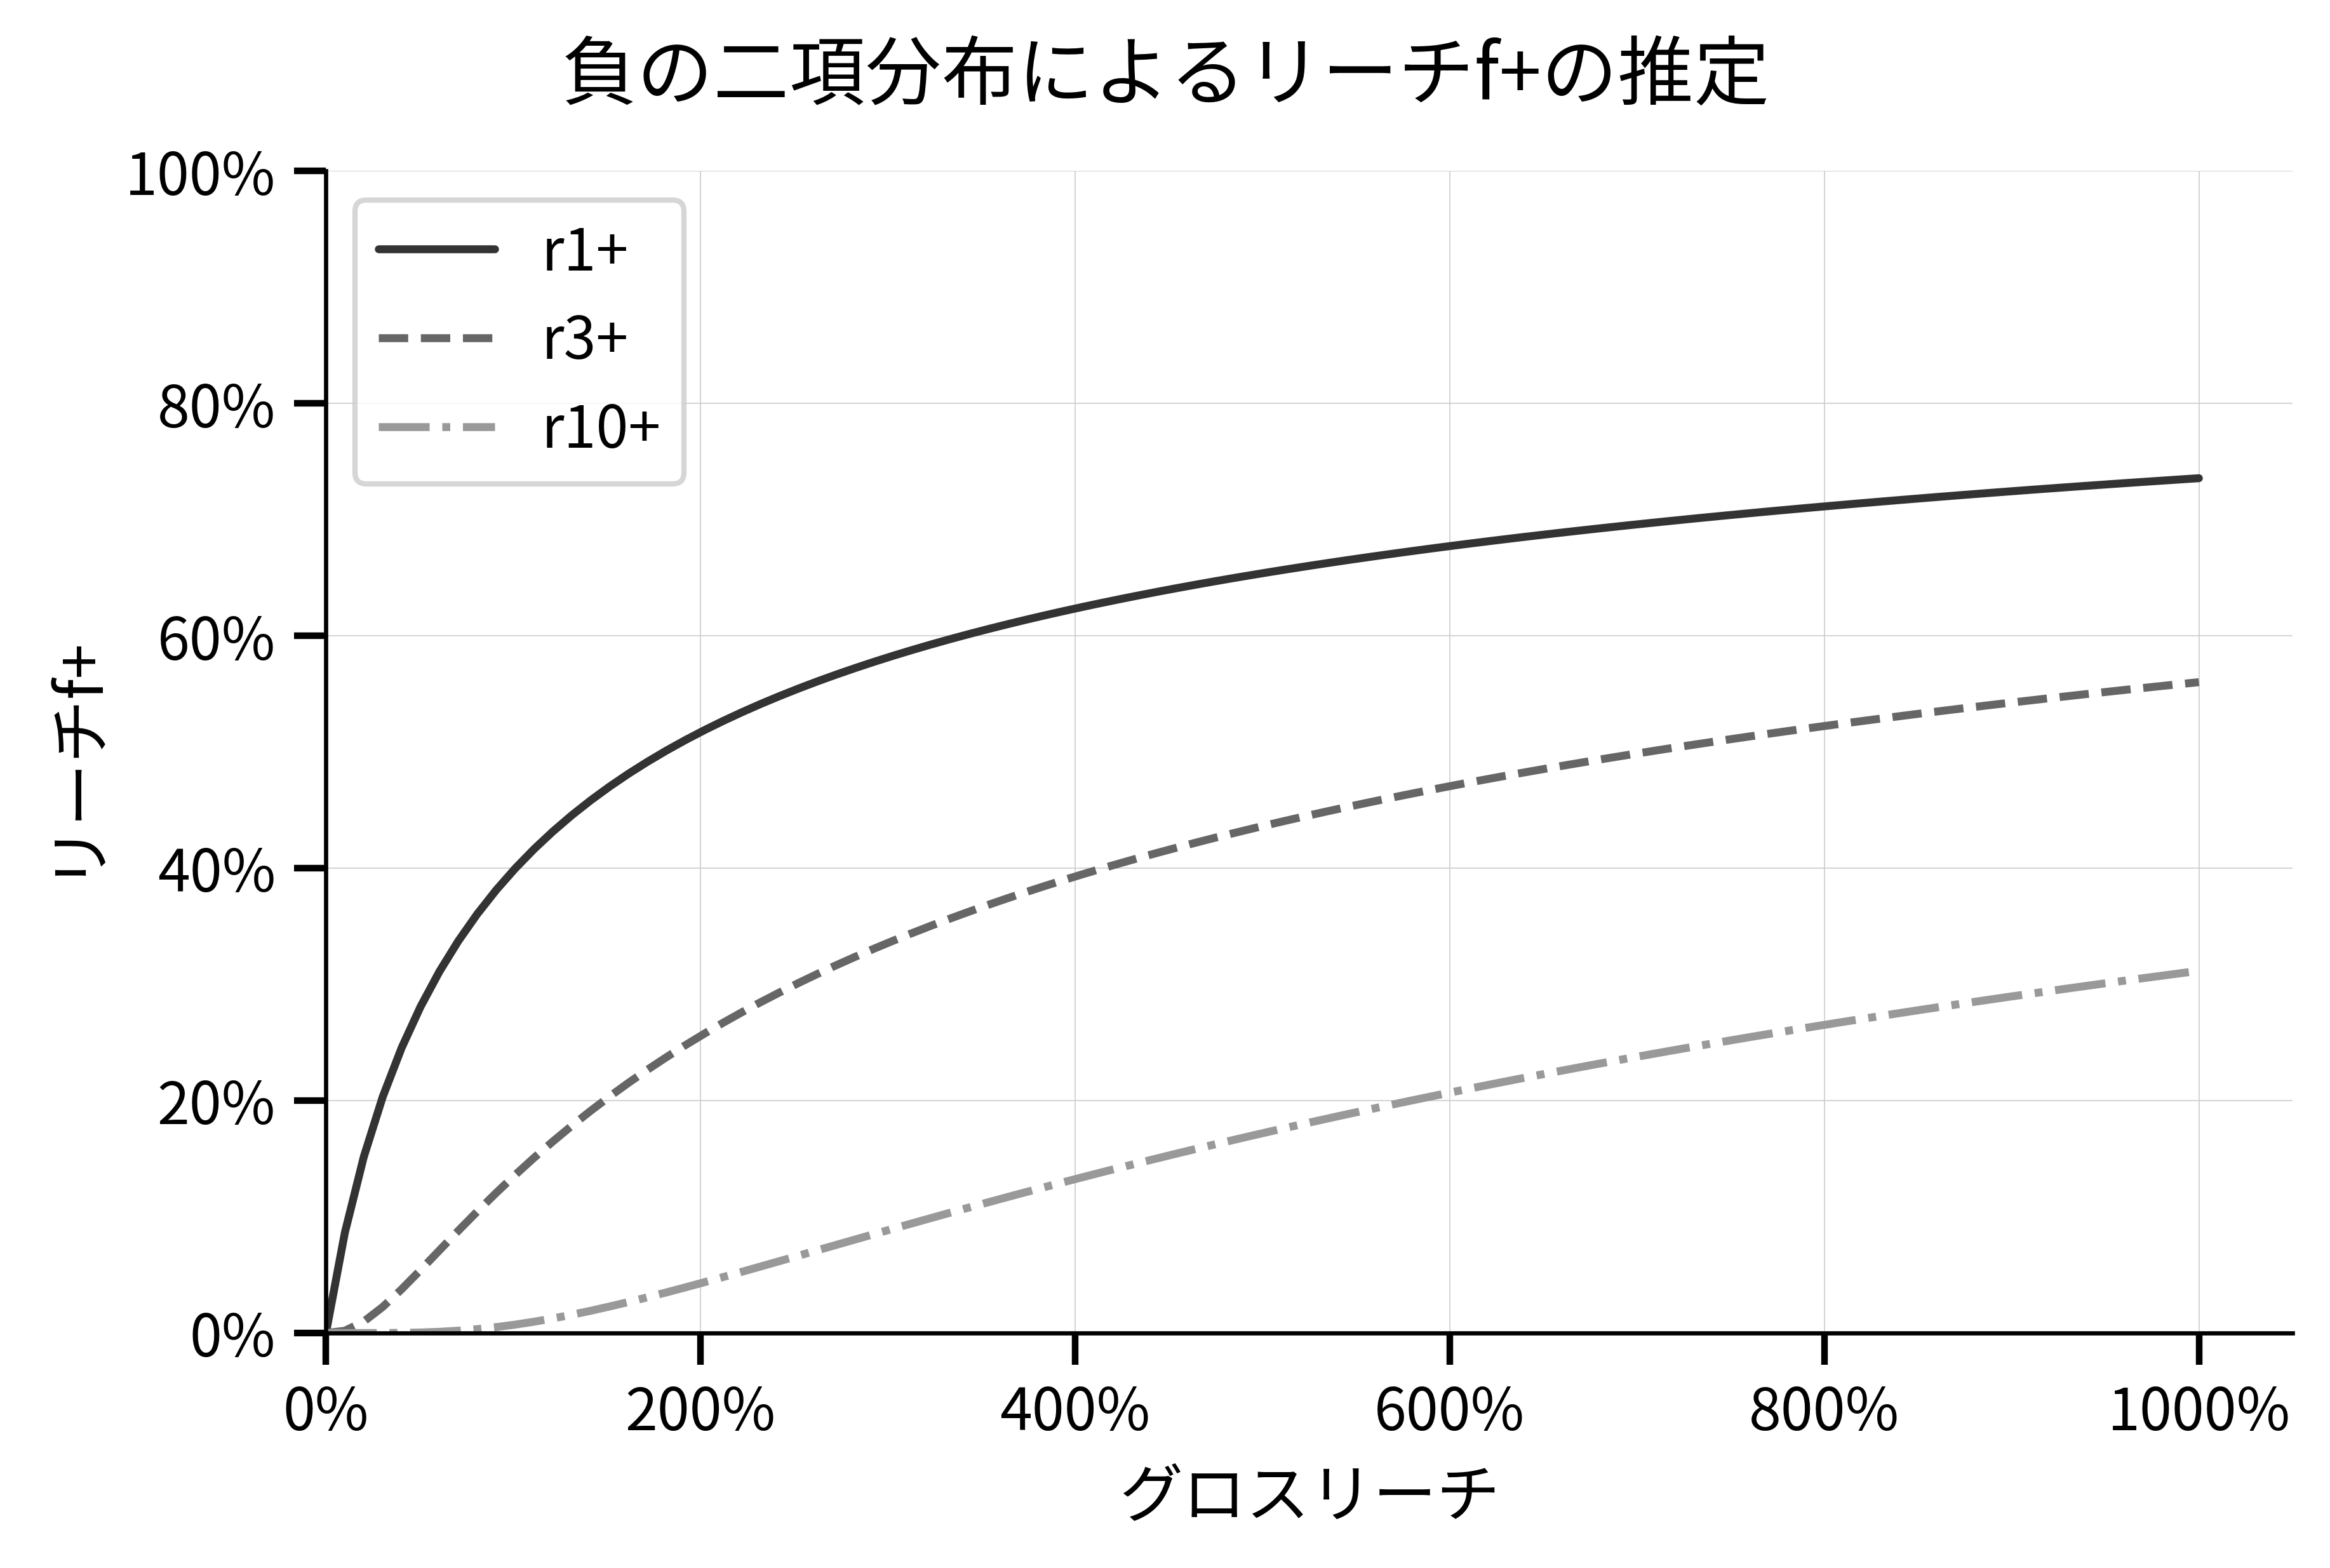

In [26]:
def predict_reach_f_plus_nbinom(
    g: np.ndarray | pl.Series, alpha: float, f_plus: int
) -> np.ndarray:
    """リーチf+の計算"""

    return 1 - nbinom.cdf(
        f_plus - 1, p=alpha / (g + alpha), n=alpha
    )  # 負の二項分布の累積分布関数


def plot_reach_f_plus_curves_nbinom(
    g: np.ndarray | pl.Series,
    alpha: float,
    f_plus_list: list[int],
) -> tuple[Figure, Axes]:
    """リーチf+の可視化"""

    fig, ax = plt.subplots()

    linestyles = ["solid", "dashed", "dashdot", "dotted"]
    for i, f_plus in enumerate(f_plus_list):
        reach_f_plus = predict_reach_f_plus_nbinom(g=g, alpha=alpha, f_plus=f_plus)
        ax.plot(
            g,
            reach_f_plus,
            linestyle=linestyles[i % len(linestyles)],
            label=f"r{f_plus}+",
        )

    ax.legend()
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_xlim(0, None)
    ax.set_ylim(0, 1)
    ax.set_xlabel("グロスリーチ")
    ax.set_ylabel("リーチf+")
    fig.suptitle("負の二項分布によるリーチf+の推定")

    return fig, ax


# リーチf+の可視化
fig, ax = plot_reach_f_plus_curves_nbinom(
    g=np.linspace(0, 10, 100),
    alpha=alpha_hat,
    f_plus_list=[1, 3, 10],
)

## ステップ3：数理最適化問題を解いて 最適なアクションを導出する

optimal_g:  3.02
optimal_r:  0.58
optimal_p:  8626.44


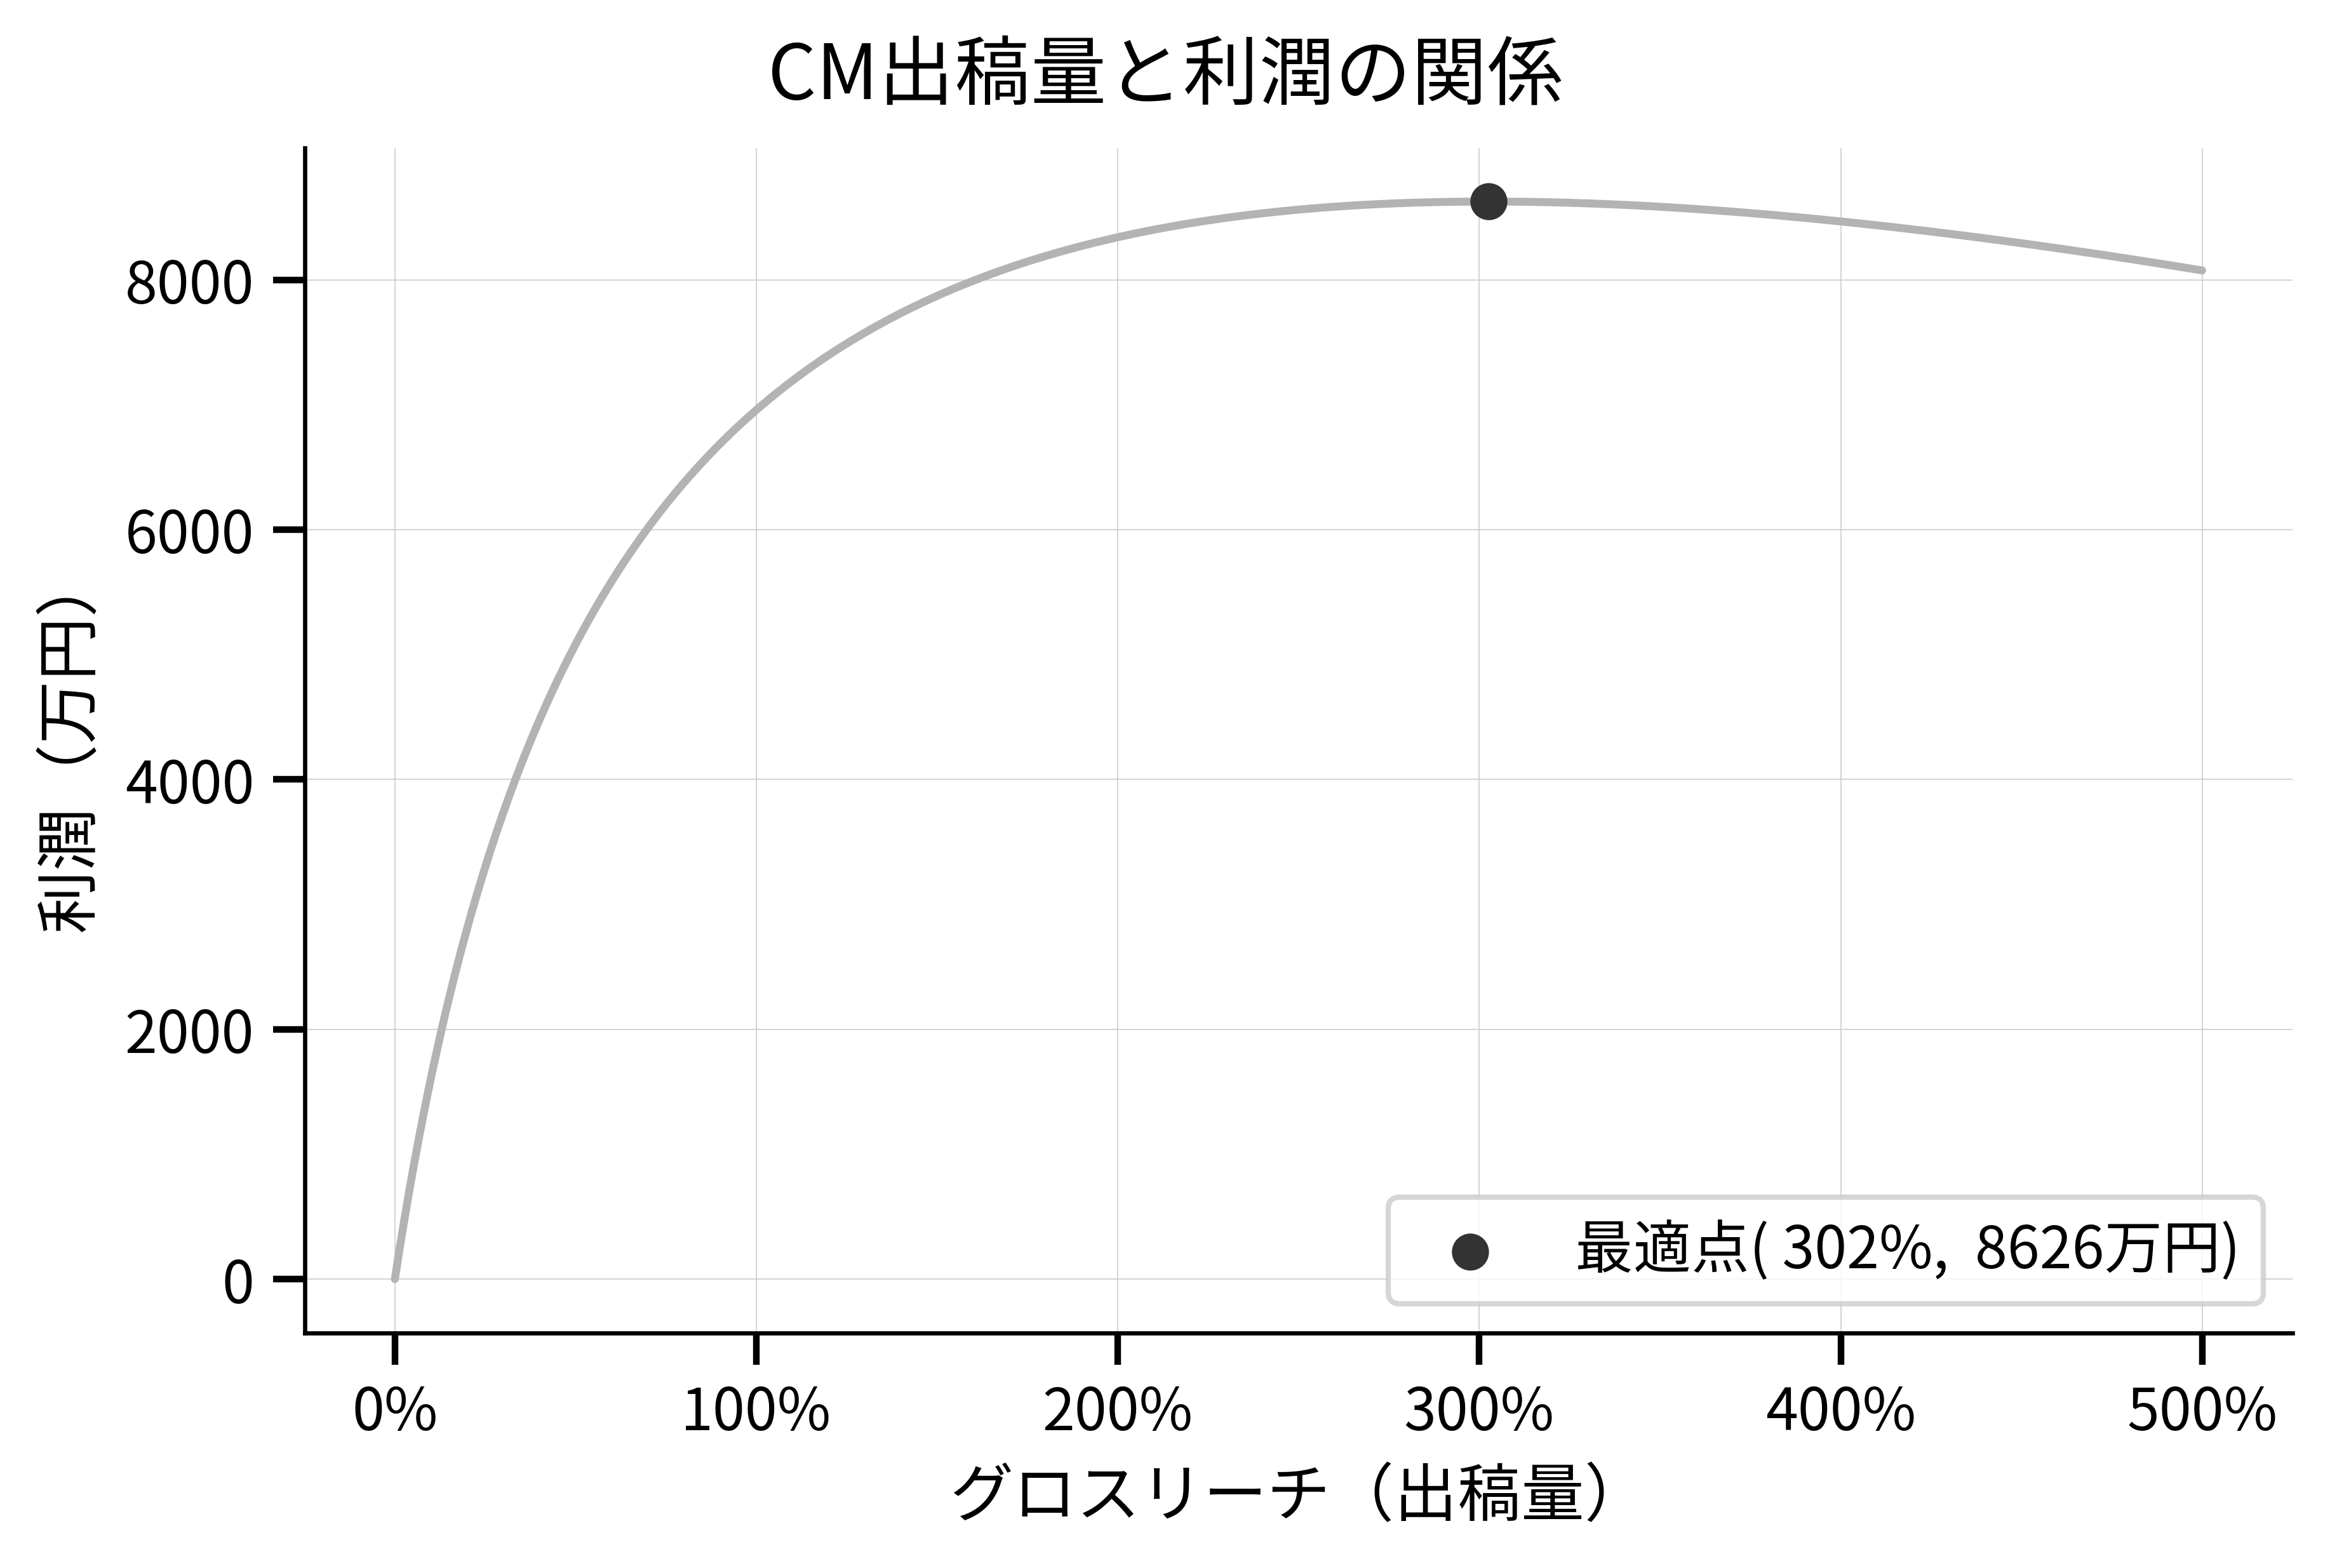

In [27]:
def plot_optimal_g(
    s: float, q: float, n: int, c: float, b: float, alpha: float
) -> tuple[Figure, Axes]:
    g = np.linspace(0, b / (100 * c), 1001)
    r = predict_reach_nbinom(g=g, alpha=alpha)
    p = s * q * n * r - 100 * c * g

    max_index = np.argmax(p)  # 利潤を最大化するインデックス
    # その時のグロスリーチ、ユニークリーチ、利潤
    optimal_g = g[max_index]
    optimal_r = r[max_index]
    optimal_p = p[max_index]

    fig, ax = plt.subplots()
    ax.plot(g, p, c=".7", zorder=1)
    ax.scatter(
        optimal_g,
        optimal_p,
        label=f"最適点({optimal_g * 100: .0f}%, {optimal_p: .0f}万円)",
        zorder=2,
    )
    ax.legend()
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set(xlabel="グロスリーチ（出稿量）", ylabel="利潤（万円）")
    fig.suptitle("CM出稿量と利潤の関係")

    print(f"optimal_g: {optimal_g: .2f}")
    print(f"optimal_r: {optimal_r: .2f}")
    print(f"optimal_p: {optimal_p: .2f}")

    return fig, ax


# CM出稿量と利潤の関係を可視化
fig, ax = plot_optimal_g(s=0.2, q=0.01, n=1000 * 10000, c=10, b=5000, alpha=alpha_hat)

## 付録：シミュレーションによる数理モデルの検証

In [28]:
def generate_data(n: int, t_total: int, alpha: float, beta: float) -> pl.DataFrame:
    """グロスリーチとユニークリーチのシミュレーションデータを生成する"""

    # ベータ分布から個人ごとのCMへの接触確率を生成
    theta_i = np.random.beta(alpha, beta, n)
    # 二項分布の試行回数を1にすることで、
    # ベルヌーイ分布から各CM放送回への接触の有無を生成
    r_it = np.random.binomial(1, theta_i, (t_total, n))

    # グロスリーチは足すだけ
    g_s = r_it.cumsum(0).mean(1)
    # ユニークリーチは非接触にしてから積を取る
    r_s = 1 - (1 - r_it).cumprod(0).mean(1)

    # データフレームとしてまとめる
    df_reach = pl.DataFrame({"t": range(1, t_total + 1), "g": g_s, "r": r_s})

    return df_reach


# シミュレーションデータを生成
df_reach_sim = generate_data(n=5000, t_total=100, alpha=1, beta=29)

# 一時点のみを抽出
df_reach_sim_observed = df_reach_sim.filter(pl.col.t == 50)

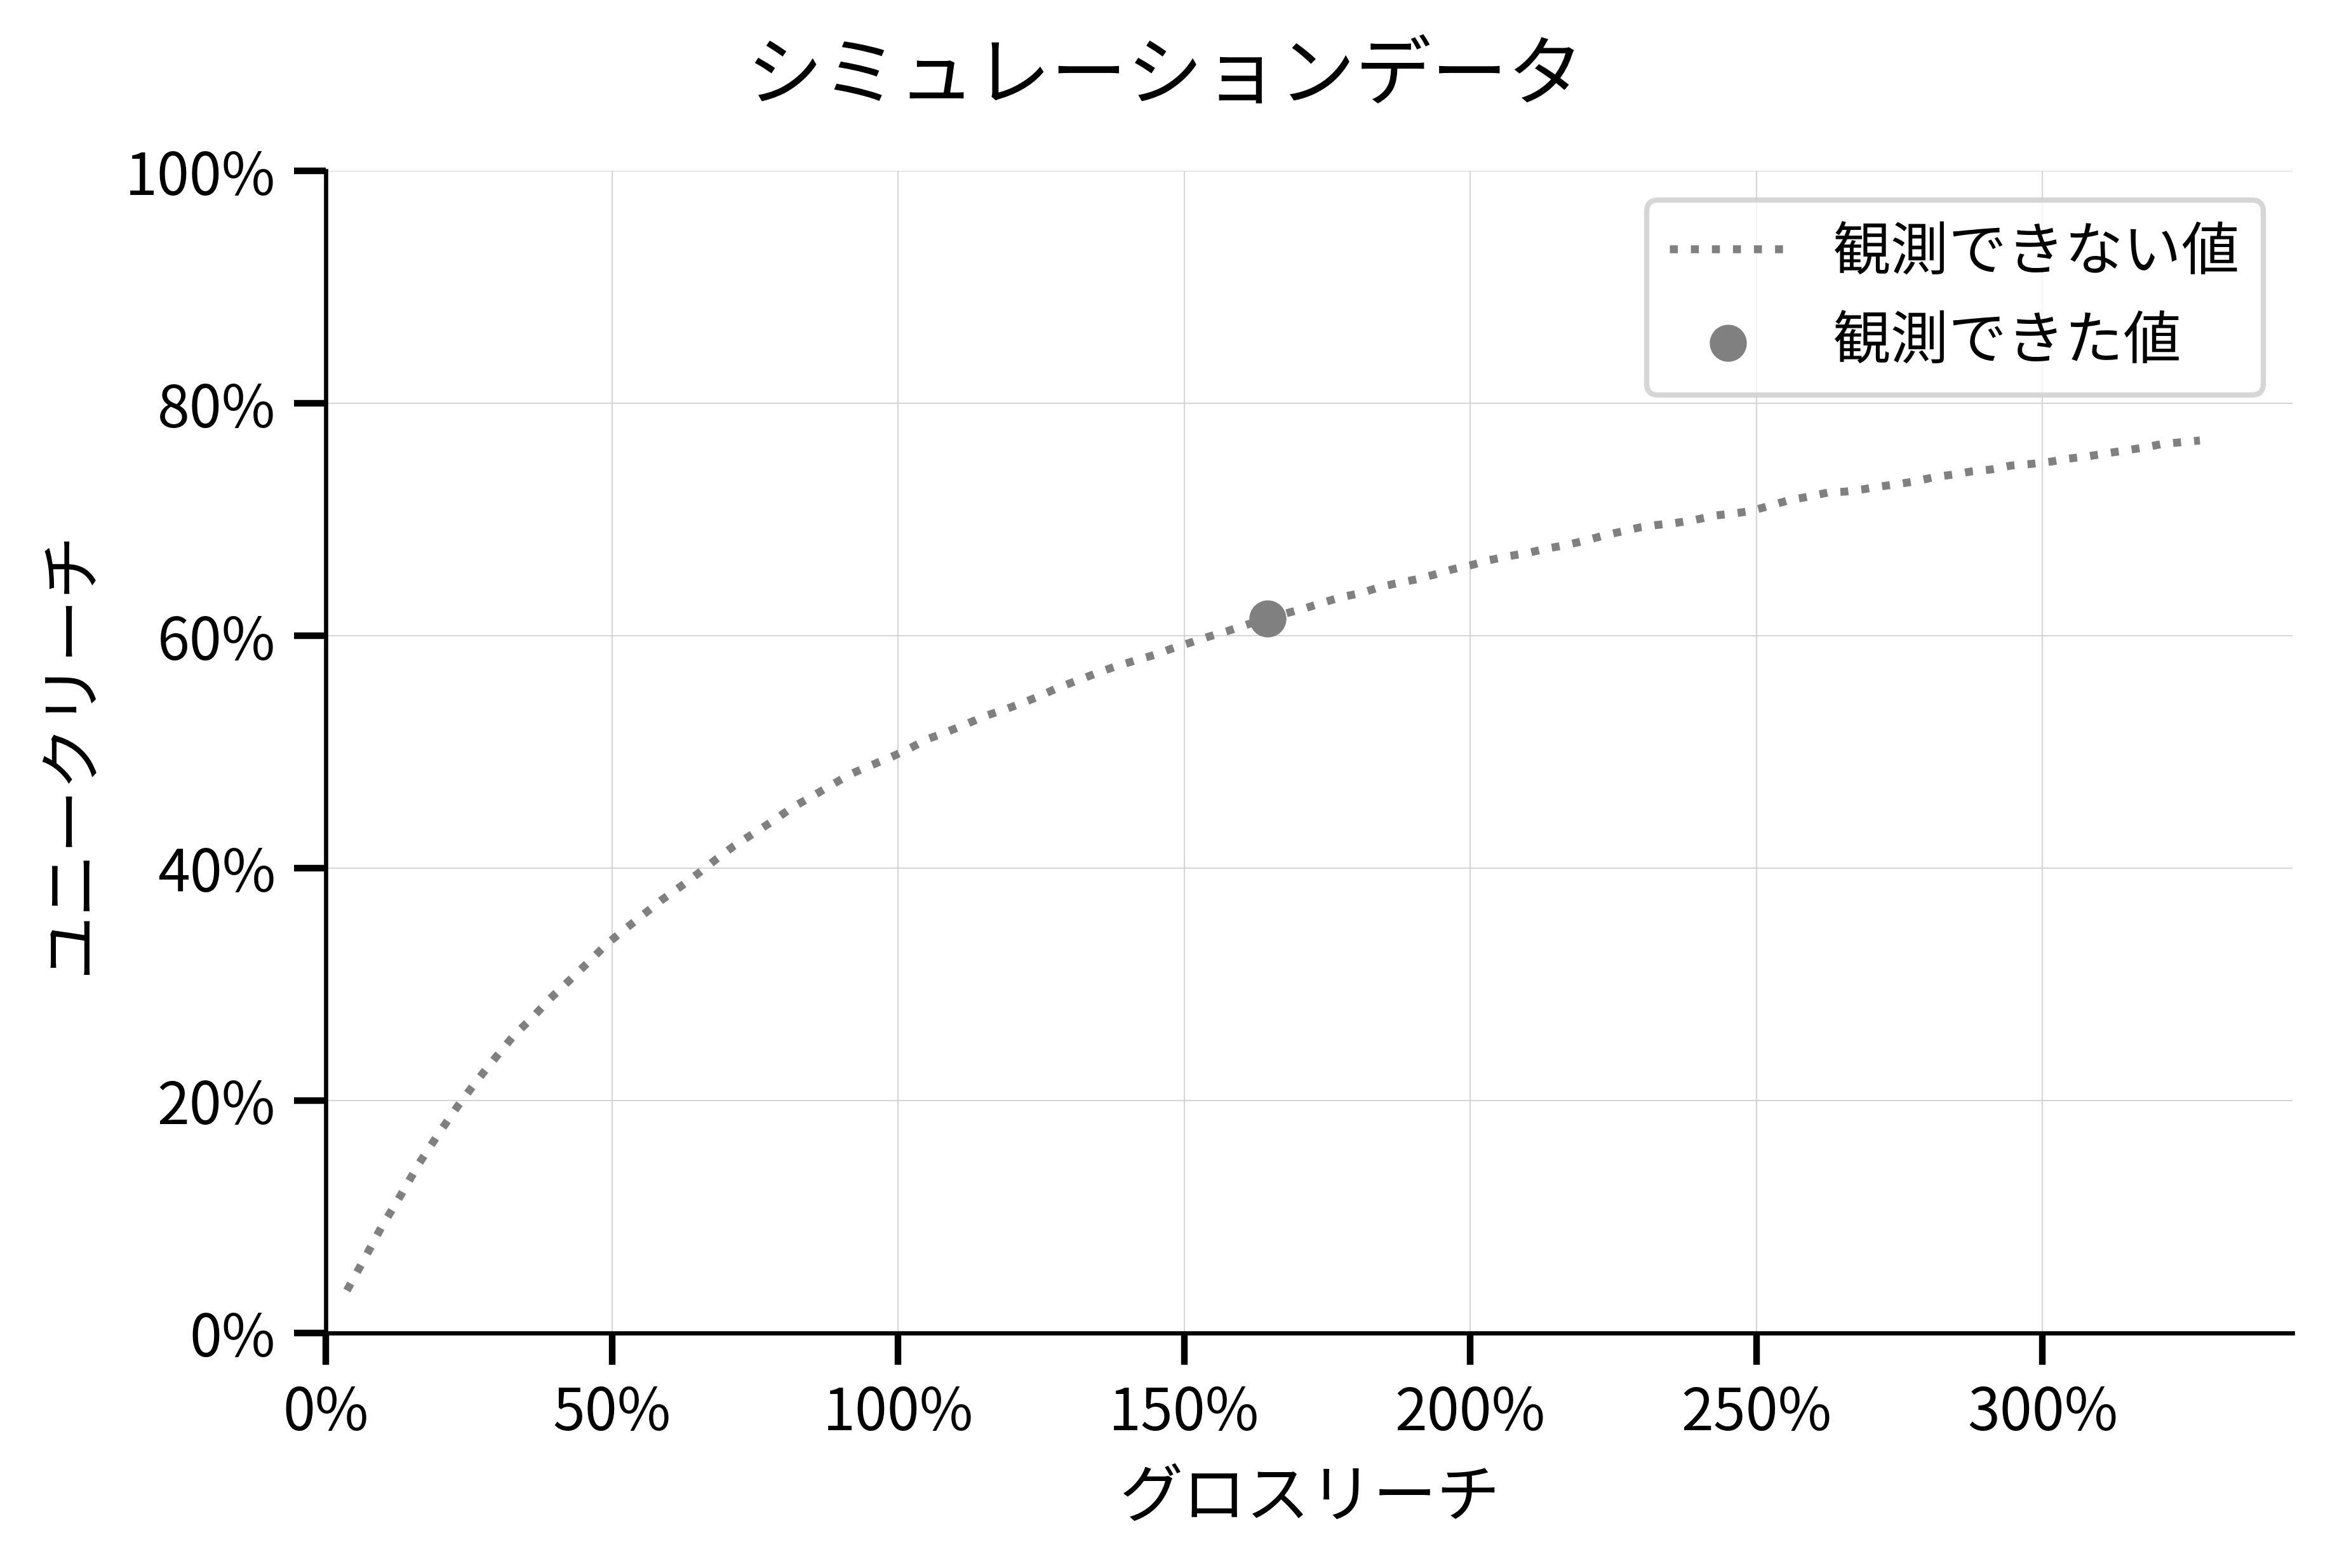

In [29]:
# 生成されたリーチカーブを可視化
fig, ax = plot_reach_curve(
    df_reach=df_reach_sim,
    df_reach_observed=df_reach_sim_observed,
    title="シミュレーションデータ",
)

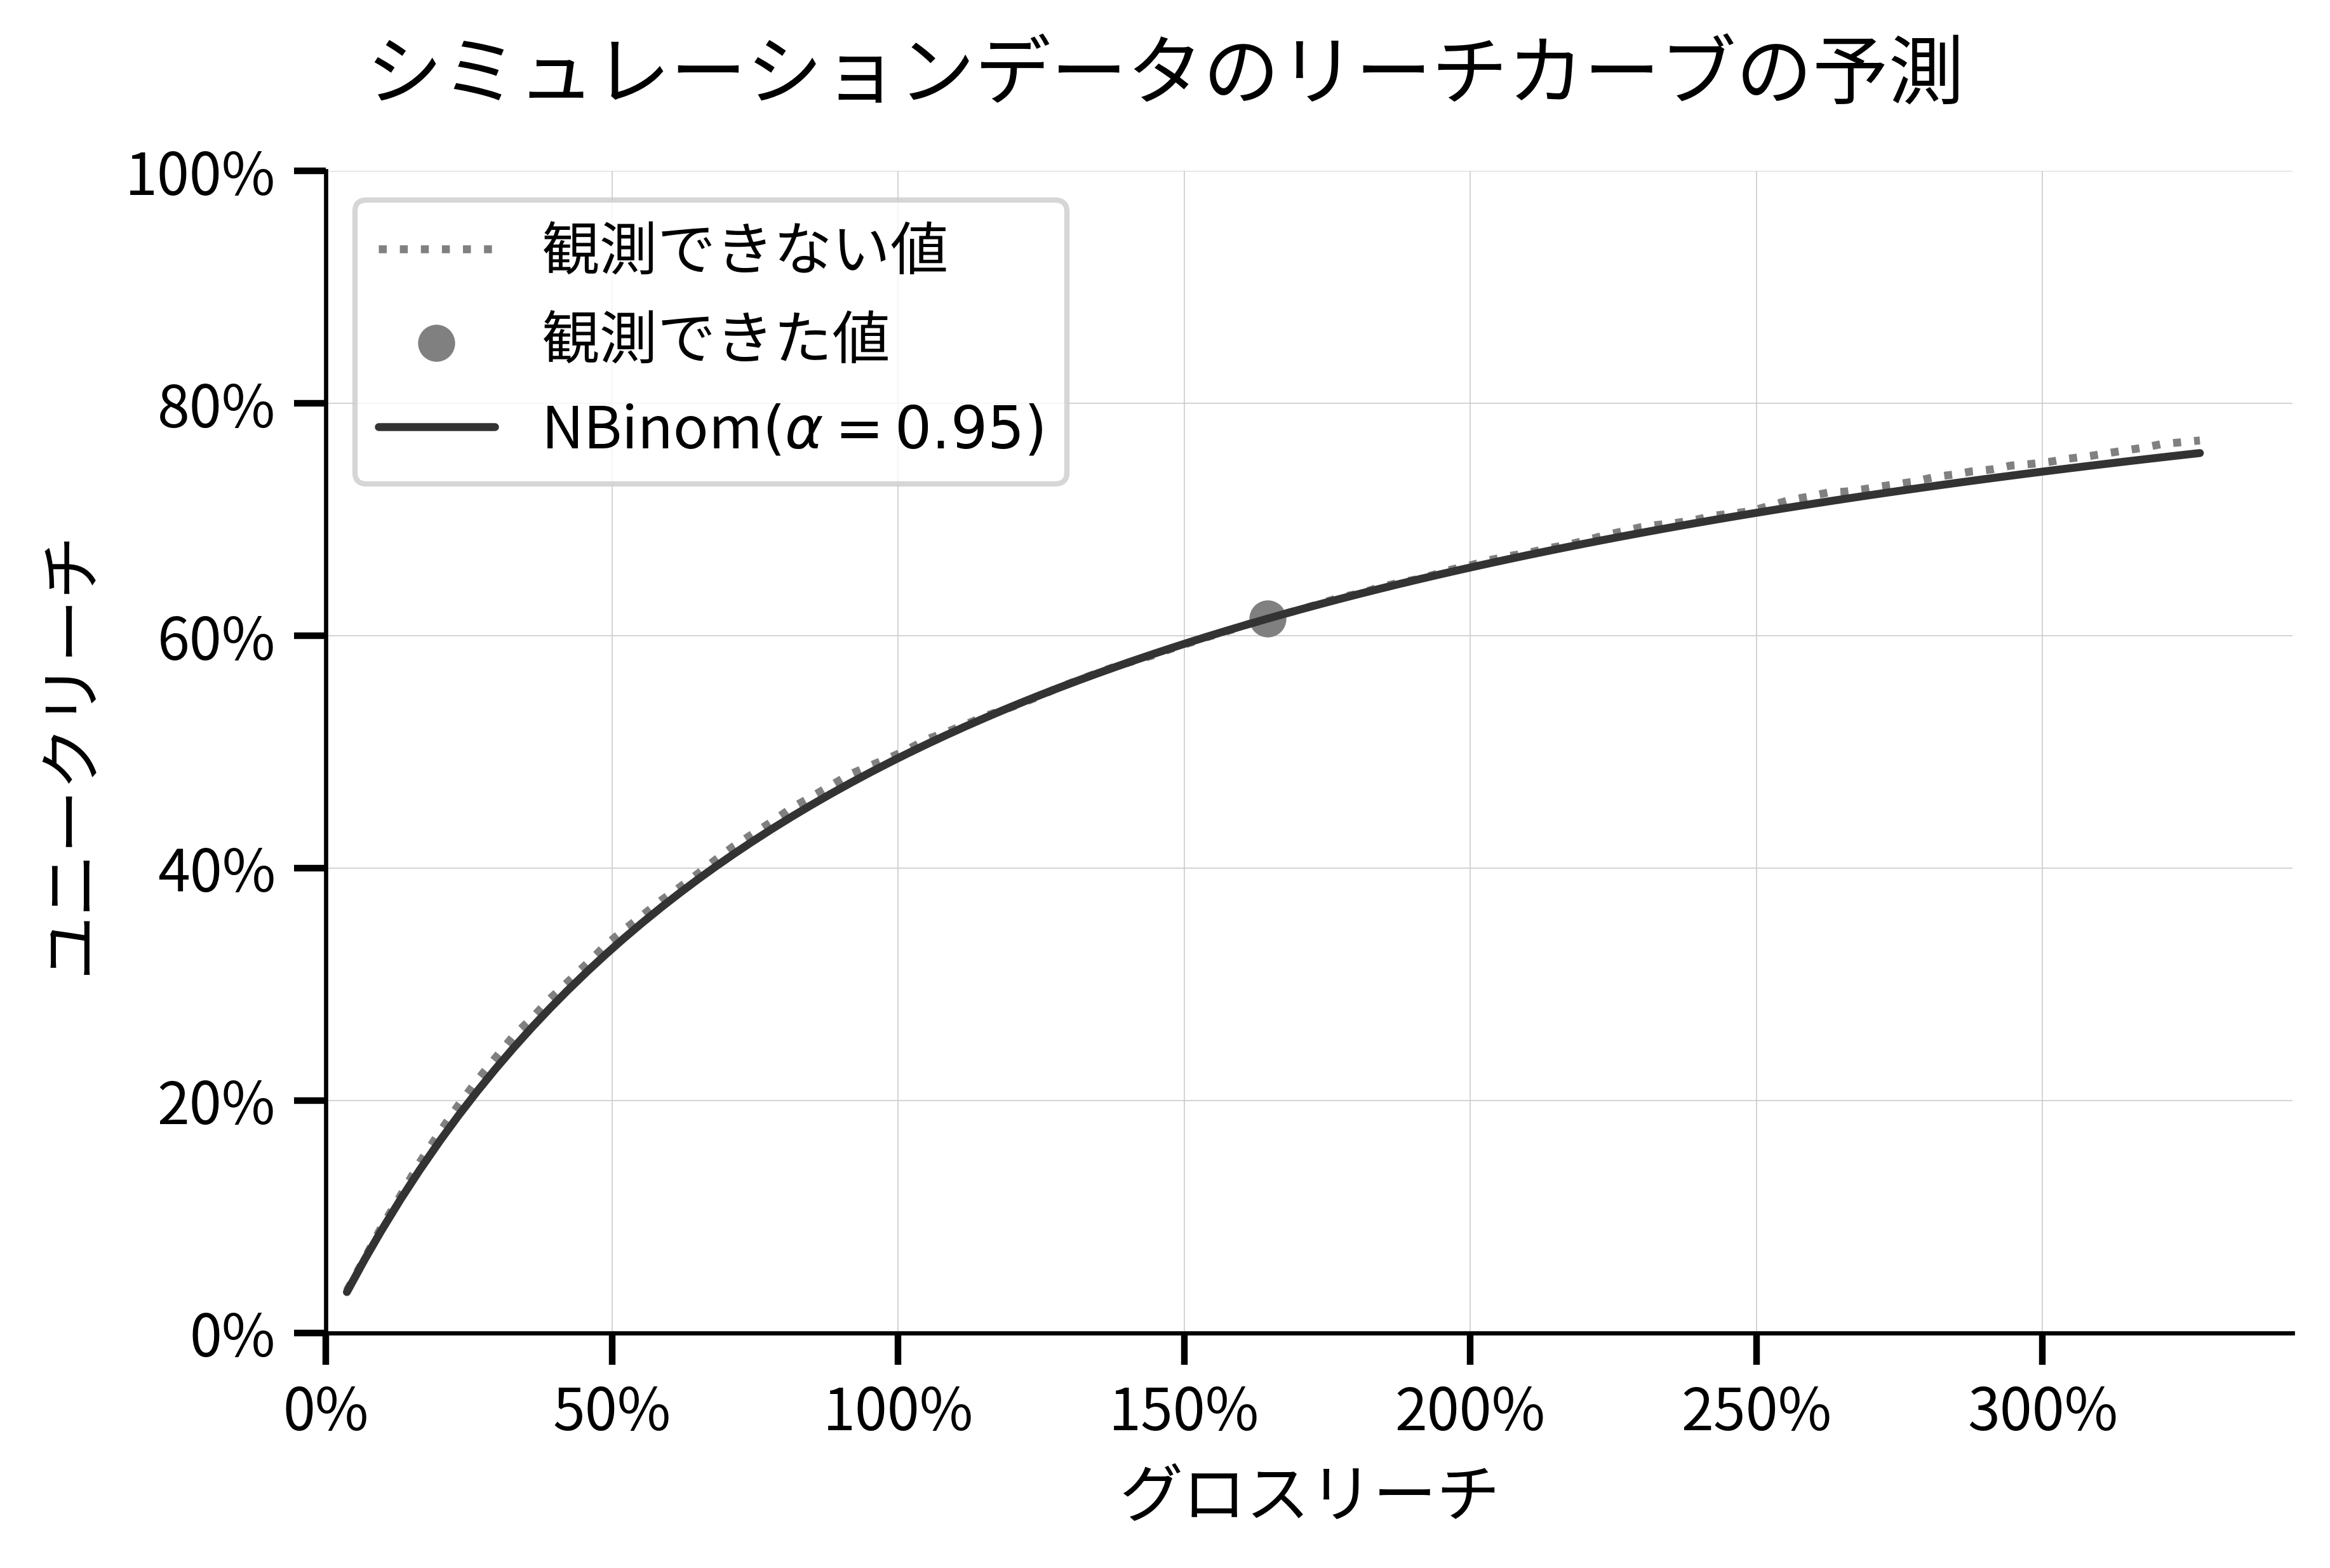

In [30]:
# 最適なalphaの推定
alpha_hat_sim = estimate_optimal_alpha(
    g=df_reach_sim_observed["g"], r=df_reach_sim_observed["r"]
)

# 負の二項分布を用いたリーチカーブ
r_pred_nbinom_sim = predict_reach_nbinom(g=df_reach_sim["g"], alpha=alpha_hat_sim)

# 推定したリーチカーブを可視化
fig, ax = plot_reach_curve_with_prediction(
    df_reach=df_reach_sim,
    df_reach_observed=df_reach_sim_observed,
    r_pred=r_pred_nbinom_sim,
    prediction_label=f"NBinom$(\\alpha = {alpha_hat_sim:.2f})$",
    title="シミュレーションデータのリーチカーブの予測",
)